<a href="https://colab.research.google.com/github/arpanbiswas52/MOBO_AFI_Supplements/blob/main/MOBO_AFI_paper_Supplements(Part_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Supplements material of the paper “Multi-objective Bayesian optimization of ferroelectric materials with interfacial control for memory and energy storage applications” (Part 3) 

-- Aug 24, 2021

prepared by **Arpan Biswas**

This notebook provides the codes of **physics driven MOBO**, which is presented in the **Section 3** of the entitled paper.

Here we illustrate,

-- MOBO implementation to physics based complex model -- Theoritical Model (2-4-6 KLGD for bulk PZO), proposed by -- **Anna N. Morozovska** and **Sergei V. Kalilin**  developed by -- **Eugene A. Eliseev** (in Mathematica) and **Arpan Biswas** (in Python)

Using the parameters for a prototype bulk antiferroelectric (PbZrO3), we first develop a physics-driven decision tree of target functions from the loop structures. We further develop a **physics-driven MOBO architecture** to explore multidimensional parameter space and build Pareto-frontiers by maximizing two target functions jointly- energy storage and loss. This approach allows for rapid initial materials and device parameter selection for a given application and can be further expanded towards the active experiment setting.





Install Packages

In [2]:
!pip install botorch #version 0.5.0
!pip install gpytorch #version 1.5.0
!pip install pymoo #version 0.4.2.2
!pip install atomai #version 0.7.2 (Optional)

     |████████████████████████████████| 475 kB 13.9 MB/s 
     |████████████████████████████████| 498 kB 55.6 MB/s 
     |████████████████████████████████| 3.7 MB 13.0 MB/s 
     |████████████████████████████████| 239 kB 53.3 MB/s 
  Created wheel for pymoo: filename=pymoo-0.4.2.2-cp37-cp37m-linux_x86_64.whl size=4940044 sha256=475599b07667bae9fa20a846aab60e54f071b1d4b59564351088f9b4aa77999b
  Stored in directory: /root/.cache/pip/wheels/ab/8c/89/c450ad360fc24cb70fec0388e8d95b51021eae5dab248ab76e
Successfully built pymoo
     |████████████████████████████████| 143 kB 14.6 MB/s 
     |████████████████████████████████| 193 kB 54.9 MB/s 
     |████████████████████████████████| 865 kB 56.2 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174982 sha256=8cc320d6d60487a8187c891abcadfed293c279fb9f454be943580daf155f25e5
  Stored in directory: /root/.cache/pip/wheels/f4/4e/dd/06777c90710ce1766376ecc87979967fe69ff3affc29c0b530
Successfully built mendeleev


Import functions

In [3]:
#Import classical numpy and torch
import torch as to
import numpy as np
#Plotting
import matplotlib.pyplot as plt
#Random # generator
import random

# Import pymoo package for MOO optimization using NGSA-2 (comparison with MOBO)
import pymoo
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

#Optional for making movies
import atomai as aoi

# Import GP and BoTorch functions
import gpytorch as gpt
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from botorch import fit_gpytorch_model
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import IIDNormalSampler
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from gpytorch.models import ExactGP

# Specific for MOBO
from botorch.generation import get_best_candidates, gen_candidates_torch
from botorch.optim import gen_batch_initial_conditions
from botorch.utils.transforms import unnormalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
# for qEIHV acquistion function (Posteriori method)
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
# for qParEGO acquisition function (Prioiri method)
from botorch.utils.sampling import sample_simplex #This defines weights to objectives randomly
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
# Important functions for MOBO- select non-dominated Pareto solutions and compute hypervolume
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume

#Import optimizer algorithm to train GP hyperparameters
from torch.optim import SGD
from torch.optim import Adam


#Import functions required for configure hysteresis loops from PZO model and automated task to develop decision tree of functionalities from loop structures
from numpy import linalg as LA
from scipy import optimize
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

#other math functions
from scipy.stats import norm

<h1>Complex Physics based numerical model- 2-4-6 KLGD for bulk PZO

Theoritical Model (2-4-6 KLGD for bulk PZO) using parameters as presented in the paper (link provided below)

Paper cite: https://arxiv.org/abs/2106.13096


This section quanitfy different functionlities from loops - which gives the physics driven decision tree.

For this paper, we focussed on functionlities- energy storage and loss functions in the decision tree.

**User need to run this cell before running MOBO to compute the functionalities.**

In [5]:
####################### Calculate free energy######################
def AFIloop(x, T, rho, h, dG, e):

    alpha_pt = 2.7969*10**5
    alpha_at = 4.8789*10**6
    Tp = 463.2
    Ta = 490
    beta_p = -3.825*10**8
    beta_a = -2.056*10**9
    xhi = 1.7754*10**10
    #xhi =0
    gamma_p = 3.126*10**9
    gamma_a = 2.28*10**10
    #gamma_p = 0
    #gamma_a = 0
    h=h*10**-9
    epsilon_b = 7
    l_da = 2*10**-9
    epsilon_d = 10
    epsilon_0 = 8.85*10**-12
    charge = 1.6*10**-19
    Z = [2, -2]
    n = [2, -2]
    Ai = [10**-18, 10**-18]
    kb = 1.38*10**-23
    delta_G = dG*charge
    U0= 5

    f1 = (1 + np.exp(delta_G / (kb * T)) * rho ** (1 / n[0])) ** (-1)
    f2 = (1 + np.exp(delta_G / (kb * T)) * rho ** (1 / n[1])) ** (-1)
    screen = ((l_da * h) / (epsilon_0 * ((epsilon_d * h) + (l_da * epsilon_b)))) * (((charge * Z[0] * f1) ** 2 / (Ai[0] * kb * T)) + ((charge * Z[1] * f2) ** 2 / (Ai[1] * kb * T)))
    Esi = (l_da / (epsilon_0 * ((epsilon_d * h) + (l_da * epsilon_b)))) * (((charge * Z[0] * f1) / Ai[0]) + ((charge * Z[1] * f1) / Ai[1]))
    # Ea = -(epsilon_d*U)/((epsilon_d*h) + (l_da*epsilon_b))
    # Eff = 0
    E = e / 10 ** -9
    Eff = Esi + E
    alpha_p = alpha_pt * (T - Tp)
    alpha_a = alpha_at * (T - Ta)
    alpha_pr = alpha_p * (1 + screen) + ((l_da * 0.5) / (epsilon_0 * ((epsilon_d * h) + (l_da * epsilon_b))))
    beta_pr = (1 + screen) * beta_p
    gamma_pr = (1 + screen) * gamma_p
    xhi_r = (1 + screen) * xhi
    En = alpha_pr * x[0] ** 2 + beta_pr * x[0] ** 4 + gamma_pr * x[0] ** 6 - Eff * x[0] + xhi_r * x[0] ** 2 * x[1] ** 2 + alpha_a * x[1] ** 2 + beta_a * x[1] ** 4 + gamma_a * x[1] ** 6

    return En

####################### Classification for zero loops######################
def objzeroloop(sol,e, T, rho):
    M=1
    p_mat = sol[313:437]
    E = e[313:437]

    slope_p = np.zeros((len(p_mat)-1))
    for i in range(0, len(p_mat)-1):
        p1 = p_mat[i]
        p2 = p_mat[i+1]
        slope_p[i]= (p1-p2)
    pks, pks_ht = find_peaks(slope_p, height=0.7*max(slope_p), distance=5)
    # number of peaks will determine the curve, for linear the slope is constant and wont have any peaks, for sigmoid 1 peaks, for wavy >1 peaks
    if (max(slope_p)<=1e-3) or ((max(slope_p)-min(slope_p))<1e-3): #linear, no sudden peaks
        index= range(0,len(pks))
        pks = np.delete(pks,index)

    npks = len(pks)
    if (npks > 2): #This to avoid in the loop structure when we sometimes get some impractical peaks due to convergence issues
        npks =2

    if (npks ==2):
        objeval = (npks + slope_p[pks[0]] + slope_p[pks[1]]) * M
    elif (npks==1):
        objeval = (npks + slope_p[pks[0]]) * M
    else:
        objeval = npks*M

    return objeval

####################### Classification for one loop######################
def objoneloop(sol,e, T, rho):
    M=1
    # In some cases for the limit of field interval, loop does not form fully- to avoid calculation issue for S.E and E.L,
    # we add the 1st step of the other half cycle and calculate the area- if the loop is formed for the E interval,
    # we add negligible area for this additional step as p(t+1) - p(t-1) is negligible in that case (using quadrature method for numerical integration)
    p_mats = sol[313:437]
    p_mats = np.hstack((p_mats, sol[188]))
    p_matt = sol[188:312]
    p_matt = np.hstack((p_matt, sol[313]))
    Es = e[313:437]
    Es = np.hstack((Es, e[188]))
    Et = e[188:312]
    Et = np.hstack((Et, e[313]))
    Emax = max(e[188:437])
    Emin = min(e[188:437])
    a_ps = np.zeros((len(p_mats)-1))
    a_pt = np.zeros((len(p_matt) - 1))
    for i in range(0, len(p_mats)-1):
        p1s = p_mats[i]
        p2s = p_mats[i+1]
        e1s = Es[i]
        e2s = Es[i+1]
        p1t = p_matt[i]
        p2t = p_matt[i+1]
        e1t = Et[i]
        e2t = Et[i+1]
        a_ps[i] = 0.5*np.absolute(p1s-p2s)*np.absolute(e1s-e2s) + np.absolute(p1s-p2s)*np.absolute(e2s-Emin)
        a_pt[i] = 0.5*np.absolute(p2t-p1t)*np.absolute(e2t-e1t) + np.absolute(p2t-p1t)*np.absolute(e1t-Emin)

    As = sum(a_ps)
    At = sum(a_pt)
    #Find build-in and coercive field
    iminabsp_mats = np.argmin(np.absolute(p_mats))
    iminabsp_matt = np.argmin(np.absolute(p_matt))
    Ec1 = Et[iminabsp_matt]
    Ec2 = Es[iminabsp_mats]
    lshift = 0.5*(Ec1 + Ec2)
    lwidth = (Ec1 - Ec2)
    objeval1 = lshift
    if (lwidth<0):
        objeval2 =0
    else:
        objeval2 =lwidth

    return objeval1, objeval2

####################### Classification for two loops######################
def objtwoloop(sol, diff_P, e,T,rho):
    M=1
    p_mat1 = sol[313:437]
    p_mat2 = np.flip(sol[188:312])
    E = e[313:437]
    d_p = (p_mat1 - p_mat2)
    zero_crossings = np.where(np.diff(np.sign(d_p)))[0]
    if (len(zero_crossings)==4):
        E_right= E[zero_crossings[1]+1]
        P_right = p_mat1[zero_crossings[1]+1]
        E_left = E[zero_crossings[2]]
        P_left = p_mat1[zero_crossings[2]]
        if ((p_mat1[zero_crossings[0]+1]>P_right) and (P_left>p_mat1[zero_crossings[3]])):
            E_length = np.absolute(E_right-E_left)
            P_length = np.absolute(P_right-P_left)
            loop_dist = np.sqrt(E_length**2 + P_length**2)
            objeval = loop_dist*M
        else:
            objeval = 0 #Avoiding cal loop distance for loops with some impractical spikes- May be better way to compute (will visit in future)
    else:
        objeval =0

    return objeval

####################### Classification for # of loops######################
def objnumloop(sol, diff_P, e):
    M=1
    d_p = diff_P[313:437] #Last half cycle
    pks, pks_ht = find_peaks(d_p, height=0.7*max(d_p), distance=5)
    if (max(d_p)<=1e-3) or ((max(d_p)-min(d_p))<1e-3):
        index= range(0,len(pks))
        pks = np.delete(pks,index)

    npks = len(pks)
    if (npks > 2): #This to avoid in the loop structure when we sometimes get some impractical peaks due to convergence issues
        npks =2

    objeval1 = npks*M

    return objeval1

####################### Calculate energy storage and loss######################
def calstorage(sol, e, T, rho):
    p_mats = sol[313:437]
    p_mats = np.hstack((p_mats, sol[188]))
    p_matt = sol[188:312]
    p_matt = np.hstack((p_matt, sol[313]))
    Es = e[313:437]
    Es = np.hstack((Es, e[188]))
    Et = e[188:312]
    Et = np.hstack((Et, e[313]))
    Emax = max(e[188:437])
    Emin = min(e[188:437])
    a_ps = np.zeros((len(p_mats) - 1))
    a_pt = np.zeros((len(p_matt) - 1))
    for i in range(0, len(p_mats) - 1):
        p1s = p_mats[i]
        p2s = p_mats[i + 1]
        e1s = Es[i]
        e2s = Es[i + 1]
        p1t = p_matt[i]
        p2t = p_matt[i + 1]
        e1t = Et[i]
        e2t = Et[i + 1]
        a_ps[i] = 0.5 * np.absolute(p1s - p2s) * np.absolute(e1s - e2s) + np.absolute(p1s - p2s) * np.absolute(e2s - Emin)
        a_pt[i] = 0.5 * np.absolute(p2t - p1t) * np.absolute(e2t - e1t) + np.absolute(p2t - p1t) * np.absolute(e1t - Emin)

    As = sum(a_ps)
    At = sum(a_pt)
    Al = At-As
    if (Al < -1e3):  # To avoid numerical issue for any impractical peaks or loops not formed for the given E interval, making Stored energy >> Total energy
        As = -1
        Al = -1
    return As, Al

####################### This function integrates all the above defined functions and quatifies the physics-driven decision tree at certain external field ######################
def funoptimize(T, rho, h, dG, e):

    niter=len(e)
    sol=np.zeros(niter)
    diff_P=np.zeros(niter)
    for j in range(0, niter):

        P_ini= np.matrix([[-1, -0.5, -0.5], [1, 0.5, 0.5]])
        A_ini = np.matrix([[0, -0.5, 0.5], [0, 0.5, -0.5]])
        s_left =np.zeros((len(np.transpose(P_ini)),2))
        s_right =np.zeros((len(np.transpose(P_ini)),2))
        for jj in range(0, len(np.transpose(P_ini))):
            x_left = [P_ini[0,jj], A_ini[0,jj]]
            x_right = [P_ini[1,jj], A_ini[1,jj]]
            s_left[jj,:] = optimize.fmin(AFIloop, x_left, args=(T, rho, h, dG, e[j]), disp=0)
            s_right[jj,:] = optimize.fmin(AFIloop, x_right, args=(T, rho, h, dG, e[j]), disp=0)

        diff_P[j] = np.absolute((max(s_right[:, 0])) - (min(s_left[:, 0])))
             #rightmost and leftmost minima found
        if (j==0):
            sol[0] = min(s_left[:,0])

        elif (j>0):
            if (e[j]< e[j-1]): #sweeping high positive to negative
                sol[j] = max(s_right[:,0])
            else: #sweeping high negative to positive
                sol[j] = min(s_left[:,0])

    objeval1 = objnumloop(sol, diff_P, e) #Define for number of loops
    nloop = objeval1
    # State 2 phase analysis, given we know the Stage 1- no. of loops
    if (nloop == 0):
        objeval2 = objzeroloop(sol,e, T, rho) #Define non-linearity of hysteresis curve for zero loop
        objeval3 = objeval2
    elif (nloop == 1):
        objeval2, objeval3 = objoneloop(sol,e, T, rho) #Define stored energy and shift of loop
        #objeval3 = (objeval1/2) + objeval3 # Centering the objective within the range of one loop- left and right of the center means negative and positive shifts shift
    elif (nloop == 2):
        objeval2 = objtwoloop(sol, diff_P, e,T,rho) #Define measure of separation between the loops
        objeval3 = objeval2
    #objeval11 = objeval1 + objeval2 # For storage in one loop
    #objeval12 = objeval1 + objeval3 # For loop shift/width in one loop

    # Calculate Energy storage and Loss for all regions-
    ES, EL = calstorage(sol, e, T, rho)
    return sol, objeval1, objeval2, objeval3, ES, EL

################### Different Plotting functions#################################

def plot_hysteresis(fig, ax, X1, X2, E, P, tp, r, t1, t2, param1, param2, linewidth, markersize, fontsize):
    ax[len(X1) - 1 - t1, t2].plot(E, P, 'o-', linewidth=linewidth, markersize=markersize)
    ax[len(X1) - 1 - t1, t2].axis('off')
    ax[len(X1) - 1 - t1, t2].set_title(str(param1) + " = " + str(tp) + ", " +str(param2)+" = " + str(r), fontsize=fontsize)
    return fig, ax

def plot_Storage_Loss(Storage, Loss, n_rows, tog_num, A):
    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(15, 7))
    ax2.imshow(Storage, origin='bottom', cmap='viridis')
    ax3.imshow(Loss, origin='bottom', cmap='viridis')
    if (n_rows<=tog_num):
        for i in range(0, Storage.shape[0]):
            for j in range(0, Storage.shape[1]):
                c1 = np.around((Storage[j, i]), decimals=2)
                c2 = np.around((Loss[j, i]), decimals=2)
                ax2.text(i, j, str(c1), va='center', ha='center')
                ax3.text(i, j, str(c2), va='center', ha='center')

    ax2.set_title('Storage, A= ' + str(A))
    ax3.set_title('Loss, A= ' + str(A))
    plt.show()

def plot_phase(X1, X2, phaseS1, sphasenoloop, sphaseoneloopc1, sphaseoneloopc2, sphasetwoloop, n_rows, tog_num, param1, param2):
    fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    ax1.imshow(X1, origin='bottom', cmap='PuBuGn')
    ax2.imshow(X2, origin='bottom', cmap='PuBuGn')
    ax3.imshow(phaseS1, origin='bottom', cmap='PuBuGn')

    if (n_rows <= tog_num):
        for i in range(0, phaseS1.shape[0]):
            for j in range(0, phaseS1.shape[1]):
                c11 = int(phaseS1[j, i])
                ax3.text(i, j, str(c11), color='red', va='center', ha='center')


    ax1.set_title(str(param1))
    ax2.set_title(str(param2))
    ax3.set_title('func eval (Stage1-# loops)')
    plt.show()

    # Plot for Stage 2- Phase diag for individual phase in Stage 1
    fig4, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 7))
    ax1.imshow(sphasenoloop, origin='bottom', cmap='Purples')
    ax2.imshow(sphaseoneloopc1, origin='bottom', cmap='Blues')
    ax3.imshow(sphaseoneloopc2, origin='bottom', cmap='Blues')
    ax4.imshow(sphasetwoloop, origin='bottom', cmap='Greens')

    if (n_rows <= tog_num):
        for i in range(0, phaseS1.shape[0]):
            for j in range(0, phaseS1.shape[1]):

                c11 = sphasenoloop[j, i]
                c12 = sphaseoneloopc1[j, i]
                c13 = sphaseoneloopc2[j, i]
                c14 = sphasetwoloop[j, i]
                if (c11 > np.min(sphasenoloop)):
                    c11 = np.around(c11, decimals=2)
                    ax1.text(i, j, str(c11), color='red', va='center', ha='center')
                if (c12 > np.min(sphaseoneloopc1)):
                    c12 = np.around(c12, decimals=2)
                    ax2.text(i, j, str(c12), color='red', va='center', ha='center')
                if (c13 > np.min(sphaseoneloopc2)):
                    c13 = np.around(c13, decimals=2)
                    ax3.text(i, j, str(c13), color='red', va='center', ha='center')
                if (c14 > np.min(sphasetwoloop)):
                    c14 = np.around(c14, decimals=2)
                    ax4.text(i, j, str(c14), color='red', va='center', ha='center')

    ax1.set_title('func eval (Stage2-no loop)')
    ax2.set_title('func eval (Stage2-one loop: shift)')
    ax3.set_title('func eval (Stage2-one loop: width)')
    ax4.set_title('func eval (Stage2-two loop)')
    plt.show()


############### Function to configure phase diag matrix of loop classifications- considering from the best loop creation at different external field (minimizing numerical errors)#############################

def phase_matrix(X1, X2, objphaseS1A, objphaseS2C1A, objphaseS2C2A, num_rows, toggle_num_dim, param1, param2):
    M=10
    maxobjphase = np.max(objphaseS1A, axis=1)  # store obj func for phase classifies # loops
    objS2C1 = np.zeros(len(maxobjphase))
    objS2C2 = np.zeros(len(maxobjphase))
    for ii in range(0, len(maxobjphase)):
        cand = [k for k, j in enumerate(objphaseS1A[ii, :]) if j == maxobjphase[ii]]
        o1 = np.zeros(len(cand))
        o2 = np.zeros(len(cand))
        for jj in range(0, len(cand)):
            o1[jj] = objphaseS2C1A[ii, cand[jj]]
            o2[jj] = objphaseS2C2A[ii, cand[jj]]

        objS2C1[ii] = max(o1) * M
        #cd1 = np.argmax(o1)
        objS2C2[ii] = np.sign(min(o2)) * min(np.absolute(o2)) * M
        #cd2 = np.argmin(np.absolute(o2))

    sphasenoloop = np.zeros(len(maxobjphase)) + np.min(objS2C1) - 0.1 * (np.max(objS2C1) - np.min(objS2C1))
    sphaseoneloopc1 = np.zeros(len(maxobjphase)) + np.min(objS2C1) - 0.1 * (np.max(objS2C1) - np.min(objS2C1))
    sphaseoneloopc2 = np.zeros(len(maxobjphase)) + np.min(objS2C2) - 0.1 * (np.max(objS2C2) - np.min(objS2C2))
    sphasetwoloop = np.zeros(len(maxobjphase)) + np.min(objS2C1) - 0.1 * (np.max(objS2C1) - np.min(objS2C1))

    # Creating subspace matrix- Putting fake values for the other phases different than the subspace
    for ii in range(0, len(maxobjphase)):
        if (maxobjphase[ii] == 0):
            sphasenoloop[ii] = objS2C1[ii]
        if (maxobjphase[ii] == 1):
            sphaseoneloopc1[ii] = objS2C1[ii]
            sphaseoneloopc2[ii] = objS2C2[ii]
        if (maxobjphase[ii] == 2):
            sphasetwoloop[ii] = objS2C1[ii]

    maxobjphase = np.reshape(maxobjphase, (len(X1), len(X1)))
    sphasenoloop = np.reshape(sphasenoloop, (len(X1), len(X1)))
    sphaseoneloopc1 = np.reshape(sphaseoneloopc1, (len(X1), len(X1)))
    sphaseoneloopc2 = np.reshape(sphaseoneloopc2, (len(X1), len(X1)))
    sphasetwoloop = np.reshape(sphasetwoloop, (len(X1), len(X1)))

    # Plot full objective grid image defined from hysteresis loops- classifies #of loops, other criteria for each loops
    # Plot Stage 2 decision tree phases, each for no loop, one loop and two loops

    plot_phase(X1, X2, maxobjphase, sphasenoloop, sphaseoneloopc1, sphaseoneloopc2, sphasetwoloop, num_rows,
               toggle_num_dim, param1, param2)

    return maxobjphase, sphasenoloop, sphaseoneloopc1, sphaseoneloopc2, sphasetwoloop


<h1> Now, we define classes/functions for MOBO architecture

Below section defines the list of functions (user calls these functions during analysis):
1. Gaussian Process
2. Optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
3. Posterior means and variance computation
4. Acquistion functions for MOBO- qEIHV and qParEGO

GP models are configured using GPyTorch package and to handle multiple independent GP models (for individual objectives), we utilize multi-output GP function, ModelListGP

To initialize the computation of the acquisition function, we select 20 restart initial locations for a set of 1000 random points, and considered maximum iterations of 200. The acquisition function is approximated using 500 Monte-Carlo (MC) based samples. 

In [6]:
#########################Gaussian Process########################

class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        ## Here we use constant mean, user can change here with different mean function
        self.mean_module = ConstantMean()
        ## Here we use Radial Basis function kernel, user can change here with different kernel function
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

############## Optimize Hyperparameters of GP##############################
def optimize_hyperparam_trainGP(train_X_norm, train_Y_norm):
    # Gp model fit

    gp_surro1 = SimpleCustomGP(train_X_norm, train_Y_norm[:, 0])
    gp_surro2 = SimpleCustomGP(train_X_norm, train_Y_norm[:, 1])
    gp_surro = ModelListGP(gp_surro1, gp_surro2)
    gp_surro = gp_surro.double()
    gp_surro.likelihood.likelihoods[0].noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    gp_surro.likelihood.likelihoods[1].noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    mll1 = ExactMarginalLogLikelihood(gp_surro.likelihood.likelihoods[0], gp_surro.models[0])
    mll2 = ExactMarginalLogLikelihood(gp_surro.likelihood.likelihoods[1], gp_surro.models[1])
    # fit_gpytorch_model(mll)
    mll1 = mll1.to(train_X_norm)
    mll2 = mll2.to(train_X_norm)
    gp_surro.models[0].train()
    gp_surro.likelihood.likelihoods[0].train()
    gp_surro.models[1].train()
    gp_surro.likelihood.likelihoods[1].train()
    ## Here we use Adam optimizer with learning rate =0.2, user can change here with different algorithm and/or learning rate for each GP
    optimizer1 = Adam([{'params': gp_surro.models[0].parameters()}], lr=0.2)
    optimizer2 = Adam([{'params': gp_surro.models[1].parameters()}], lr=0.2)

    NUM_EPOCHS = 150

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output1 = gp_surro.models[0](train_X_norm)
        output2 = gp_surro.models[1](train_X_norm)
        # Compute negative marginal log likelihood
        loss1 = - mll1(output1, gp_surro.models[0].train_targets)
        loss2 = - mll2(output2, gp_surro.models[1].train_targets)
        # back prop gradients
        loss1.backward(retain_graph=True)
        # back prop gradients
        loss2.backward(retain_graph=True)
        # print last iterations
        if (epoch + 1) > NUM_EPOCHS: #Stopping the print for now
            print("GP Model trained:")
            print("Iteration:" + str(epoch + 1))
            print("Loss for ob1:" + str(loss1.item()))
            print("Loss for ob2:" + str(loss2.item()))
            # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
            print("noise for obj1:" + str(gp_surro.likelihood.likelihoods[0].noise.item()))
            print("noise for obj2:" + str(gp_surro.likelihood.likelihoods[1].noise.item()))

        optimizer1.step()
        optimizer2.step()

    gp_surro.models[0].eval()
    gp_surro.likelihood.likelihoods[0].eval()
    gp_surro.models[1].eval()
    gp_surro.likelihood.likelihoods[1].eval()
    return gp_surro

##########################GP posterior predictions#############################
def cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows):
    y_pred_means = to.empty(num_rows, num_rows, 2)
    y_pred_vars = to.empty(num_rows, num_rows, 2)
    for t1, (x1, x2, y1, y2) in enumerate(zip(testX1_norm, testX2_norm, t_y[:, :, 0], t_y[:, :, 1])):
        for t2, (xx1, xx2, yy1, yy2) in enumerate(zip(x1, x2, y1, y2)):

            if (xx1 == -1 and xx2 == -1):
                y_pred_means[t1, t2, 0] = yy1
                y_pred_vars[t1, t2, 0] = 1e-8
                y_pred_means[t1, t2, 1] = yy2
                y_pred_vars[t1, t2, 1] = 1e-8
            else:
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False,
                                                    solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y1_pred_surro, y2_pred_surro = gp_surro.models[0].posterior(test_X), gp_surro.models[1].posterior(test_X)
                    y_pred_means[t1, t2, 0] = y1_pred_surro.mean
                    y_pred_vars[t1, t2, 0] = y1_pred_surro.variance
                    y_pred_means[t1, t2, 1] = y2_pred_surro.mean
                    y_pred_vars[t1, t2, 1] = y2_pred_surro.variance

    return y_pred_means, y_pred_vars


########## MOBO acquisition function ###########################
# q-Expected Improvement acquistion function ###########
def optimize_qehvi(model, train_X, train_obj, rf, BATCH_SIZE):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    sampler = SobolQMCNormalSampler(num_samples=500, seed=0, resample=False)
    #BATCH_SIZE = 4
    partitioning = NondominatedPartitioning(ref_point=rf, Y=train_obj)
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=rf.tolist(),  # use known reference point
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    new_x, value = optimize_acqf(
        acq_function=acq_func,
        bounds=to.tensor([[0.0] * 2, [1.0] * 2]),
        q=BATCH_SIZE,
        num_restarts=20,
        raw_samples=1000,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "nonnegative": True},
        sequential=True,
    )


    return new_x, value

# q-PAREGO acquistion function ###########
def optimize_qparego(model, train_X, train_obj, BATCH_SIZE):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization
    of the qParEGO acquisition function, and returns a new candidate and observation."""
    sampler = SobolQMCNormalSampler(num_samples=500, seed=0, resample=False)
    #BATCH_SIZE = 4
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        n_obj = train_obj.dim()
        weights = sample_simplex(n_obj, **tkwargs).squeeze()
        objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=train_obj))
        acq_func = qExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            best_f=objective(train_obj).max(),
            sampler=sampler,
        )
        acq_func_list.append(acq_func)
    # optimize
    new_x, value = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=to.tensor([[0.0] * 2, [1.0] * 2]),
        num_restarts=20,
        raw_samples=1000,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )


    return new_x, value




Other list of functions-

1. Evaluate initial data and normalize all data
2. Evaluate functions for new data and augment data

**These functions integrates with the physics-based models (eg. 2-4-6 PZO) and  call the function evaluations (eg. Energy storage and loss) as prior knowledge to MOBO.**

Here, user can replace with different function evaluations or any other physics based models (showed in-code where to make appropiate changes)

In [7]:
# Normalize all data. It is very important to fit GP model and MOBO exploration with normalized data to avoid issues such as
# - decrease of GP performance due to largely spaced real-valued data X, over-weighting on higher valued objectives Y in acquistion function computation.
def normalize_get_initialdata_PZO(X1, X2, fix_x1, fix_x2, E, test_X1, test_X2, num_rows, num, param1, param2, problem, m):
#Normalize X
    minX1 = min(X1)
    maxX1 = max(X1)
    minX2 = min(X2)
    maxX2 = max(X2)
    Xmin = np.hstack((minX1, minX2))
    Xmax = np.hstack((maxX1, maxX2))
    X1, X2 = np.meshgrid(X1, X2)
    test_X1, test_X2 = np.meshgrid(test_X1, test_X2)
    X1_norm = (X1-Xmin[0])/(Xmax[0]-Xmin[0])
    X2_norm = (X2-Xmin[1])/(Xmax[1]-Xmin[1])
    testX1_norm = (test_X1-Xmin[0])/(Xmax[0]-Xmin[0])
    testX2_norm = (test_X2-Xmin[1])/(Xmax[1]-Xmin[1])

    # Select starting samples randomly as training data
    testX1_norm = np.reshape(testX1_norm, (num_rows ** 2, 1))
    testX2_norm = np.reshape(testX2_norm, (num_rows ** 2, 1))
    test_X1 = np.reshape(test_X1, (num_rows ** 2, 1))
    test_X2 = np.reshape(test_X2, (num_rows ** 2, 1))
    np.random.seed(10)
    ind_start = np.random.choice(len(testX1_norm) - 1, size=num, replace=False)
    train_X = np.zeros((num, 2))
    train_X_norm = np.zeros((num, 2))
    train_y = np.zeros((num, 2))
    t_y = np.zeros((num_rows**2,2))
    m=0
    print("Function evaluaton for initial randomly selected samples")
    for i in range(0, num):
        train_X_norm[i, 0] = testX1_norm[ind_start[i]]
        train_X_norm[i, 1] = testX2_norm[ind_start[i]]
        train_X[i, 0]= test_X1[ind_start[i]]
        train_X[i, 1]= test_X2[ind_start[i]]
        print("Function eval #" + str(m + 1))

        ################# Here we integrate the functionalities from physics driven decision tree (prior physics based knowledge) with classical MOBO-- physics driven MOBO
        #Function evaluation is done by calling the function 'funoptimize(T, rho, h, deltaG, E)' in PZO model which returns all the quatification of physics-based decision tree functionlities.
        # Pmat is the array of polarization at each time step which plots the hysteresis loop
        # objeval is the scalar quatification of classification of # of loops (objeval =0, 1, 2 classifies zero, one and two loop)
        # objeval2 is the scalar quatification of level 2 classification, given the number of loops (objeval value)
        # objeval3 is the scalar quatification of level 2 classification, given only for one loop (objeval =1). For objeval =0 and 2, objeval2 = objeval3
        # ES, EL are the scalar quantification of energy storage and loss, irrespective of any loops.
        # Here, user can replace with any other physics based models
        if (param1 == 'Temp') and (param2 == 'prho'):
            h= fix_x1
            deltaG = fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL= funoptimize(train_X[i, 0], 10**train_X[i, 1], h, deltaG, E)
        elif (param1 == 'Temp') and (param2 == 'h'):
            rho= 10**fix_x1
            deltaG = fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(train_X[i, 0], rho, train_X[i, 1], deltaG, E)
        elif (param1 == 'Temp') and (param2 == 'deltaG'):
            rho= 10**fix_x1
            h = fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(train_X[i, 0], rho, h, train_X[i, 1], E)
        elif (param1 == 'prho') and (param2 == 'h'):
            T= fix_x1
            deltaG = fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(T, 10**train_X[i, 0], train_X[i, 1], deltaG, E)
        elif (param1 == 'prho') and (param2 == 'deltaG'):
            h= T
            h = fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(T, 10**train_X[i, 0], h, train_X[i, 1], E)
        elif (param1 == 'h') and (param2 == 'deltaG'):
            T= fix_x1
            rho = 10**fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(T, rho, train_X[i, 0], train_X[i, 1], E)
        else:
            print("Error: Choose 2 params considering the sequence as mentioned")

        ################By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        # Here, user can replace with any other functionalities for the PZO model as appropiate- and insert those to train_y and t_y
        if (problem[0]=='min'):
            train_y[i, 0] = -ES #By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
            t_y[ind_start[i], 0] = -ES #By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        else:
            train_y[i, 0] = ES
            t_y[ind_start[i], 0] = ES

        if (problem[1]=='min'):
            train_y[i, 1] = -EL #By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
            t_y[ind_start[i], 1] = -EL #By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        else:
            train_y[i, 1] = EL
            t_y[ind_start[i], 1] = EL

        #testX1_norm[ind_start[i]] =-1
        #testX2_norm[ind_start[i]] =-1
        m = m + 1

    testX1_norm = np.reshape(testX1_norm, (num_rows, num_rows))
    testX2_norm = np.reshape(testX2_norm, (num_rows, num_rows))
    t_y = np.reshape(t_y, (num_rows, num_rows, 2))

    #Convert to torch
    train_X_norm = to.from_numpy(train_X_norm)
    train_X_norm = train_X_norm.double()
    train_Y = to.from_numpy(train_y)
    #Normalize Y
    testY1_norm = (train_Y[:,0]-train_Y[:,0].min())/(train_Y[:,0].max()-train_Y[:,0].min())
    testY2_norm = (train_Y[:,1]-train_Y[:,1].min())/(train_Y[:,1].max()-train_Y[:,1].min())
    train_Y_norm = to.empty(train_Y.__len__(), 2)
    train_Y_norm[:,0]=testY1_norm
    train_Y_norm[:,1]=testY2_norm

    return X1_norm, X2_norm, testX1_norm, testX2_norm, train_X, train_X_norm, train_Y, train_Y_norm, Xmin, Xmax, t_y, m

################################Augment data - Existing training data with new evaluated data################################
def augment_newdata_PZO(acq_X, train_X, train_X_norm, train_Y, fix_x1, fix_x2, E, Xmin, Xmax, BATCH_SIZE, num_rows, param1, param2, problem, m):
    nextX_norm = acq_X
    nextX = nextX_norm*(to.from_numpy(Xmax)-to.from_numpy(Xmin)) + to.from_numpy(Xmin)
    nextX = nextX.detach().numpy()
    train_X_norm = to.cat((train_X_norm, nextX_norm), 0)
    train_X_norm = train_X_norm.double()
    train_X = np.vstack((train_X, nextX))
    next_feval = to.empty(BATCH_SIZE, 2)
    print("Batch Function eval #" + str(m + 1))

    for j in range(0, BATCH_SIZE):
                # Function evaluation for new data
        print("Within batch: Function eval: " + str(j + 1) + " of " +str(BATCH_SIZE))
        ############################# Here we integrate the functionalities from physics driven decision tree (prior physics based knowledge) with classical MOBO-- physics driven MOBO
        #Function evaluation is done by calling the function 'funoptimize(T, rho, h, deltaG, E)' in PZO model which returns all the quatification of physics-based decision tree functionlities.
        # Pmat is the array of polarization at each time step which plots the hysteresis loop
        # objeval is the scalar quatification of classification of # of loops (objeval =0, 1, 2 classifies zero, one and two loop)
        # objeval2 is the scalar quatification of level 2 classification, given the number of loops (objeval value)
        # objeval3 is the scalar quatification of level 2 classification, given only for one loop (objeval =1). For objeval =0 and 2, objeval2 = objeval3
        # ES, EL are the scalar quantification of energy storage and loss, irrespective of any loops.
        # Here, user can replace with any other physics based models
        if (param1 == 'Temp') and (param2 == 'prho'):
            h= fix_x1
            deltaG = fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(nextX[j, 0], 10**nextX[j, 1], h, deltaG, E)
        elif (param1 == 'Temp') and (param2 == 'h'):
            rho= 10**fix_x1
            deltaG = fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(nextX[j, 0], rho, nextX[j, 1], deltaG, E)
        elif (param1 == 'Temp') and (param2 == 'deltaG'):
            rho= 10**fix_x1
            h = fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(nextX[j, 0], rho, h, nextX[j, 1], E)
        elif (param1 == 'prho') and (param2 == 'h'):
            T= fix_x1
            deltaG = fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(T, 10**nextX[j, 0], nextX[j, 1], deltaG, E)
        elif (param1 == 'prho') and (param2 == 'deltaG'):
            T= fix_x1
            h = fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(T, 10**nextX[j, 0], h, nextX[j, 1], E)
        elif (param1 == 'h') and (param2 == 'deltaG'):
            T= fix_x1
            rho = 10**fix_x2
            Pmat, objeval, objeval2, objeval3, ES, EL = funoptimize(T, rho, nextX[j, 0], nextX[j, 1], E)
        else:
            print("Error: Choose 2 params considering the sequence as mentioned")

        ######################### By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        # Here, user can replace with any other functionalities for the PZO model as appropiate- and insert those to train_y and t_y
        if (problem[0] == 'min'):
            next_feval[j, 0] = -ES
        else:
            next_feval[j, 0] = ES
        if (problem[1] == 'min'):
            next_feval[j, 1] = -EL
        else:
            next_feval[j, 1] = EL

    train_Y = to.cat((train_Y, next_feval), 0)
            # Normalize Y
    testY1_norm = (train_Y[:, 0] - train_Y[:, 0].min()) / (train_Y[:, 0].max() - train_Y[:, 0].min())
    testY2_norm = (train_Y[:, 1] - train_Y[:, 1].min()) / (train_Y[:, 1].max() - train_Y[:, 1].min())
    train_Y_norm = to.empty(train_Y.__len__(), 2)
    train_Y_norm[:, 0] = testY1_norm
    train_Y_norm[:, 1] = testY2_norm
    m = m + 1

    return train_X, train_X_norm, train_Y, train_Y_norm, m

Functions to select non-dominated Pareto solutions and compute Hypervolume

**These are important functions in the MOBO setting**

In [8]:
################## compute pareto front###################
def select_Pareto(train_Y_norm, train_X_norm, train_Y, train_X):
    pareto_mask_norm = is_non_dominated(train_Y_norm)
    pareto_y_norm = train_Y_norm[pareto_mask_norm]
    pareto_x_norm = train_X_norm[pareto_mask_norm]
    pareto_mask = is_non_dominated(train_Y)
    pareto_y = train_Y[pareto_mask]
    pareto_x = train_X[pareto_mask]
    return pareto_y_norm, pareto_x_norm, pareto_y, pareto_x

###################compute hypervolume###########################
def calHV(rf, pareto_y_norm):
    hv = Hypervolume(ref_point=rf)
    volume = hv.compute(pareto_y_norm)
    return volume

Plots for iterative individual predicted functions and non-dominated Pareto Solutions, final Pareto frontier in multi-objective and multi-parameter space

**This is an important plotting function where user will understand the building of Pareto frontier for a given problem, and the user can adust images based on their convinience**

In [9]:
######################################### Plots for prediction of individual objectives and location of selected samples

def plot_exploration_results(X1, X2, Gp_y_mu, Gp_y_var, train_X, train_Y, iter, param1, param2, obj1, obj2, problem):
    if (problem[0]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 0] = -Gp_y_mu[:, :, 0]
        train_Y[:,0] = -train_Y[:,0]
    if (problem[1]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 1] = -Gp_y_mu[:, :, 1]
        train_Y[:,1] = -train_Y[:,1]

    _, ax = plt.subplots(3, 2, figsize=(12, 15))
    ax[0, 0].imshow(X1, origin='bottom', cmap='viridis')
    ax[0, 1].imshow(X2, origin='bottom', cmap='viridis')
    ax[1, 0].imshow(Gp_y_mu[:, :, 0].detach().numpy(), origin='bottom', cmap='viridis')
    ax[1, 1].imshow(Gp_y_var[:, :, 0].detach().numpy(), origin='bottom', cmap='viridis')
    ax[2, 0].imshow(Gp_y_mu[:, :, 1].detach().numpy(), origin='bottom', cmap='viridis')
    ax[2, 1].imshow(Gp_y_var[:, :, 1].detach().numpy(), origin='bottom', cmap='viridis')
    ax[0, 0].set_title(str(param1))
    ax[0, 1].set_title(str(param2))
    ax[1, 0].set_title(str(obj1)+" (GP), iter=" + str(iter))
    ax[1, 1].set_title("Uncertainty, iter=" + str(iter))
    ax[2, 0].set_title(str(obj2)+" (GP), iter=" + str(iter))
    ax[2, 1].set_title("Uncertainty, iter=" + str(iter))
    plt.show()
    # plt.colorbar()

    #train_X = train_X.detach().numpy()
    #train_Y = train_Y.detach().numpy()
    fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    ax[0].scatter(train_X[:, 0], train_X[:, 1], c=train_Y[:,0], cmap='viridis', linewidth=0.2)
    ax[0].set_xlabel(str(param1))
    ax[0].set_ylabel(str(param2))
    ax[0].set_title(str(obj1)+" (cmap), iter=" + str(iter))
    ax[1].scatter(train_X[:, 0], train_X[:, 1], c=train_Y[:,1], cmap='viridis', linewidth=0.2)
    ax[1].set_xlabel(str(param1))
    #ax[1].set_ylabel(str(param2))
    ax[1].set_title(str(obj2)+" (cmap), iter=" + str(iter))
    plt.show()

    #Retransforming for the optimization problem
    if (problem[0]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 0] = -Gp_y_mu[:, :, 0]
        train_Y[:,0] = -train_Y[:,0]
    if (problem[1]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 1] = -Gp_y_mu[:, :, 1]
        train_Y[:,1] = -train_Y[:,1]
    

############################### Plots for Pareto frontier formation in the normalized and real-valued objective and parameter space
def plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, n_initial, N_BO, BATCH_SIZE, param1, param2, obj1, obj2, problem):
    if (problem[0]=='min'): #Transform to original function value
        train_Y[:,0] = -train_Y[:,0]
        train_Y_norm[:,0] = -train_Y_norm[:,0]
        pareto_y[:,0] = -pareto_y[:,0]
        pareto_y_norm[:,0] = -pareto_y_norm[:,0]
    if (problem[1]=='min'): #Transform to original function value
        train_Y[:,1] = -train_Y[:,1]
        train_Y_norm[:, 1] = -train_Y_norm[:, 1]
        pareto_y[:,1] = -pareto_y[:,1]
        pareto_y_norm[:,1] = -pareto_y_norm[:,1]
    batch_number = to.cat([to.zeros(n_initial), to.arange(1, N_BO + 1).repeat(BATCH_SIZE, 1).t().reshape(-1)]).numpy()

    ## Pareto in objective space
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes[0,0].scatter(train_Y_norm[:, 0], train_Y_norm[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,0].set_xlabel(str(obj1))
    axes[0,0].set_xlim((-0.1, 1.1))
    axes[0,0].set_ylabel(str(obj2))
    axes[0,0].set_ylim((-0.1, 1.1))
    axes[0,0].set_title('Samples over (normalized)objective space, iter=' + str(N_BO + 1))
    axes[0,1].scatter(train_Y[:, 0], train_Y[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,1].set_xlabel(str(obj1))
    #axes[0,1].set_xlim((-5, 165)) #Remember to comment out the limits for running general problem. We put the limit manually for each analysis of param space for paper purpose (Comparison)
    #axes[0,1].set_ylim((-9.5, -2.5))
    #axes[0,1].set_ylabel(str(obj2))
    axes[0,1].set_title('Samples over (real)objective space, iter=' + str(N_BO + 1))
    axes[1,0].scatter(pareto_y_norm[:, 0], pareto_y_norm[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,0].set_xlabel(str(obj1))
    axes[1,0].set_xlim((-0.1, 1.1))
    axes[1,0].set_ylabel(str(obj2))
    axes[1,0].set_ylim((-0.1, 1.1))
    axes[1,0].set_title('Pareto frontier over (normalized)objective space, iter=' + str(N_BO + 1))
    axes[1,1].scatter(pareto_y[:, 0], pareto_y[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,1].set_xlabel(str(obj1))
    #axes[1,1].set_xlim((-5, 165)) #Remember to comment out the limits for running general problem. We put the limit manually for each analysis of param space for paper purpose (Comparison)
    #axes[1,1].set_ylim((-9.5, -2.5))
    #axes[1,1].set_ylabel(str(obj2))
    axes[1,1].set_title('Pareto frontier over (real)objective space, iter=' + str(N_BO + 1))

    ## Pareto in parameter space
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes[0,0].scatter(train_X_norm[:, 0], train_X_norm[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,0].set_xlabel(str(param1))
    axes[0,0].set_xlim((-0.1, 1.1))
    axes[0,0].set_ylabel(str(param2))
    axes[0,0].set_ylim((-0.1, 1.1))
    axes[0,0].set_title('Samples over over (normalized)parameter space, iter=' + str(N_BO + 1))
    axes[0,1].scatter(train_X[:, 0], train_X[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,1].set_xlabel(str(param1))
    #axes[0,1].set_xlim((295, 405)) #Remember to comment out the limits for running general problem. We put the limit manually for each analysis of param space for paper purpose (Comparison)
    #axes[0,1].set_ylim((3.5, 8.5))
    #axes[0,1].set_ylabel(str(param2))
    axes[0,1].set_title('Samples over over (real)parameter space, iter=' + str(N_BO + 1))
    axes[1,0].scatter(pareto_x_norm[:, 0], pareto_x_norm[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,0].set_xlabel(str(param1))
    axes[1,0].set_xlim((-0.1, 1.1))
    axes[1,0].set_ylabel(str(param2))
    axes[1,0].set_ylim((-0.1, 1.1))
    axes[1,0].set_title('Pareto frontier over (normalized)parameter space, iter=' + str(N_BO + 1))
    axes[1,1].scatter(pareto_x[:, 0], pareto_x[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,1].set_xlabel(str(param1))
    #axes[1,1].set_xlim((295, 405)) #Remember to comment out the limits for running general problem. We put the limit manually for each analysis of param space for paper purpose (Comparison)
    #axes[1,1].set_ylim((3.5, 8.5))
    #axes[1,1].set_ylabel(str(param2))
    axes[1,1].set_title('Pareto frontier over (real)parameter space, iter=' + str(N_BO + 1))

    #Retransforming for the optimization problem
    if (problem[0]=='min'): #Transform to original function value
        train_Y[:,0] = -train_Y[:,0]
        train_Y_norm[:,0] = -train_Y_norm[:,0]
        pareto_y[:,0] = -pareto_y[:,0]
        pareto_y_norm[:,0] = -pareto_y_norm[:,0]
    if (problem[1]=='min'): #Transform to original function value
        train_Y[:,1] = -train_Y[:,1]
        train_Y_norm[:, 1] = -train_Y_norm[:, 1]
        pareto_y[:,1] = -pareto_y[:,1]
        pareto_y_norm[:,1] = -pareto_y_norm[:,1]

    plt.show()

<h1> Physics driven MOBO framework


This function forms the Physics driven MOBO framework by integrating the earlier defined building blocks (functions) as appropiate

In [10]:
def MOBO_PZO(X1, X2, fix_x1, fix_x2, E, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem, max_hysplot_dim, toggle_num_dim):
        ##MOBO framework#######
    m=0
    #Initialization: evaluate few initial data normalize data
    X1_norm, X2_norm, testX1_norm, testX2_norm, train_X, train_X_norm, train_Y, train_Y_norm, Xmin, Xmax, t_y, m=\
        normalize_get_initialdata_PZO(X1, X2, fix_x1, fix_x2, E, test_X1, test_X2, num_rows, num, param1, param2, problem, m)

    X1, X2 = np.meshgrid(X1, X2)
    test_X1, test_X2 = np.meshgrid(test_X1, test_X2)

    print("Initial evaluation complete. Start BO- acq func: " +str(acquisition))
    ## Gp model fit
    #Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
    # Input args- Torch arrays of normalized training data, parameter X and objective eval Y
    # Output args- Gaussian process model lists
    gp_surro= optimize_hyperparam_trainGP(train_X_norm, train_Y_norm)

    # compute pareto front
    pareto_y_norm, pareto_x_norm, pareto_y, pareto_x = select_Pareto(train_Y_norm, train_X_norm, train_Y, train_X)

    # compute hypervolume
    hvs = []
    rf= to.tensor([0.0] * 2)-0.001 #rf is the worst solution of the objectives. As suggested, we set this value slighly worse than true worst solution (after normalizing the objectives) as 0-δ.
    volume = calHV(rf, pareto_y_norm)
    hvs.append(volume)

    for i in range(1, N + 1):

        if (i == 1 or i == 10 or i == 20 or i == 30 or i == 40 or i == 90 or i == 140 or i == 190 or i == 240):
            #Calculate posterior for analysis for intermidiate iterations
            y_pred_means, y_pred_vars = cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows)

            #Plotting functions to check the current state exploration and Pareto fronts
            plot_exploration_results(X1, X2, y_pred_means, y_pred_vars, train_X, train_Y, i, param1, param2, obj1, obj2, problem)
            plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, i - 1, BATCH_SIZE, param1, param2, obj1, obj2, problem)

        # List of acquisition functions as per user choice- functions from BOtorch packages
        if (acquisition == 'qEHVI'):

            acq_X, acq_val = optimize_qehvi(gp_surro, train_X_norm, train_Y_norm, rf, BATCH_SIZE)
            val = to.mean(acq_val)

        elif (acquisition == 'qParEGO'):

            acq_X, acq_val = optimize_qparego(gp_surro, train_X_norm, train_Y_norm, BATCH_SIZE)
            val = to.mean(acq_val)

    ################################################################
        ## Find next point which maximizes the learning through exploration
        if (i == 1):
            val_ini = val
        # Check for convergence
        if ((val) < 0):  # Stop for negligible expected improvement
            print("Model converged due to sufficient learning over search space ")
            break
        else:
            # Evaluate true function for new data, augment data
            train_X, train_X_norm, train_Y, train_Y_norm, m = augment_newdata_PZO(acq_X, train_X, train_X_norm, train_Y, fix_x1, fix_x2, E, Xmin, Xmax, BATCH_SIZE, num_rows, param1, param2, problem, m)

            #Update Pareto front, compute hypervolume
            # compute pareto front
            pareto_y_norm, pareto_x_norm, pareto_y, pareto_x = select_Pareto(train_Y_norm, train_X_norm, train_Y, train_X)

            # compute hypervolume
            volume = calHV(rf, pareto_y_norm)
            hvs.append(volume)

            # Gp model fit
            #Updating GP with augmented training data
            gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y_norm)


    ## Final posterior prediction after all the sampling done

    if (i == N):
        print("Max. sampling reached, model stopped")

    #Posterior calculation with converged GP model
    y_pred_means, y_pred_vars = cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows)
    #Plotting functions to check final exploration and Pareto fronts
    plot_exploration_results(X1, X2, y_pred_means, y_pred_vars, train_X, train_Y, i, param1, param2, obj1, obj2, problem)
    # Plotting pareto frontier #
    # compute final pareto front
    pareto_y_norm, pareto_x_norm, pareto_y, pareto_x = select_Pareto(train_Y_norm, train_X_norm, train_Y, train_X)
    if (i == N):
        plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, N, BATCH_SIZE, param1, param2, obj1, obj2, problem)
    else:
        plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, i - 1, BATCH_SIZE, param1, param2, obj1, obj2, problem)
    plt.plot(hvs)
    plt.ylabel("Hypervolume")
    plt.show()


<h1> We defined all the required functions (both for physics based model and MOBO framework), and now we start analysis

**Note**- For simply playing with the model and the choosen functionlities for this paper, user just need to run all the above cells. At next section, the user input lists are provided where the user can change as explained to play with the model as per different examples of analysis 1 (a-f) shown below cells.


<h1> Run Physics driven MOBO

<h1>Description of user inputs/choice to run MOBO for all the below analysis

**Provide BATCH_SIZE #** (default = 4)
Batch size introduce parallelism on finding the next best locations in parallel

**We include 2 acquistion functions to choose-**
1. qEHVI 
2. qParEGO

**We can switch the optimization problem-**
1. Maximization problem (Default setting in BO)
2. Minimization problem

Example: problem =['min','max'] means obj 1 and 2 will be minimized and maximized respectively

**We can choose any 2 parameters from the list below for defining parameter space, following the same sequence-**
1. Temperature, $T$ 
2. $n_{\rho}$ (power of param partial O2 pressure, $\rho$), where $\rho =10^{n_{\rho}}$
3. thickness
4. surface ion energy, $\Delta_G$

We provide the range of the 2 chosen control parameters, and provide scalar values for the remaining parameters.

**Other user inputs-**
1. num_rows (define the image map density (num_rows X num_rows))
2. num (# of starting samples)
3. N (maximum BO iteration)

<h1>Analysis 1a

num_rows =50, num = 20, N= 30

Max func evaluation- 30 (max iter)x 4(batch_size) + 20(starting samples)

Temp and $n_{\rho}$

$Temp = [250, 410]; n_{\rho} =[-3, 3]$ where $\rho =10^{n_{\rho}}; h=5nm; \Delta_G =0.2$

This parameter space falls into AFE.

**Maximize Energy Storage and Loss** - Adaptive sampling to balance between high storage and loss and find the pareto frontier.

acquistion function - **qParEGO**

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qParEGO


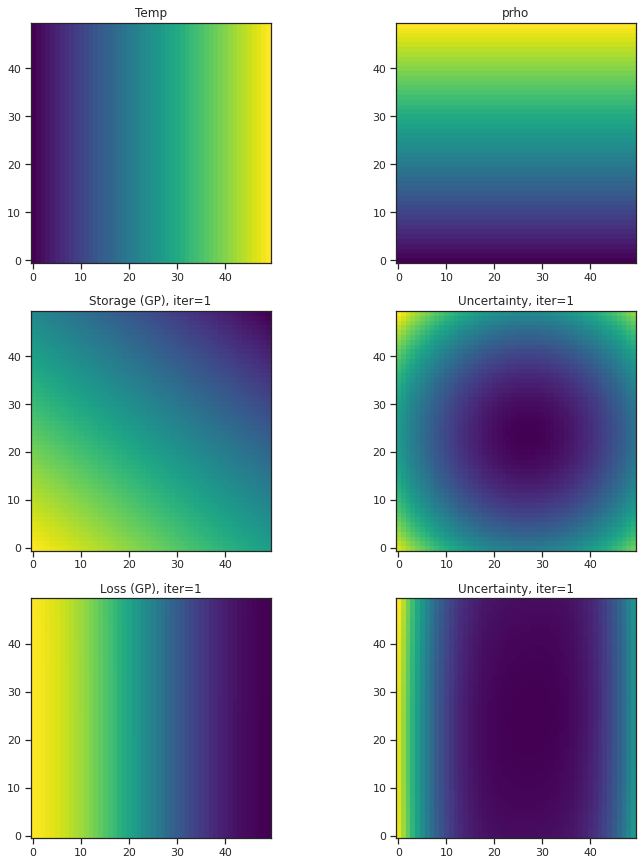

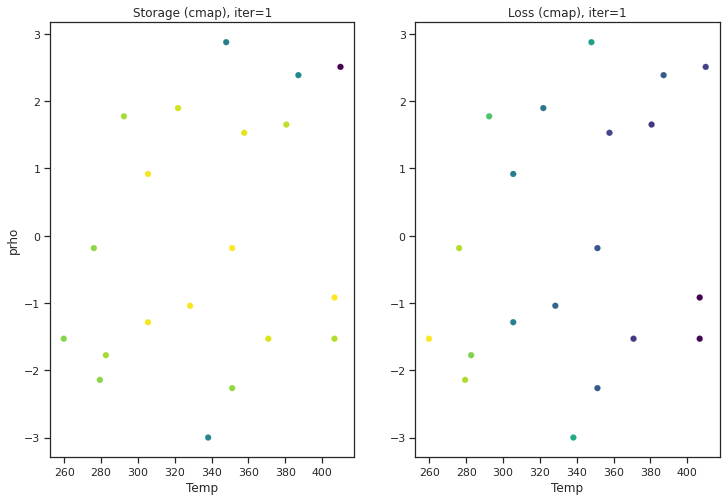

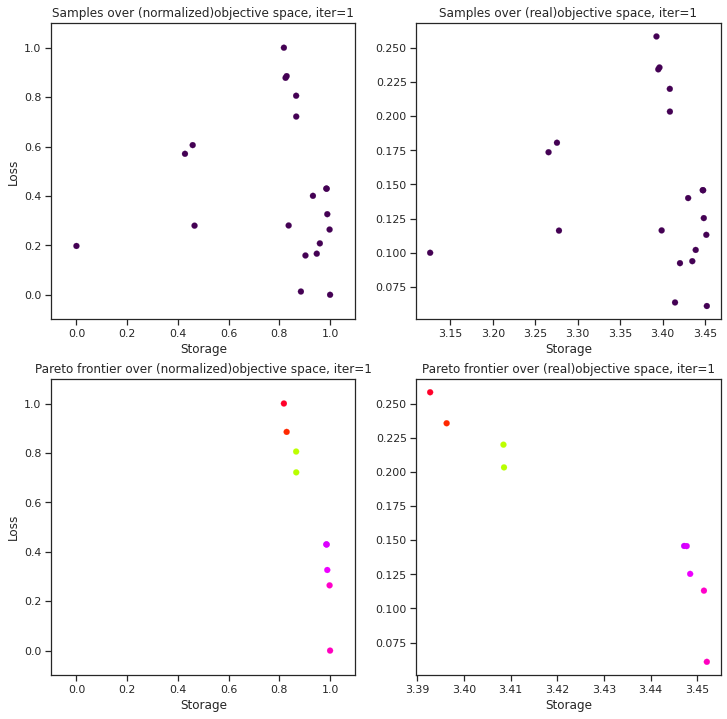

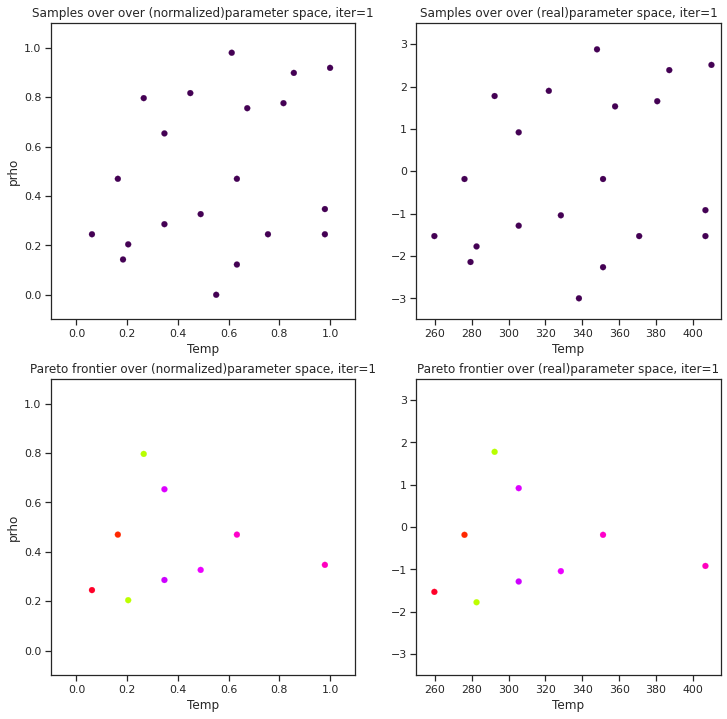

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


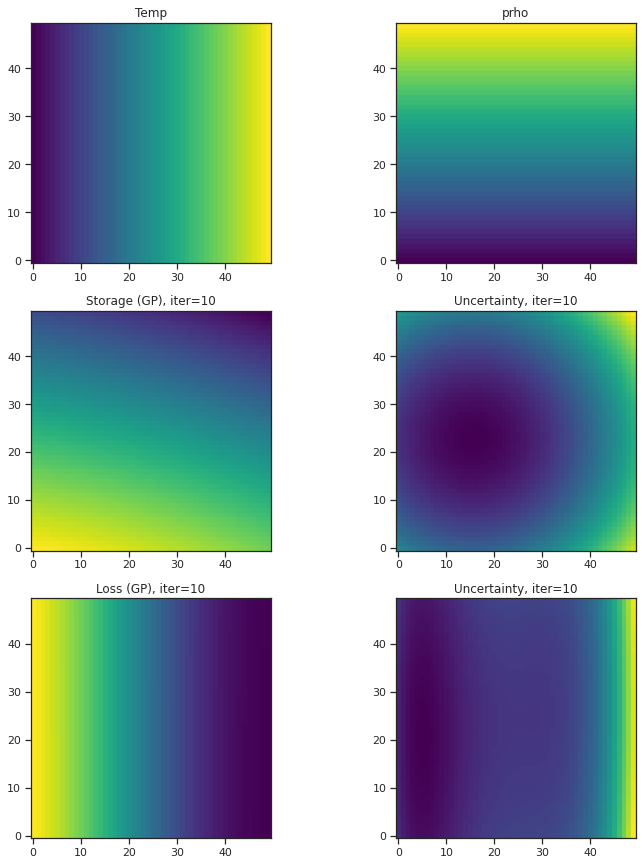

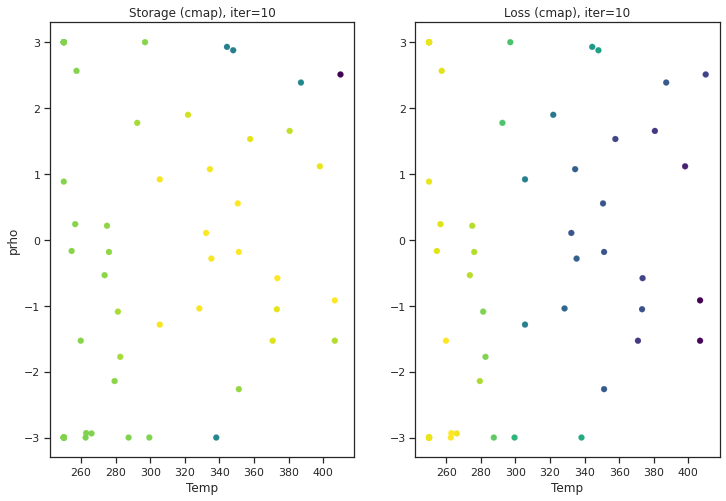

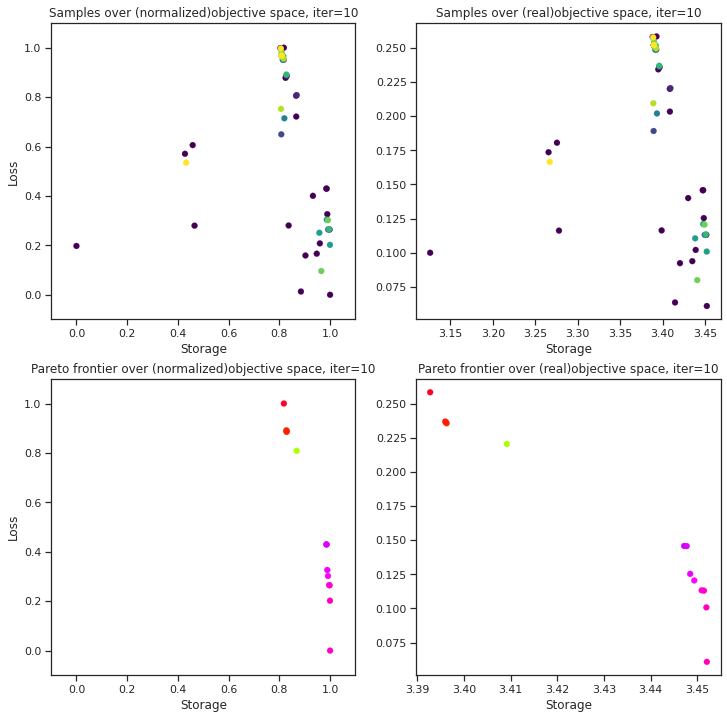

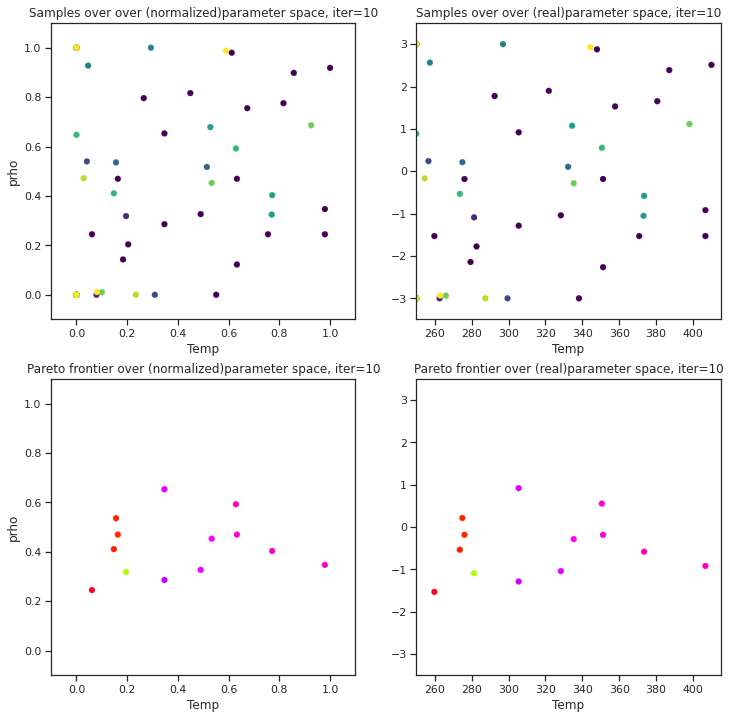

Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


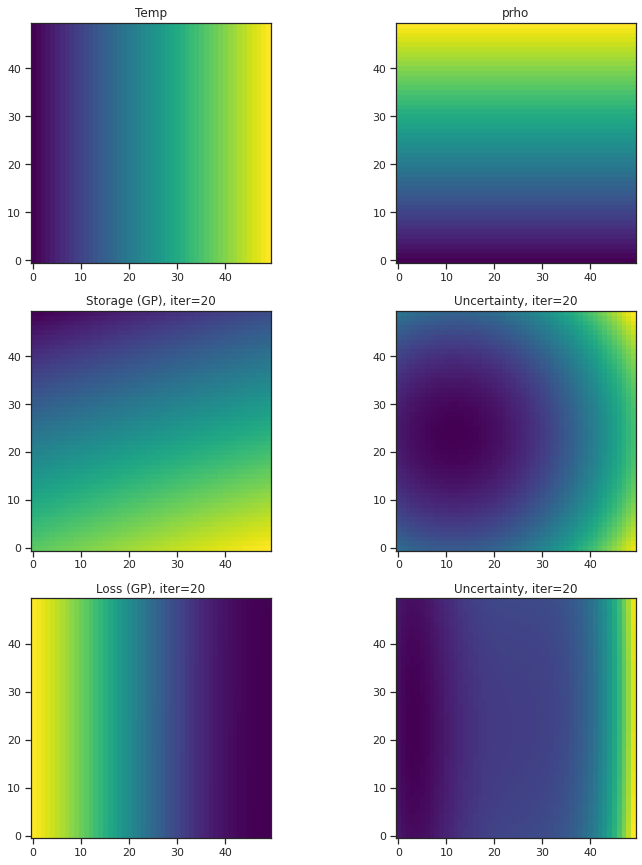

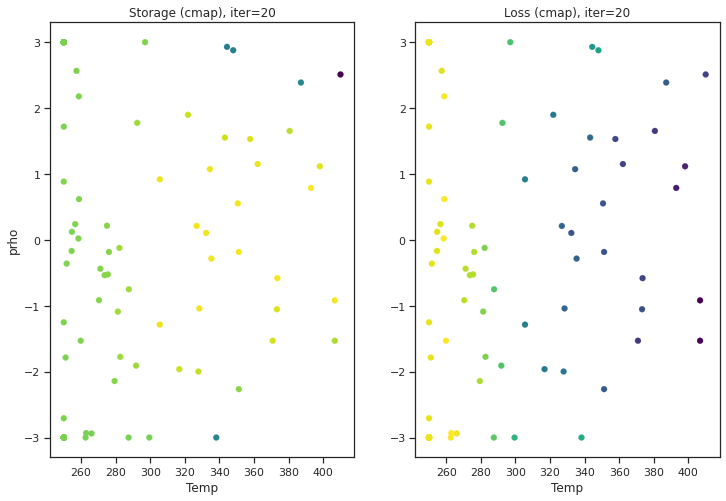

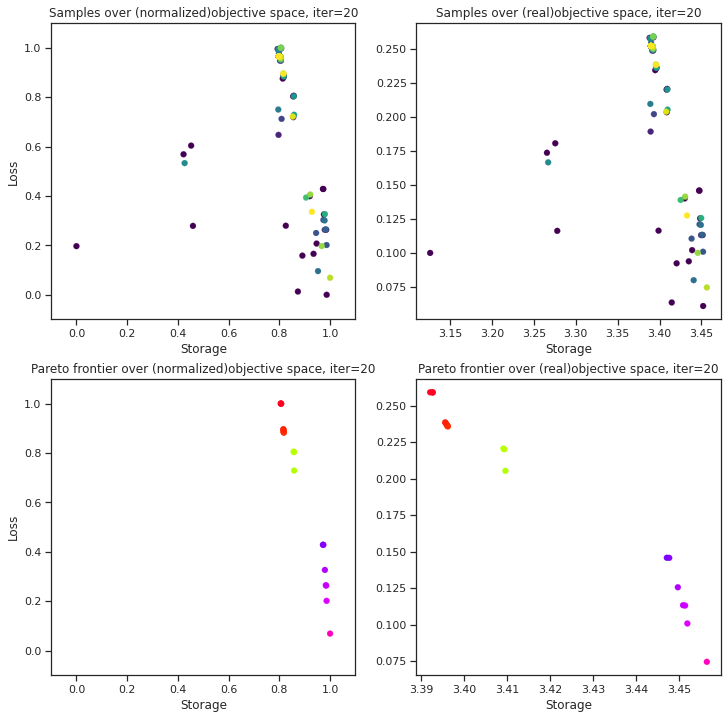

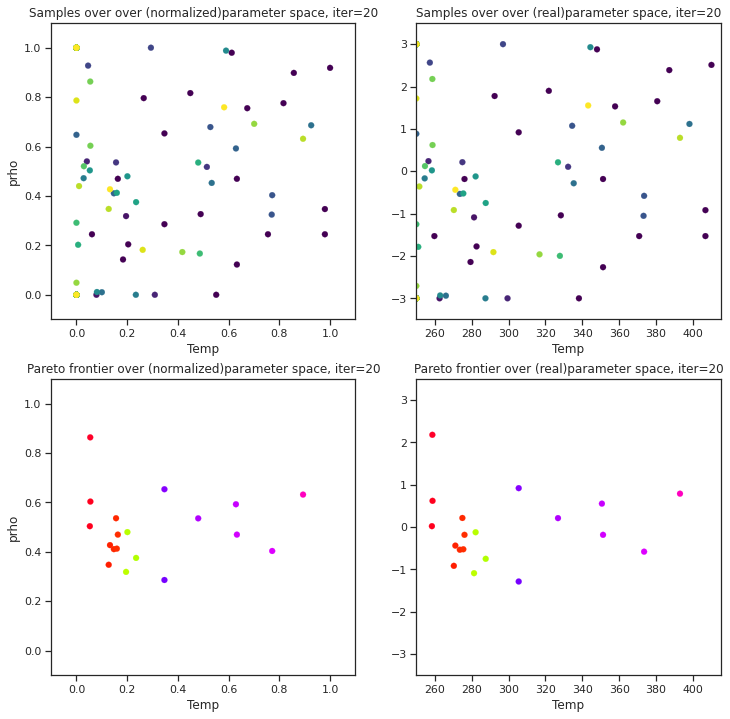

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


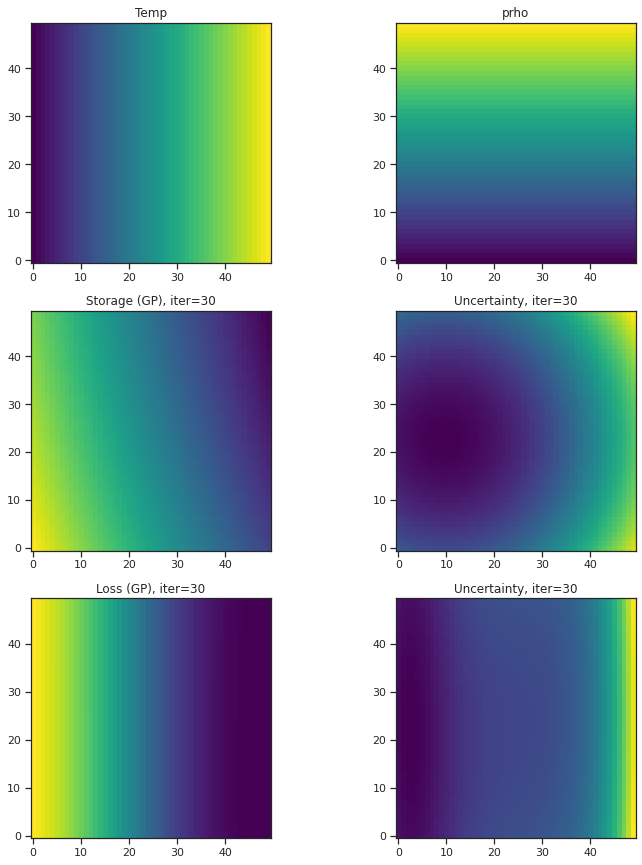

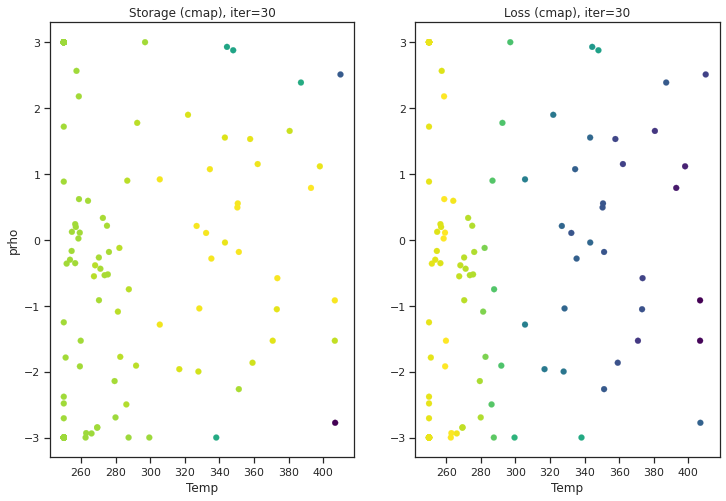

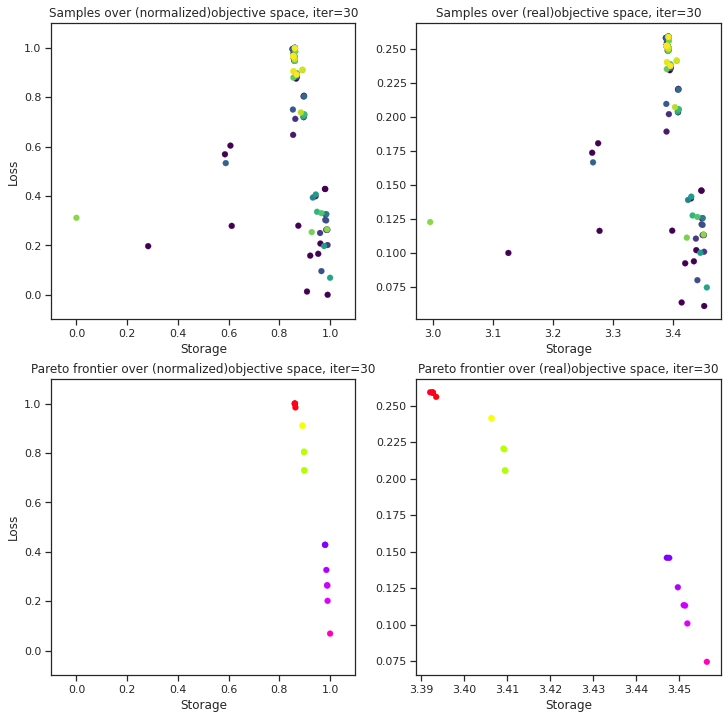

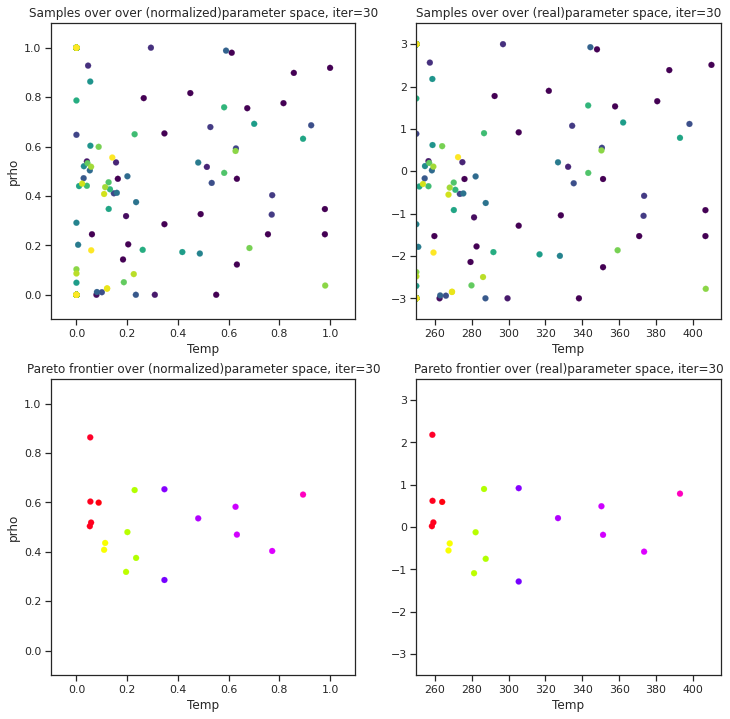

Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


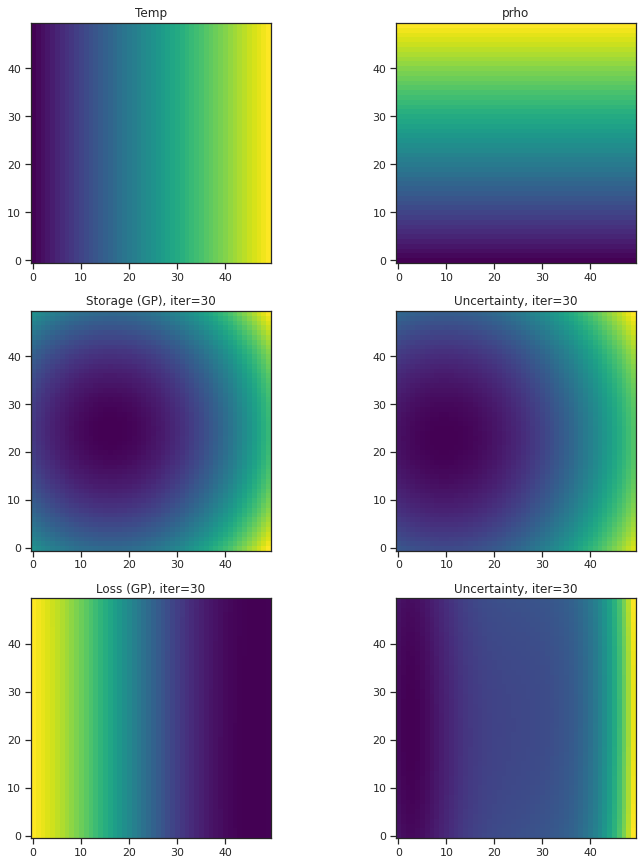

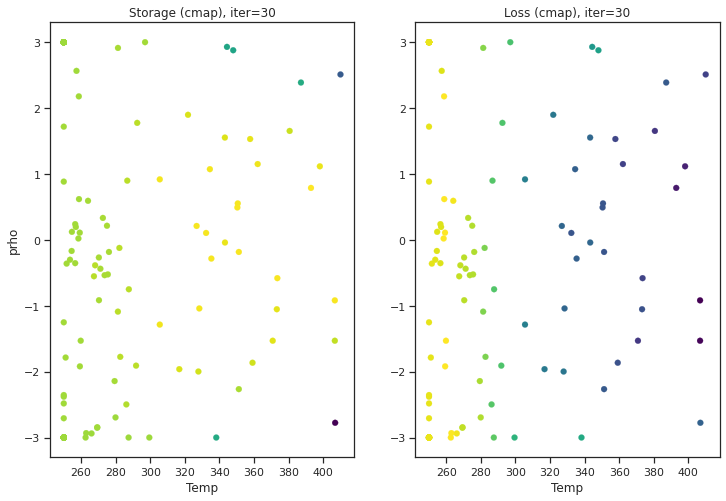

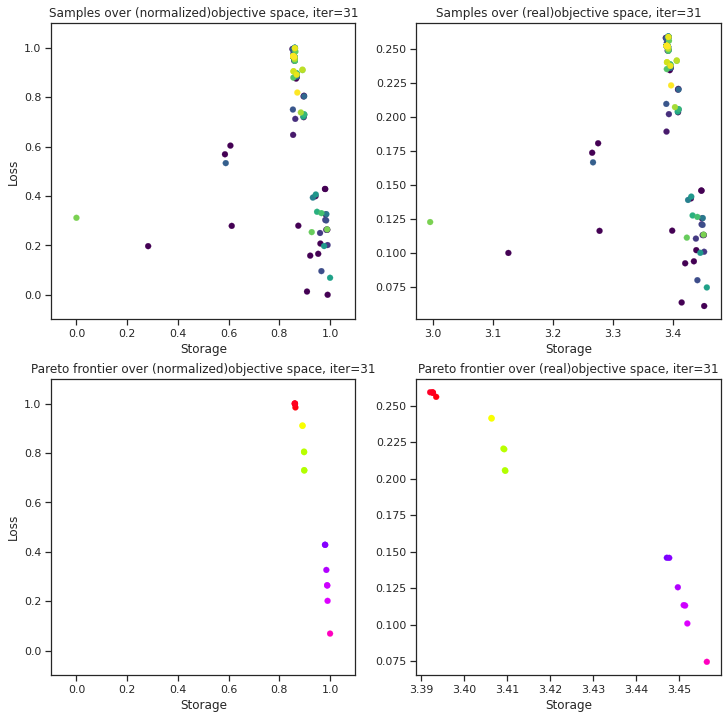

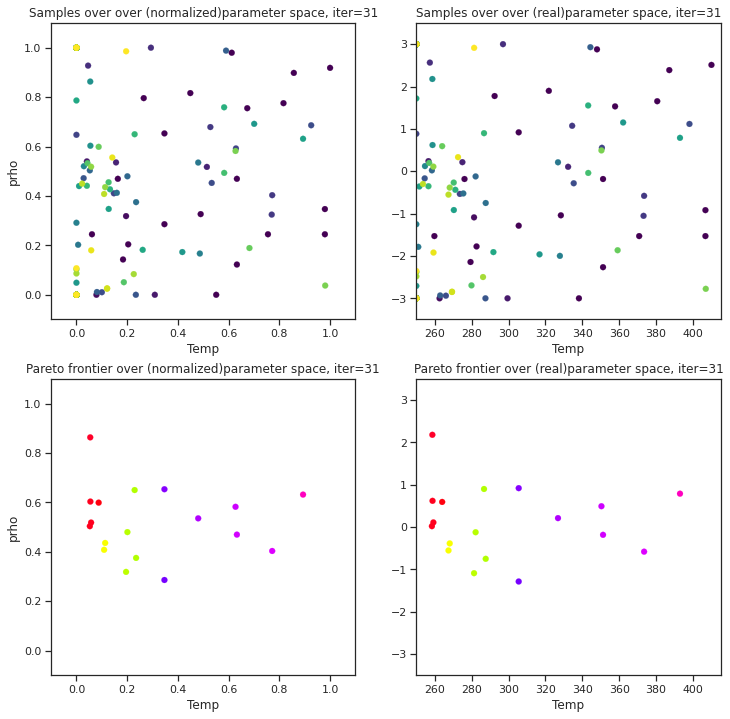

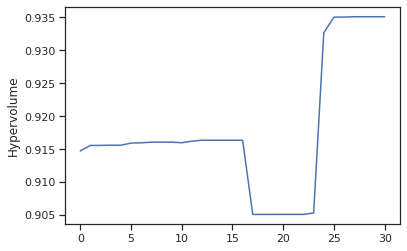

In [17]:
tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch

#Define external field
time_vec = np.linspace(0, 2, 500)
A = 3 #Fixed amplitude
E = A * np.sin(2 * np.pi * time_vec)

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParEGO' -qParEGO
acquisition = 'qParEGO'
# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['max','max']

#List of control params- Temp, prho, h, deltaG
# Choose any two control params to create the parameter space considering above the same order-
param1 = 'Temp'
param2 = 'prho'
# Choose any two objectives to do MOO (MOBO)-
obj1 = 'Storage'
obj2 = 'Loss'


#Define parameter space based on above choice of params (2D only)
num_rows =50
max_hysplot_dim =10
toggle_num_dim =10
num = 20  # Starting samples
N= 30
#N = (0.5 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
if (param1 == 'Temp') or (param2 == 'Temp'):
    #Creating domain space for T
    T = np.linspace(250, 410, num_rows)
    test_T = np.linspace(250, 410, num_rows) 
    if (param1 == 'Temp'):
        # Build X dataset
        X1 = T
        test_X1 = test_T
    if (param2 == 'Temp'):
        # Build X dataset
        X2 = T
        test_X2 = test_T

else:
    ##Fixed params
    T=300

if (param1 == 'prho') or (param2 == 'prho'):
    # Creating domain space for rho
    prho = np.linspace(-3, 3, num_rows)
    test_prho = np.linspace(-3, 3, num_rows)
    #rho = np.zeros(len(n))
    #test_rho = np.zeros(len(n))
    #for i in range(0, len(n)):
        #rho[i] = 10 ** (n[i])
        #test_rho[i] = 10 ** (n[i])  
    if (param1 == 'prho'):
        # Build X dataset
        X1 = prho
        test_X1 = test_prho
    if (param2 == 'prho'):
        # Build X dataset
        X2 = prho
        test_X2 = test_prho

else:
    ##Fixed params
    prho=2

if (param1 == 'h') or (param2 == 'h'):
    #Creating domain space for h
    h = np.linspace(3, 60, num_rows)
    test_h = np.linspace(3, 60, num_rows)  
    if (param1 == 'h'):
        # Build X dataset
        X1 = h
        test_X1 = test_h
    if (param2 == 'h'):
        # Build X dataset
        X2 = h
        test_X2 = test_h

else:
    ##Fixed params
    h=5

if (param1 == 'deltaG') or (param2 == 'deltaG'):
    #Creating domain space for deltaG
    deltaG = np.linspace(0.02, 2, num_rows)
    test_deltaG = np.linspace(0.02, 2, num_rows) 
    if (param1 == 'deltaG'):
        # Build X dataset
        X1 = deltaG
        test_X1 = test_deltaG
    if (param2 == 'deltaG'):
        # Build X dataset
        X2 = deltaG
        test_X2 = test_deltaG

else:
    deltaG=0.2

#Call function to run MOBO (physics driven)
#Order of parameters to input after choosing for control and fixed parameters - T, prho, h, delta
# example- If we consider control params as T and h- we provide arguments as 
# MOBO(X1, X2, prho, deltaG, .....) 
#The first two arguments are the control parameters in the recommended order, the next two arguments are the remaining parameters as fixed in the recommended order

#rest of input args in serial: E- array of external field process; test_X1, test_X2- grid numpy arrays for param X1, X2 (for optional posterior calculations); num_rows, N, BATCH_SIZE- explained in text sections; 
#param1, param2 - string names of parameter 1, 2; obj1, obj2 - string names of objective 1, 2; acquisition - string name as provided in text section for user choice of acquistion function method;
# problem - string array as provided in text section for user choice of maxmimization or minimization of objectives; testfunction - string name as provided in text section for user selection of test problems
# max_hysplot_dim- maximum scalar value of grid at each dimension for plotting different hysteresis loops in grids (if called), 
# max_hysplot_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree (if called)
MOBO_PZO(X1, X2, h, deltaG, E, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem, max_hysplot_dim, toggle_num_dim)



<h1> Analysis 1b

Using **qEHVI** acquistion function

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qEHVI


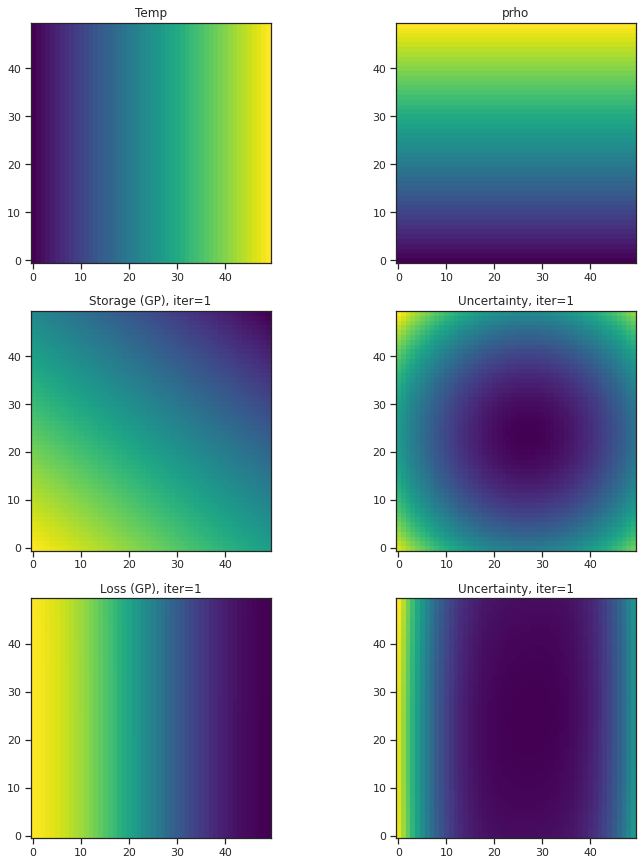

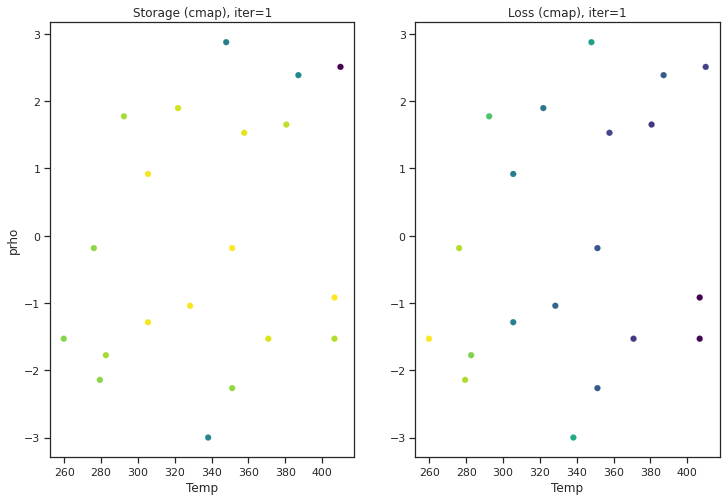

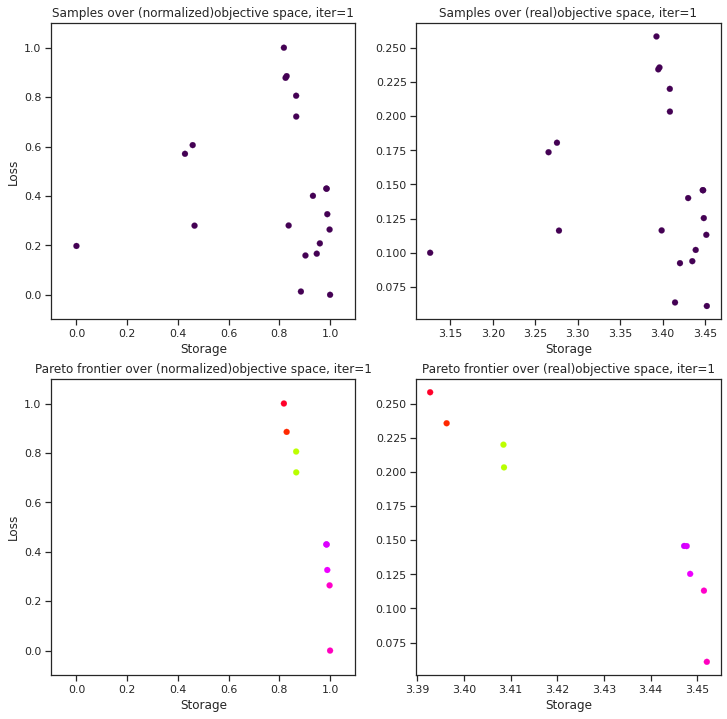

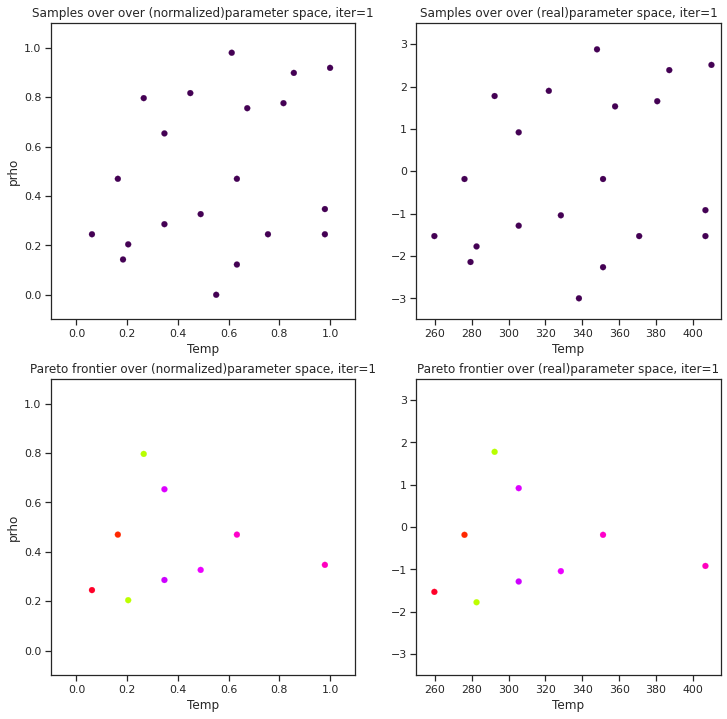

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


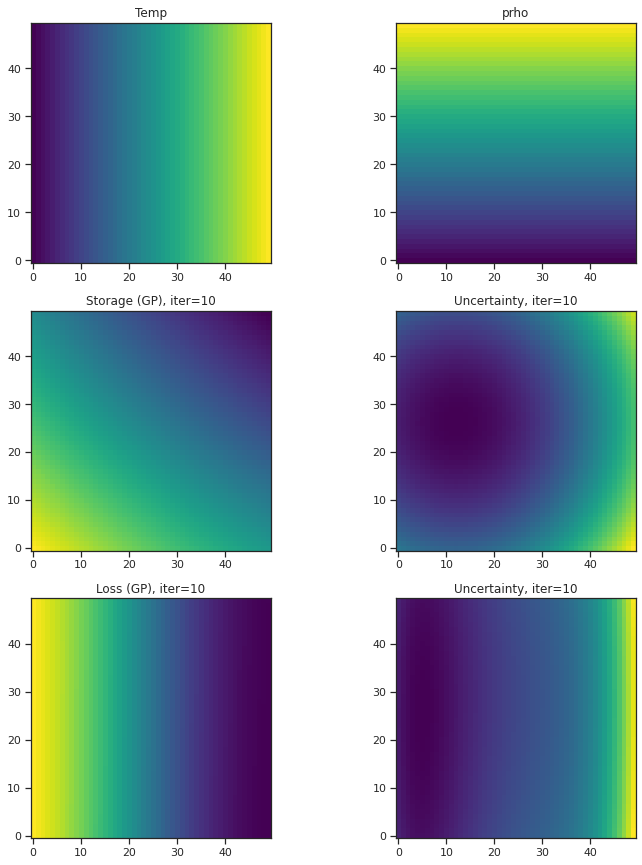

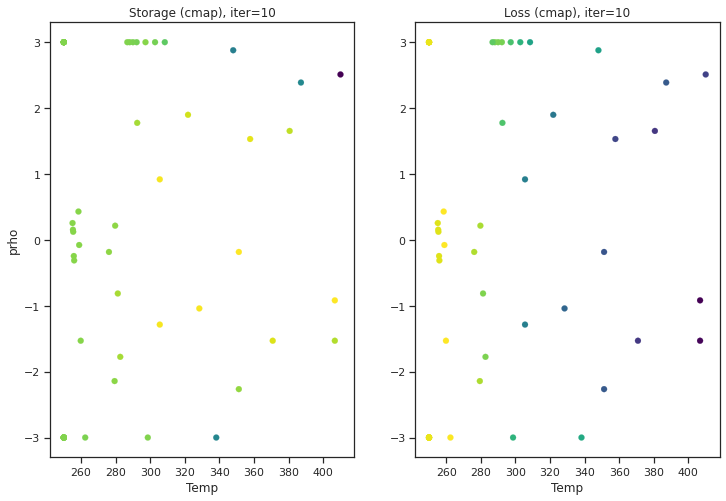

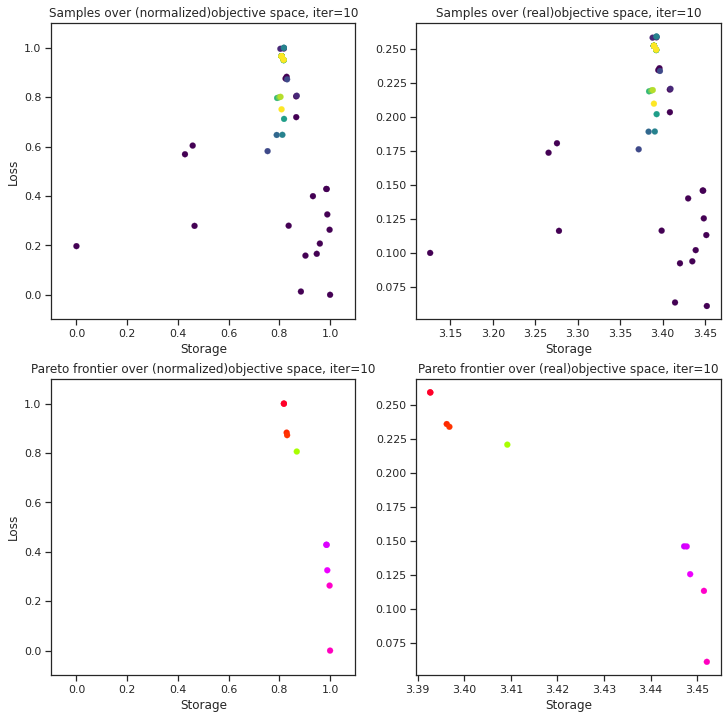

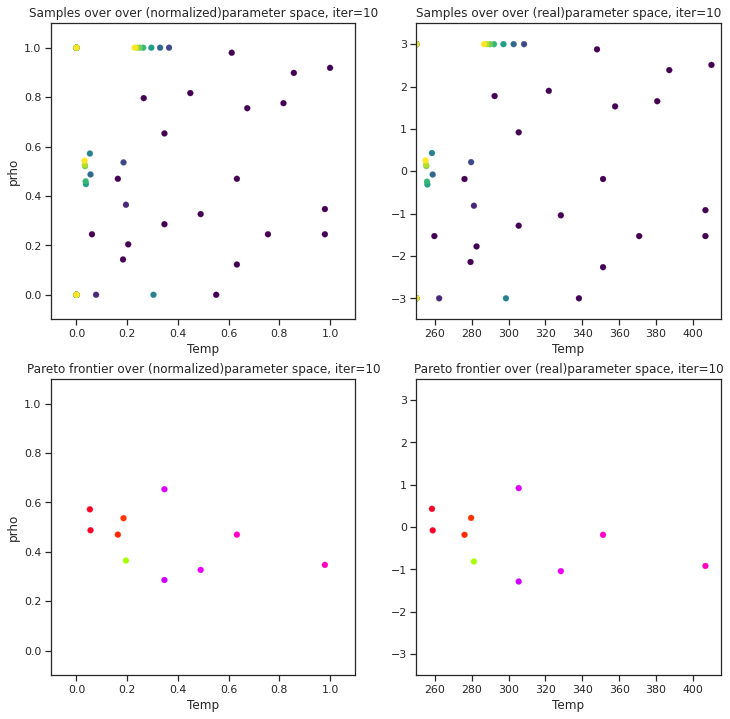

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


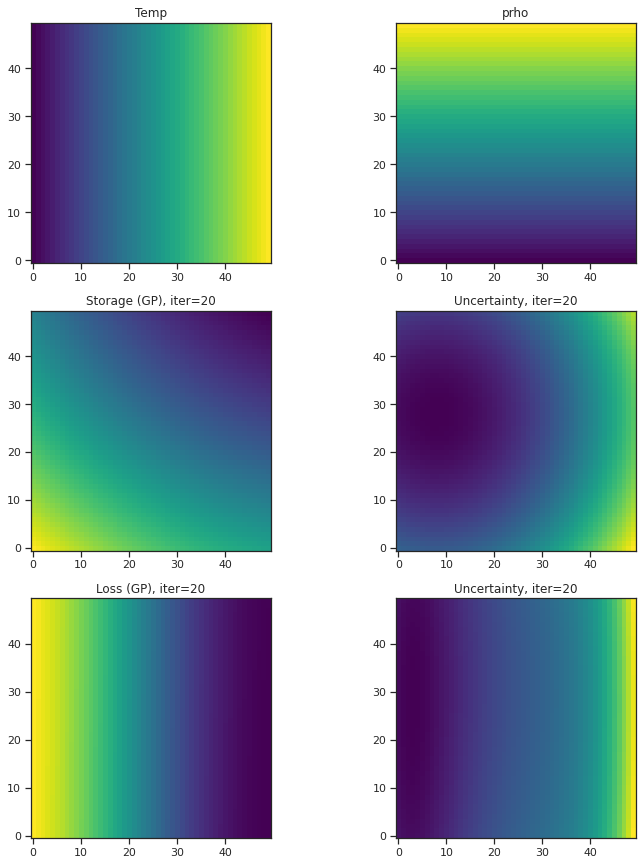

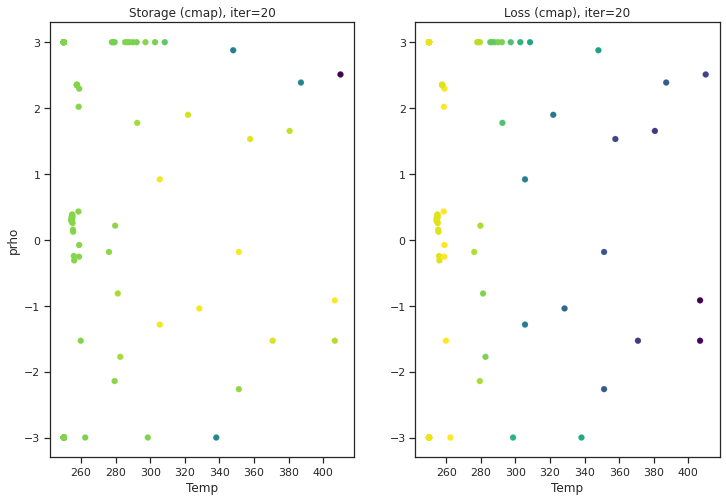

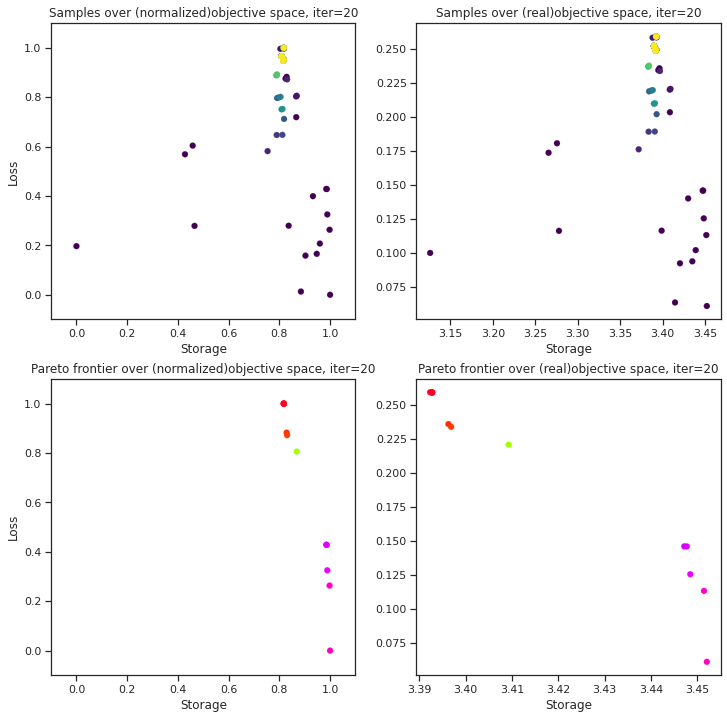

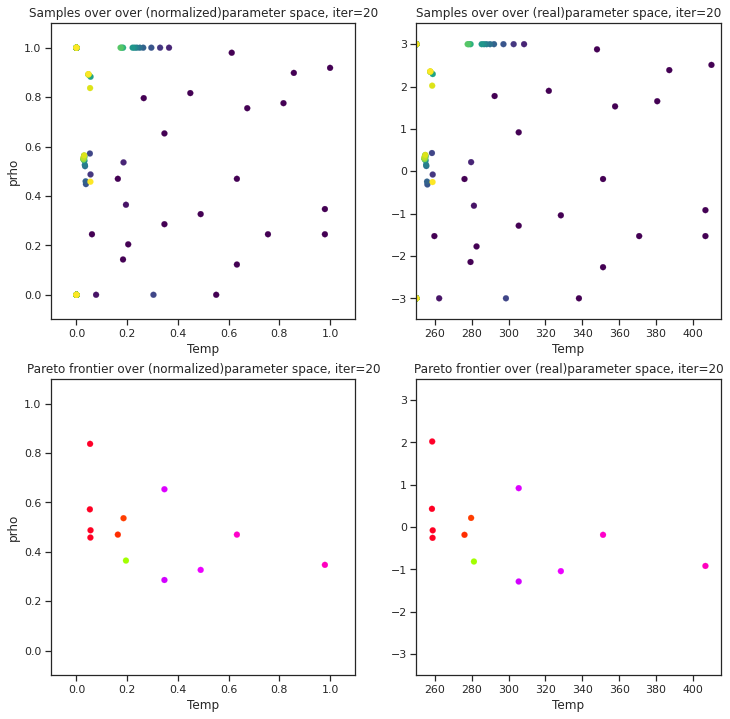

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


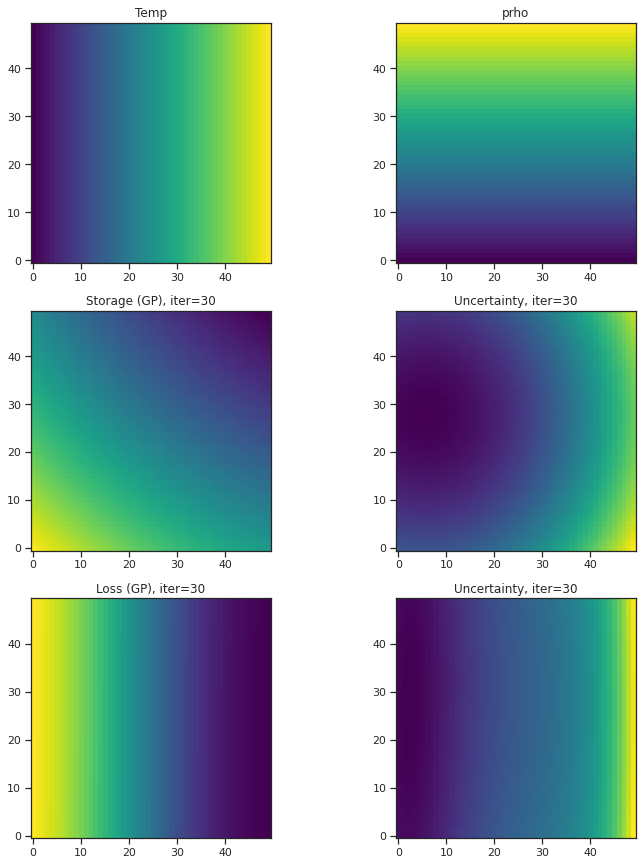

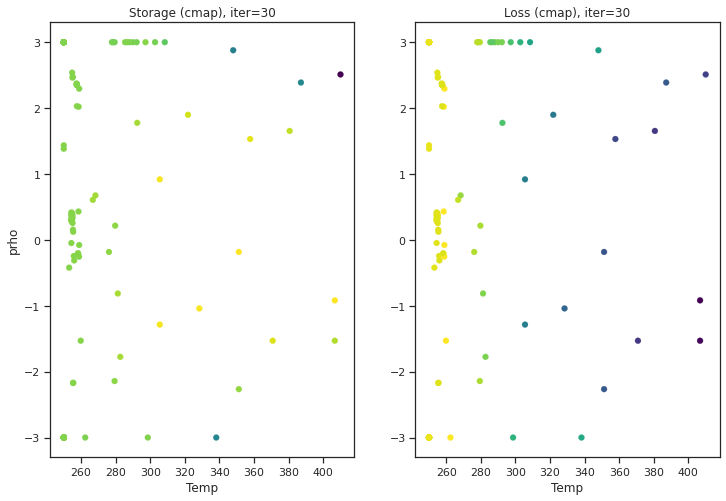

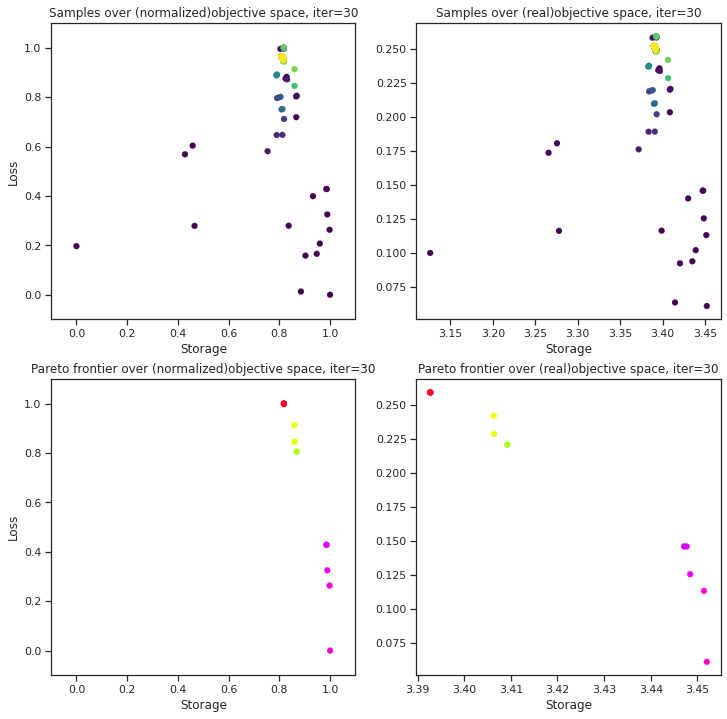

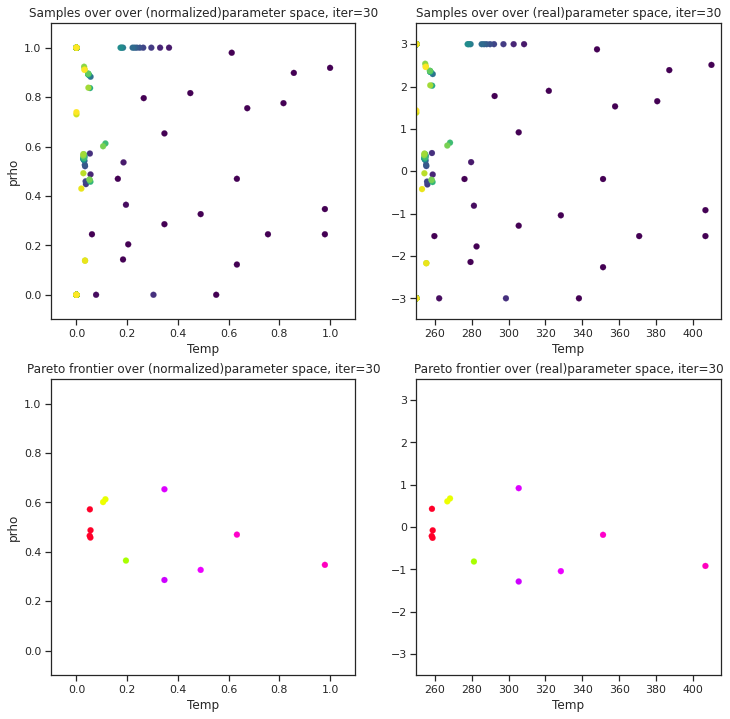

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


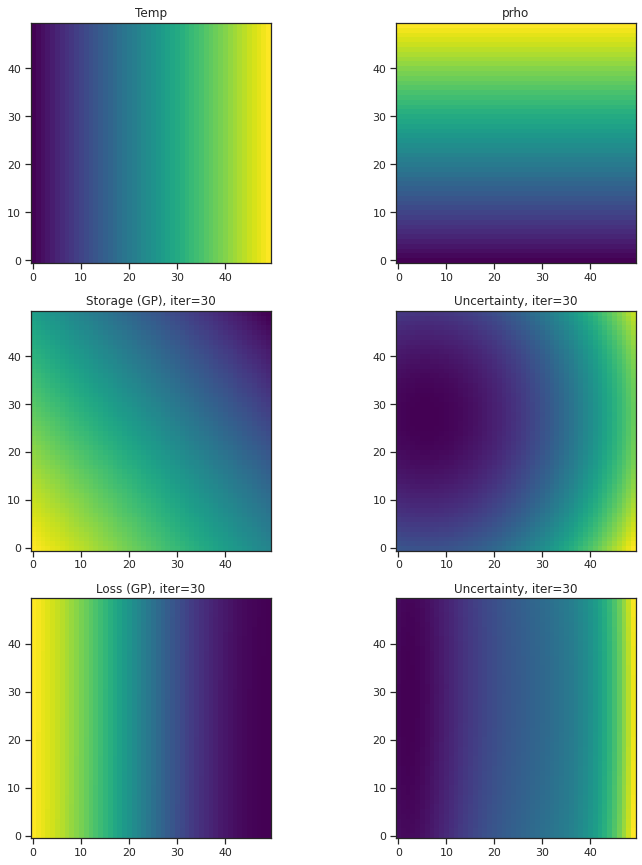

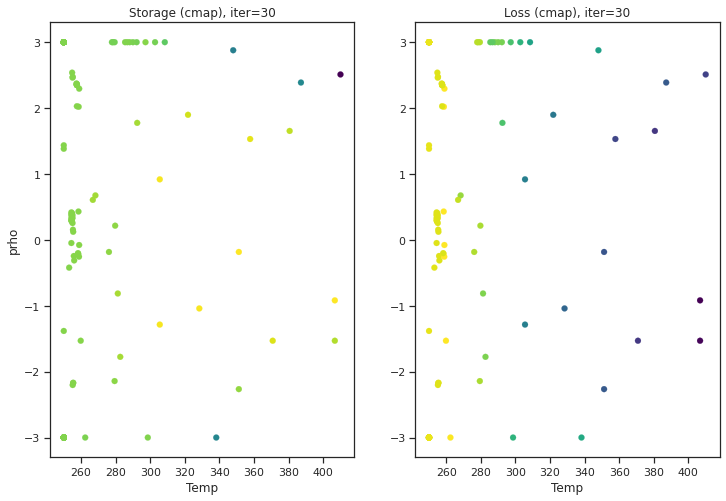

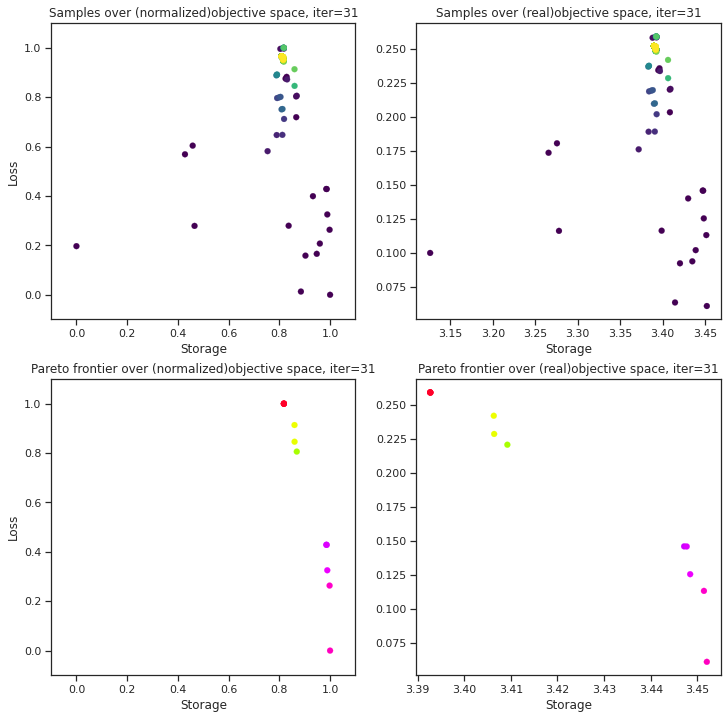

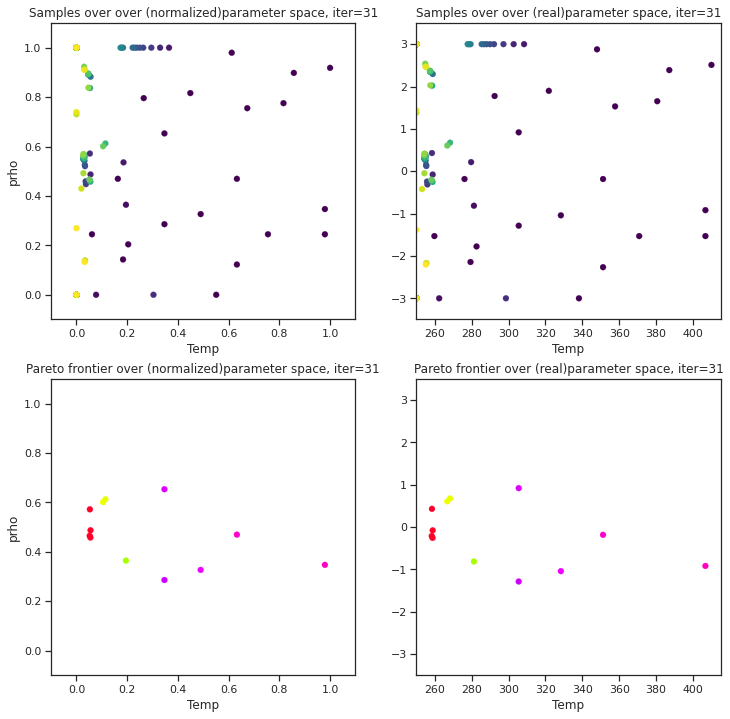

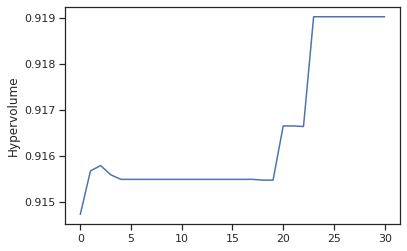

In [18]:
tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch


time_vec = np.linspace(0, 2, 500)
A = 3 #Fixed amplitude
E = A * np.sin(2 * np.pi * time_vec)

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParEGO' -qParEGO
acquisition = 'qEHVI'
# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['max','max']

#List of control params- Temp, prho, h, deltaG
# Choose any two control params to create the parameter space considering above the same order-
param1 = 'Temp'
param2 = 'prho'
# Choose any two objectives to do MOO (MOBO)-
obj1 = 'Storage'
obj2 = 'Loss'


#Define parameter space based on above choice of params (2D only)
num_rows =50
max_hysplot_dim =10
toggle_num_dim =10
num = 20  # Starting samples
N= 30
#N = (0.5 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
if (param1 == 'Temp') or (param2 == 'Temp'):
    #Creating domain space for T
    T = np.linspace(250, 410, num_rows)
    test_T = np.linspace(250, 410, num_rows) # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'Temp'):
        # Build X dataset
        X1 = T
        test_X1 = test_T
    if (param2 == 'Temp'):
        # Build X dataset
        X2 = T
        test_X2 = test_T

else:
    ##Fixed params
    T=300

if (param1 == 'prho') or (param2 == 'prho'):
    # Creating domain space for rho
    prho = np.linspace(-3, 3, num_rows)
    test_prho = np.linspace(-3, 3, num_rows)
    #rho = np.zeros(len(n))
    #test_rho = np.zeros(len(n))
    #for i in range(0, len(n)):
        #rho[i] = 10 ** (n[i])
        #test_rho[i] = 10 ** (n[i])  # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'prho'):
        # Build X dataset
        X1 = prho
        test_X1 = test_prho
    if (param2 == 'prho'):
        # Build X dataset
        X2 = prho
        test_X2 = test_prho

else:
    ##Fixed params
    prho=2

if (param1 == 'h') or (param2 == 'h'):
    #Creating domain space for h
    h = np.linspace(3, 60, num_rows)
    test_h = np.linspace(3, 60, num_rows)  # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'h'):
        # Build X dataset
        X1 = h
        test_X1 = test_h
    if (param2 == 'h'):
        # Build X dataset
        X2 = h
        test_X2 = test_h

else:
    ##Fixed params
    h=5

if (param1 == 'deltaG') or (param2 == 'deltaG'):
    #Creating domain space for deltaG
    deltaG = np.linspace(0.02, 2, num_rows)
    test_deltaG = np.linspace(0.02, 2, num_rows) # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'deltaG'):
        # Build X dataset
        X1 = deltaG
        test_X1 = test_deltaG
    if (param2 == 'deltaG'):
        # Build X dataset
        X2 = deltaG
        test_X2 = test_deltaG

else:
    deltaG=0.2

#Call function to run MOBO (physics driven)
#Order of parameters to input after choosing for control and fixed parameters - T, prho, h, delta
# example- If we consider control params as T and h- we provide arguments as 
# MOBO(X1, X2, prho, deltaG, .....) 
#The first two arguments are the control parameters in the recommended order, the next two arguments are the remaining parameters as fixed in the recommended order

#rest of input args in serial: E- array of external field process; test_X1, test_X2- grid numpy arrays for param X1, X2 (for optional posterior calculations); num_rows, N, BATCH_SIZE- explained in text sections; 
#param1, param2 - string names of parameter 1, 2; obj1, obj2 - string names of objective 1, 2; acquisition - string name as provided in text section for user choice of acquistion function method;
# problem - string array as provided in text section for user choice of maxmimization or minimization of objectives; testfunction - string name as provided in text section for user selection of test problems
# max_hysplot_dim- maximum scalar value of grid at each dimension for plotting different hysteresis loops in grid map (if called), 
# toggle_num_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree (if called)
MOBO_PZO(X1, X2, h, deltaG, E, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem, max_hysplot_dim, toggle_num_dim)



Lets check the ground truth of 1a, 1b with grid-based low sampling (7x7 grid)



Process:1; Analysis:1
Process:1; Analysis:2
Process:1; Analysis:3
Process:1; Analysis:4
Process:1; Analysis:5
Process:1; Analysis:6
Process:1; Analysis:7
Process:1; Analysis:8
Process:1; Analysis:9
Process:1; Analysis:10
Process:1; Analysis:11
Process:1; Analysis:12
Process:1; Analysis:13
Process:1; Analysis:14
Process:1; Analysis:15
Process:1; Analysis:16
Process:1; Analysis:17
Process:1; Analysis:18
Process:1; Analysis:19
Process:1; Analysis:20
Process:1; Analysis:21
Process:1; Analysis:22
Process:1; Analysis:23
Process:1; Analysis:24
Process:1; Analysis:25
Process:1; Analysis:26
Process:1; Analysis:27
Process:1; Analysis:28
Process:1; Analysis:29
Process:1; Analysis:30
Process:1; Analysis:31
Process:1; Analysis:32
Process:1; Analysis:33
Process:1; Analysis:34
Process:1; Analysis:35
Process:1; Analysis:36
Process:1; Analysis:37
Process:1; Analysis:38
Process:1; Analysis:39
Process:1; Analysis:40
Process:1; Analysis:41
Process:1; Analysis:42
Process:1; Analysis:43
Process:1; Analysis:

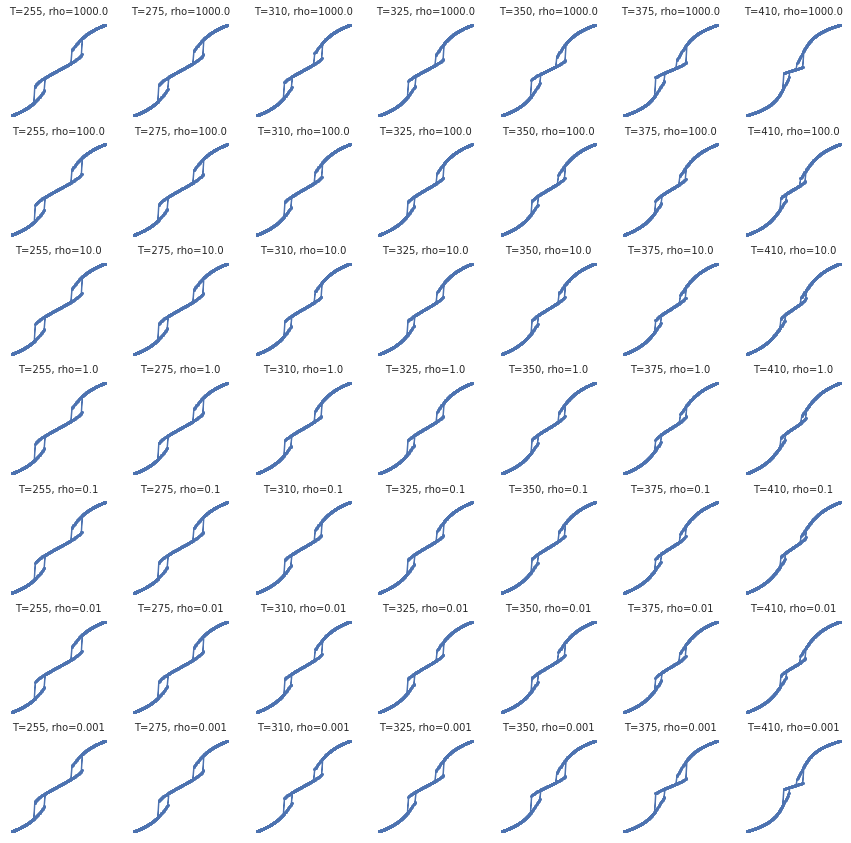

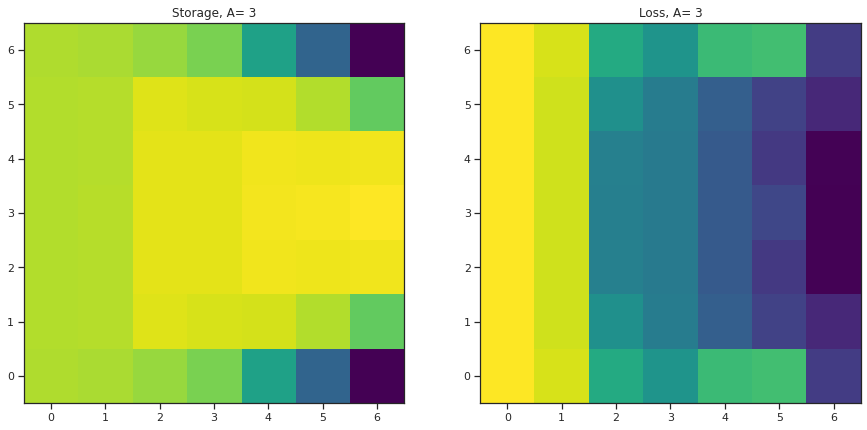

In [ ]:
time_vec = np.linspace(0, 2, 500)
A = [3] #Here user can input multiple amplitude values, so the hysteresis loop and storage plots will configure for each field process defined from each amplitude values. We considered one value =3 to plot the ground truth for MOBO results

num_rows =7
max_hysplot_dim =10 # With denser maps, the hysteresis loop grid image will get very messy and thus redundant to plot. Thus, we toogle off the full hysteresis plot if the dim>10. Instead we can plot hysteresis loop separately in the previous code segment
toggle_num_dim =5  # With denser maps, the numbers in the heatmap of phase diag will get very messy and thus redundant to plot. Thus, we toogle off if the dim>10. We can get good visualization with color intensity with denser maps


Temp=[255, 275, 310, 325, 350, 375, 410]
rho=[10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3]

Storage = np.zeros((len(Temp), len(Temp)))
StorageA =np.zeros((len(Temp)**2,len(A)))
Loss = np.zeros((len(Temp), len(Temp)))
LossA =np.zeros((len(Temp)**2,len(A)))
Temp,rho = np.meshgrid(Temp, rho)


for proc in range(0, len(A)):
    E = A[proc] * np.sin(2 * np.pi * time_vec)
    m=0
    if (num_rows<=max_hysplot_dim):
        fig1, ax1 = plt.subplots(len(Temp), len(Temp), figsize=(15,15))

    for t1, (x1, x2) in enumerate(zip(Temp, rho)):
        for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
            m=m+1
            print("Process:" +str(proc+1)+"; Analysis:"+str(m))
            #arguments of funoptimize(T, rho, h, deltaG, E)
            Pmat, objeval, objeval2, objeval3, ES, EL= funoptimize(xx1, xx2, 5, 0.2, E)
            Storage[t1, t2] = ES #Energy storage
            Loss[t1, t2] =EL #Energy Loss
            if (num_rows<=max_hysplot_dim):
            #Plot for hysteresis loops at each region for each A
            #input arguments in order: fig1, ax1, full grid numpy array of 2 control params, numpy array of field process, scalar value of control params for which the hysteresis loops are created, iteration t1(row) and t2(col), 
            # string name of control params, linewidth, markersize and fontsize
                fig1, ax1 = plot_hysteresis(fig1, ax1, Temp, rho, E, Pmat, xx1, xx2, t1, t2, 'T','rho', 1, 2, 10)


    plt.show()

    #Plot Storage and loss grid image for each A
    #input arguments in order: full grid numpy array of Storage and loss, num of rows in each dimension of grid, toggle_num_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree,
    # A[proc] is the amplitude of the field process 
    plot_Storage_Loss(Storage, Loss, num_rows, toggle_num_dim, A[proc])


<h1>Analysis 2a

num_rows =50, num = 20, N= 30

Max func evaluation- 30 (max iter)x 4(batch_size) + 20(starting samples)

Temp and $n_{\rho}$

$Temp = [260, 350]; n_{\rho} =[6, 8]$ where $\rho =10^{n_{\rho}}; h=50nm; \Delta_G =0.2$

This parameter space falls into AFE.

**Maximize Energy Storage and Loss** - Adaptive sampling to balance between high storage and loss and find the pareto frontier.

acquistion function - **qParEGO**


Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qParEGO


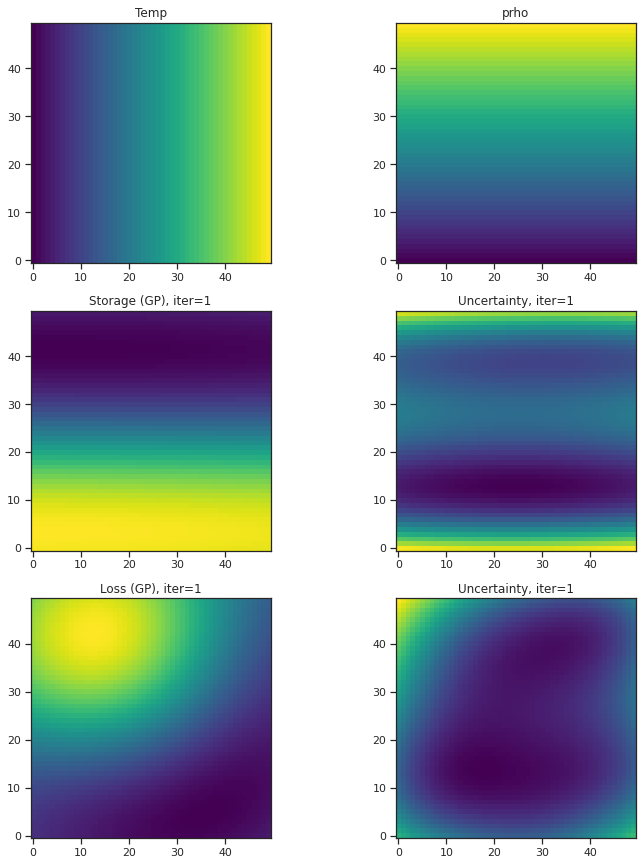

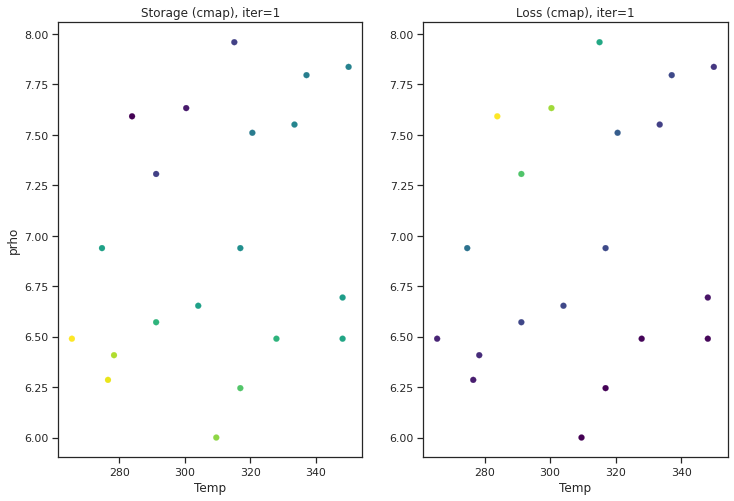

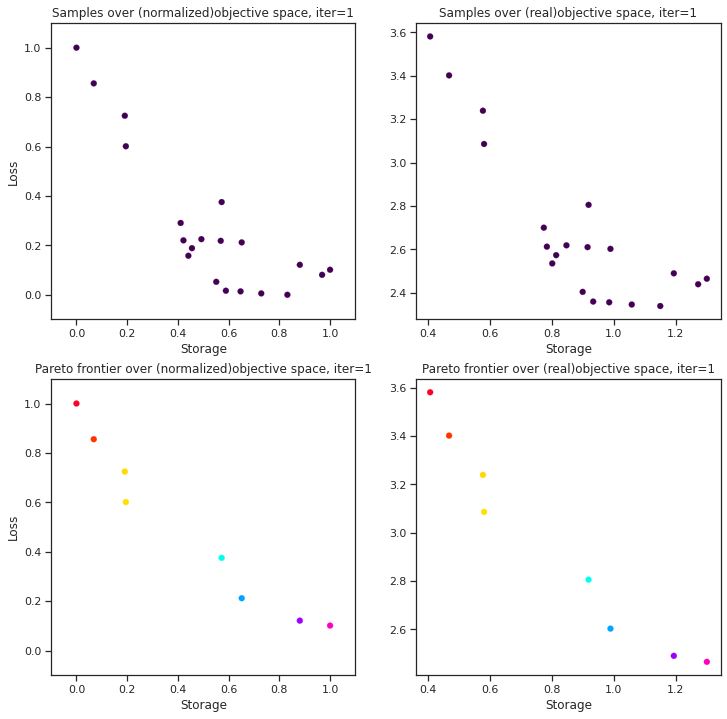

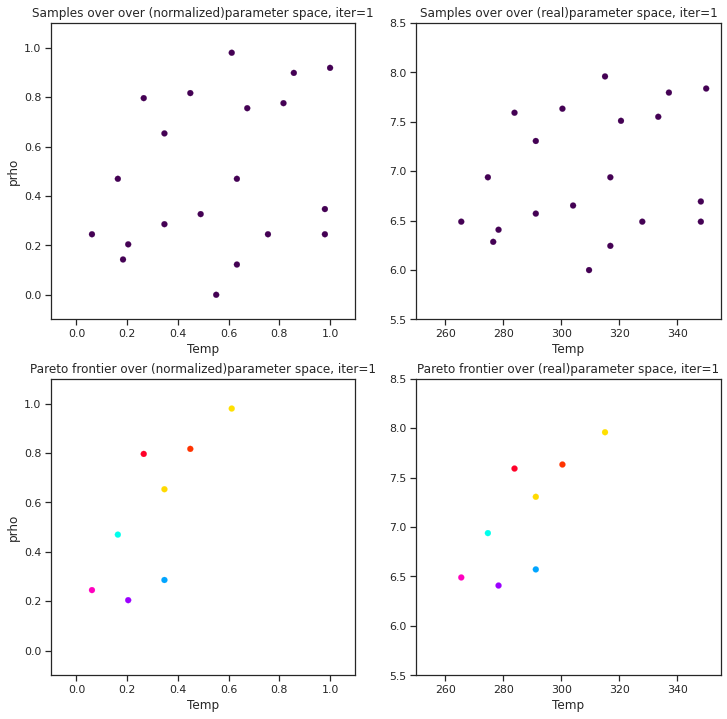

Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


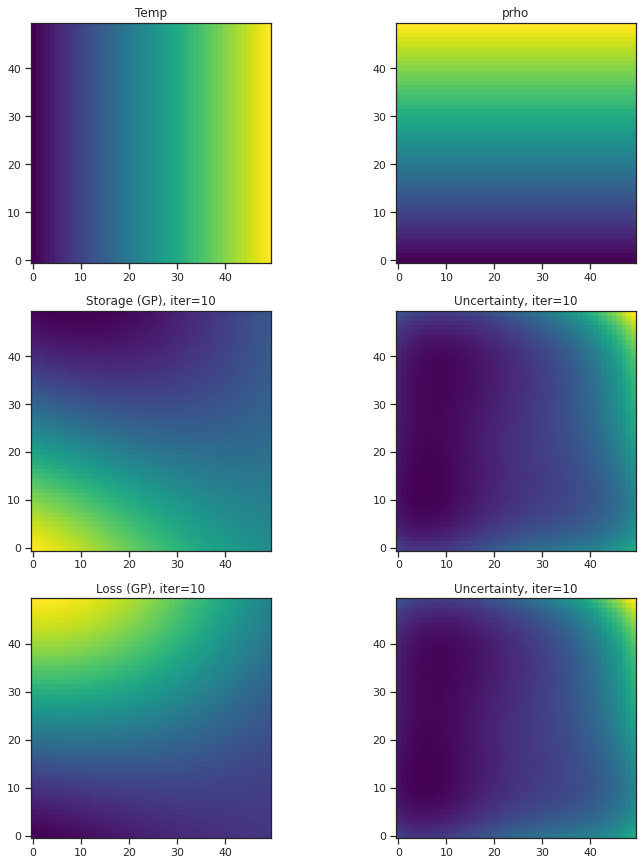

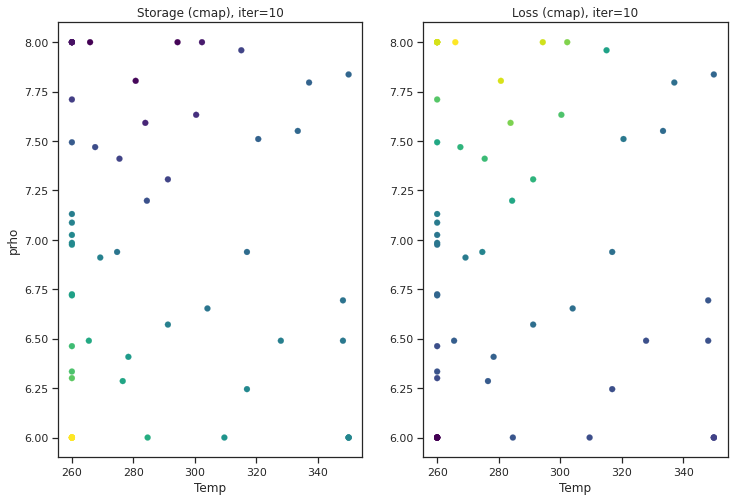

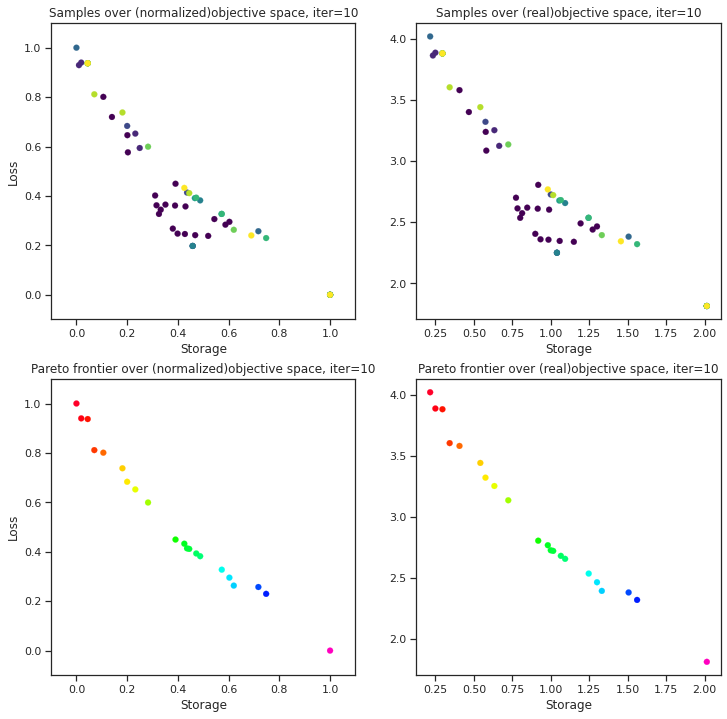

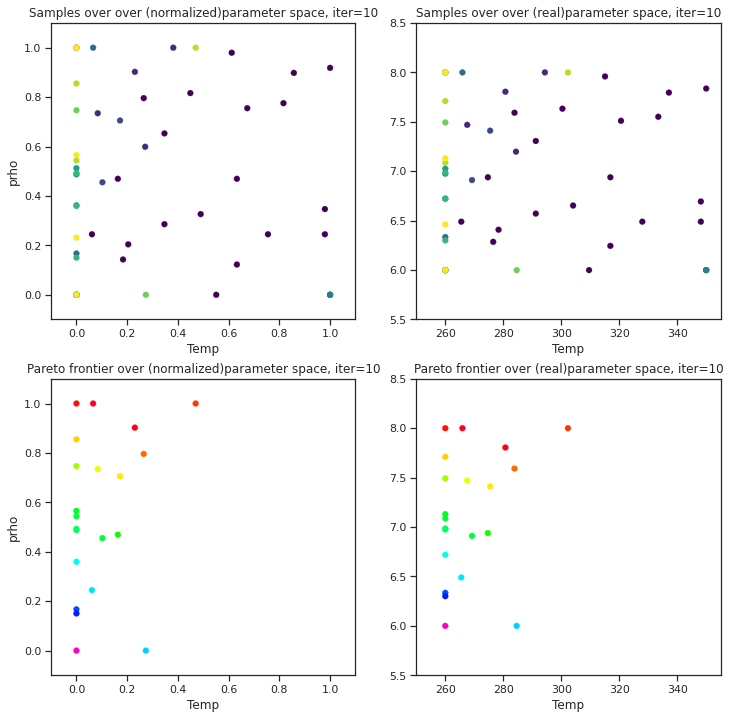

Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


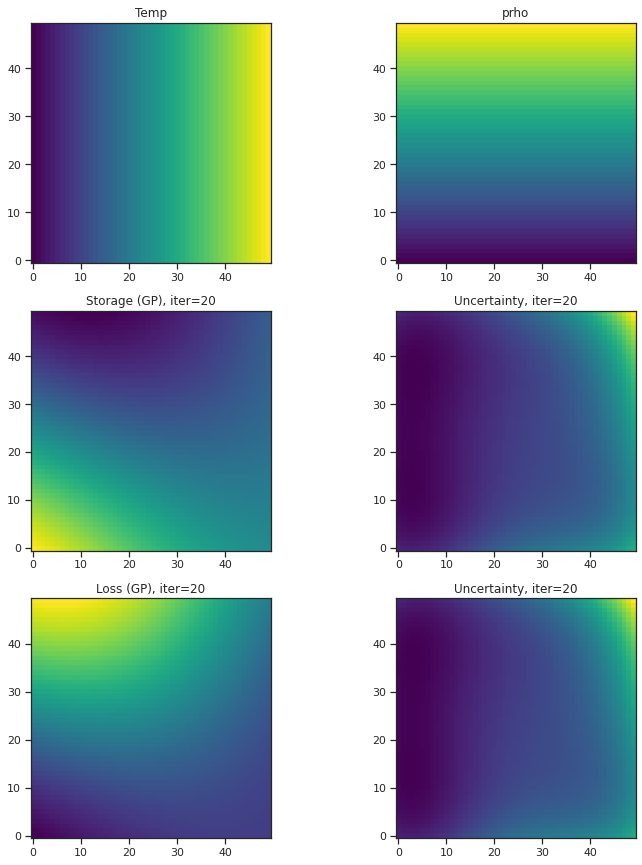

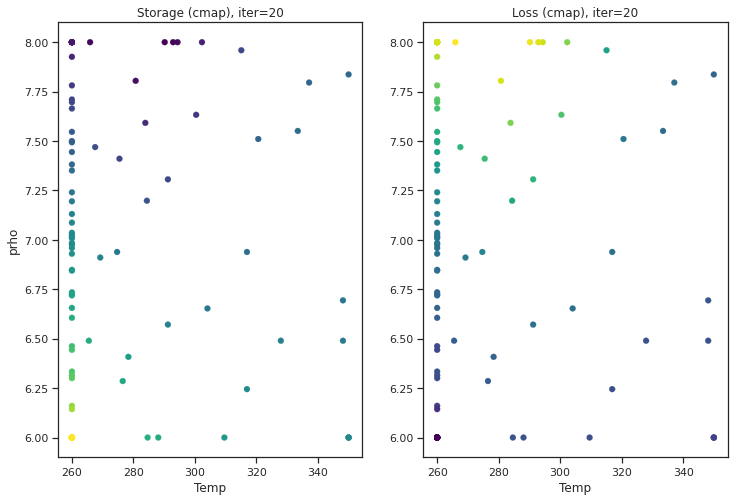

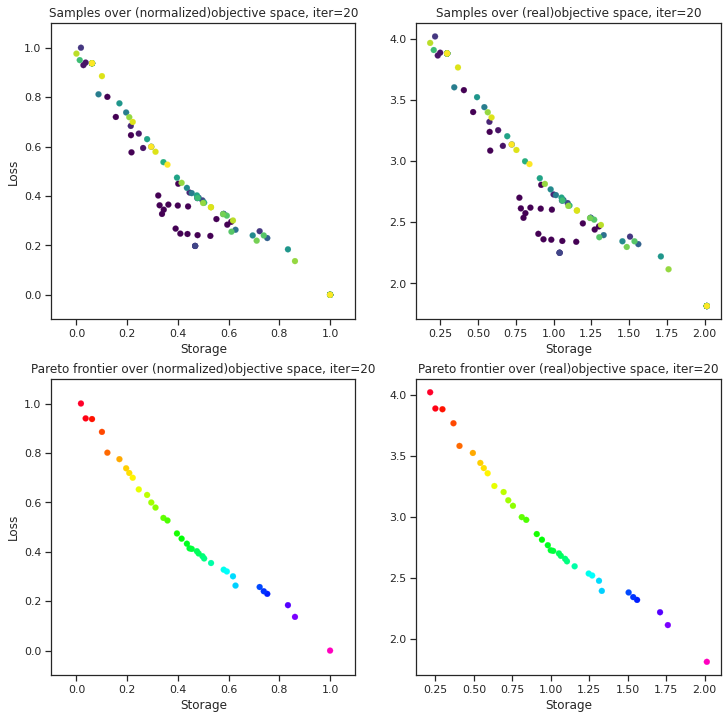

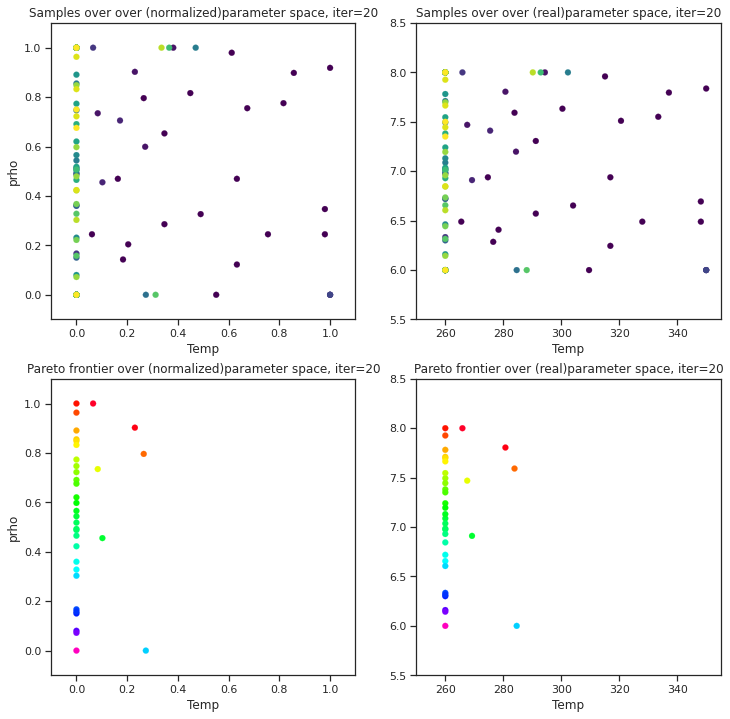

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

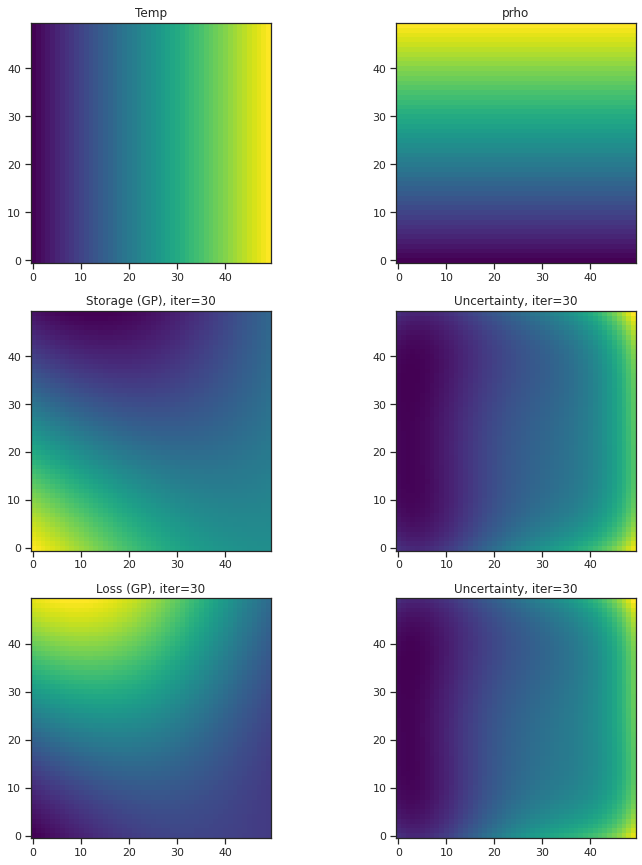

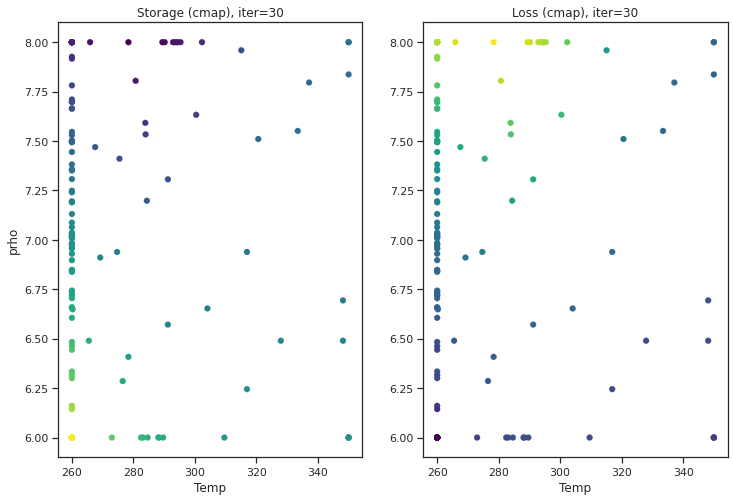

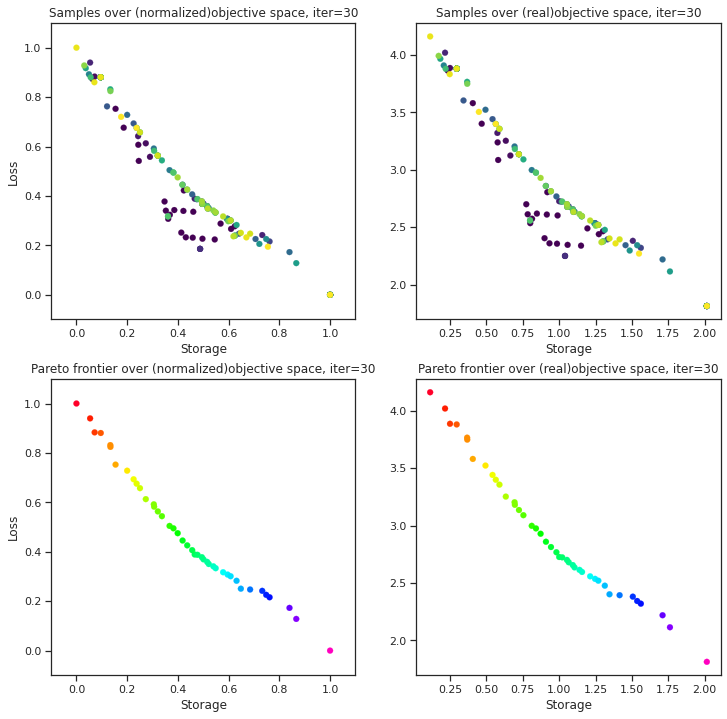

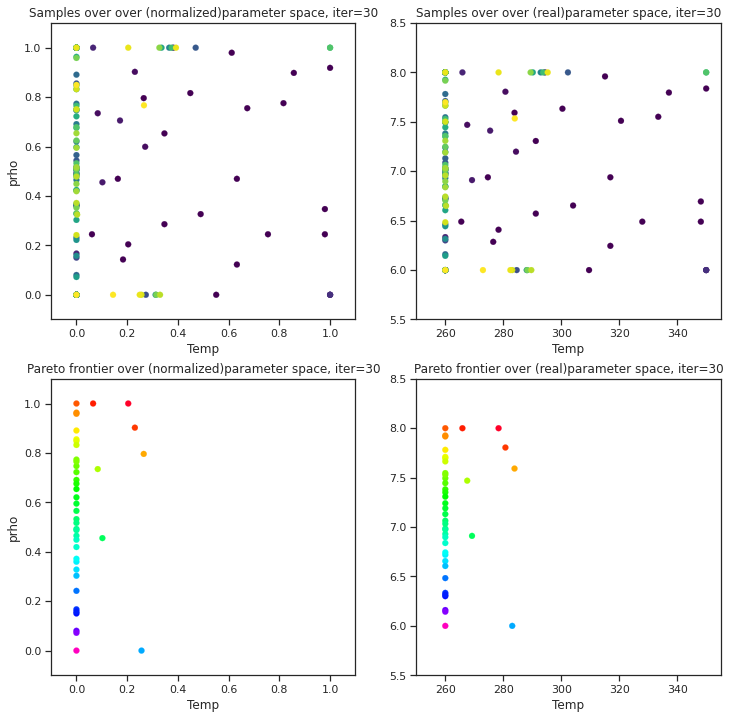

Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


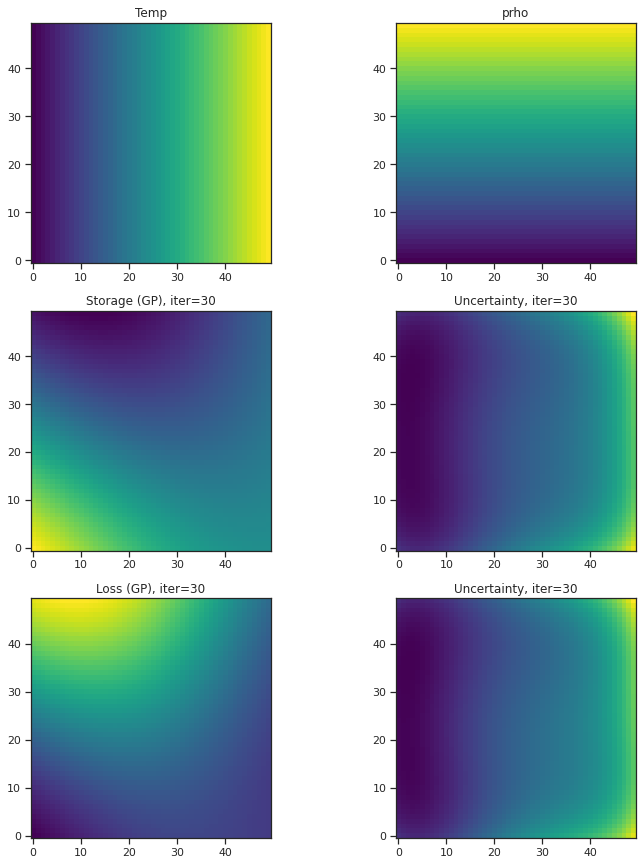

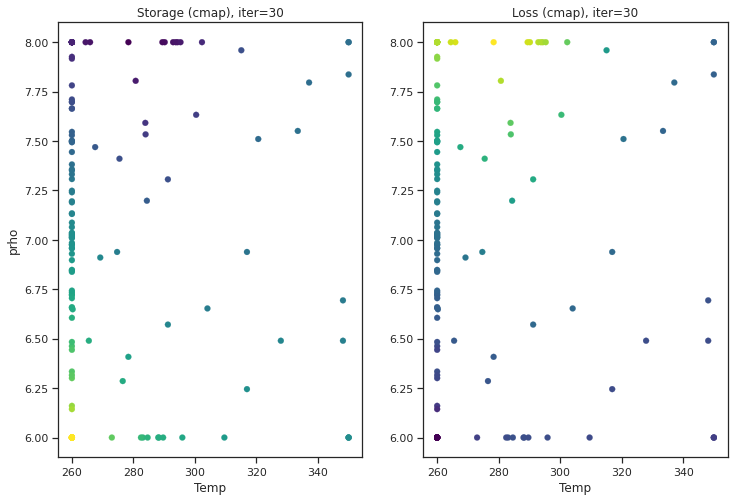

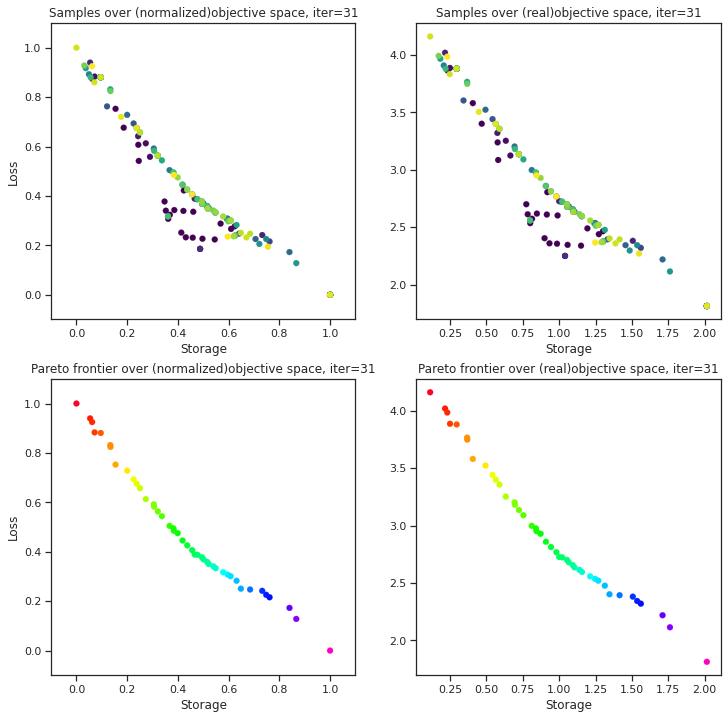

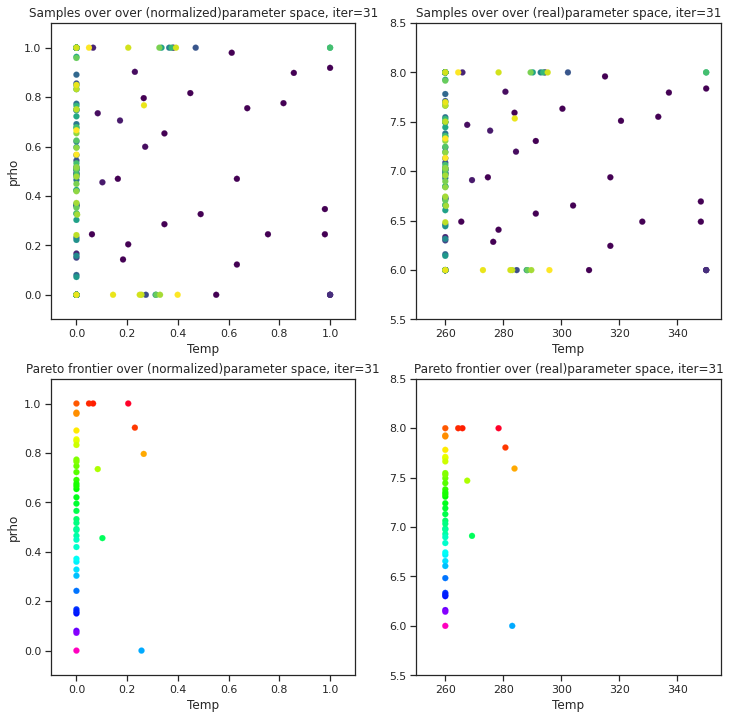

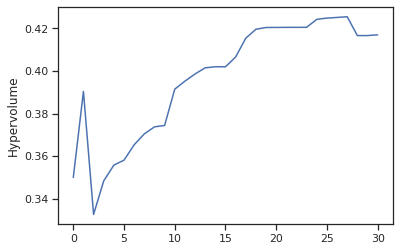

In [12]:
tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch


time_vec = np.linspace(0, 2, 500)
A = 3 #Fixed amplitude
E = A * np.sin(2 * np.pi * time_vec)

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParEGO' -qParEGO
acquisition = 'qParEGO'
# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['max','max']

#List of control params- Temp, prho, h, deltaG
# Choose any two control params to create the parameter space considering above the same order-
param1 = 'Temp'
param2 = 'prho'
# Choose any two objectives to do MOO (MOBO)-
obj1 = 'Storage'
obj2 = 'Loss'


#Define parameter space based on above choice of params (2D only)
num_rows =50
max_hysplot_dim =10
toggle_num_dim =10
num = 20  # Starting samples
N= 30
#N = (0.5 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
if (param1 == 'Temp') or (param2 == 'Temp'):
    #Creating domain space for T
    T = np.linspace(260, 350, num_rows)
    test_T = np.linspace(260, 350, num_rows) # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'Temp'):
        # Build X dataset
        X1 = T
        test_X1 = test_T
    if (param2 == 'Temp'):
        # Build X dataset
        X2 = T
        test_X2 = test_T

else:
    ##Fixed params
    T=300

if (param1 == 'prho') or (param2 == 'prho'):
    # Creating domain space for rho
    prho = np.linspace(6, 8, num_rows)
    test_prho = np.linspace(6, 8, num_rows)
    #rho = np.zeros(len(n))
    #test_rho = np.zeros(len(n))
    #for i in range(0, len(n)):
        #rho[i] = 10 ** (n[i])
        #test_rho[i] = 10 ** (n[i])  # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'prho'):
        # Build X dataset
        X1 = prho
        test_X1 = test_prho
    if (param2 == 'prho'):
        # Build X dataset
        X2 = prho
        test_X2 = test_prho

else:
    ##Fixed params
    prho=2

if (param1 == 'h') or (param2 == 'h'):
    #Creating domain space for h
    h = np.linspace(3, 60, num_rows)
    test_h = np.linspace(3, 60, num_rows)  # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'h'):
        # Build X dataset
        X1 = h
        test_X1 = test_h
    if (param2 == 'h'):
        # Build X dataset
        X2 = h
        test_X2 = test_h

else:
    ##Fixed params
    h=50

if (param1 == 'deltaG') or (param2 == 'deltaG'):
    #Creating domain space for deltaG
    deltaG = np.linspace(0.02, 2, num_rows)
    test_deltaG = np.linspace(0.02, 2, num_rows) # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'deltaG'):
        # Build X dataset
        X1 = deltaG
        test_X1 = test_deltaG
    if (param2 == 'deltaG'):
        # Build X dataset
        X2 = deltaG
        test_X2 = test_deltaG

else:
    deltaG=0.2

#Call function to run MOBO (physics driven)
#Order of parameters to input after choosing for control and fixed parameters - T, prho, h, delta
# example- If we consider control params as T and h- we provide arguments as 
# MOBO(X1, X2, prho, deltaG, .....) 
#The first two arguments are the control parameters in the recommended order, the next two arguments are the remaining parameters as fixed in the recommended order

#rest of input args in serial: E- array of external field process; test_X1, test_X2- grid numpy arrays for param X1, X2 (for optional posterior calculations); num_rows, N, BATCH_SIZE- explained in text sections; 
#param1, param2 - string names of parameter 1, 2; obj1, obj2 - string names of objective 1, 2; acquisition - string name as provided in text section for user choice of acquistion function method;
# problem - string array as provided in text section for user choice of maxmimization or minimization of objectives; testfunction - string name as provided in text section for user selection of test problems
# max_hysplot_dim- maximum scalar value of grid at each dimension for plotting different hysteresis loops in grids (if called), 
# max_hysplot_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree (if called)
MOBO_PZO(X1, X2, h, deltaG, E, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem, max_hysplot_dim, toggle_num_dim)




<h1> Analysis 2b

Using **qEHVI** acquistion function

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qEHVI


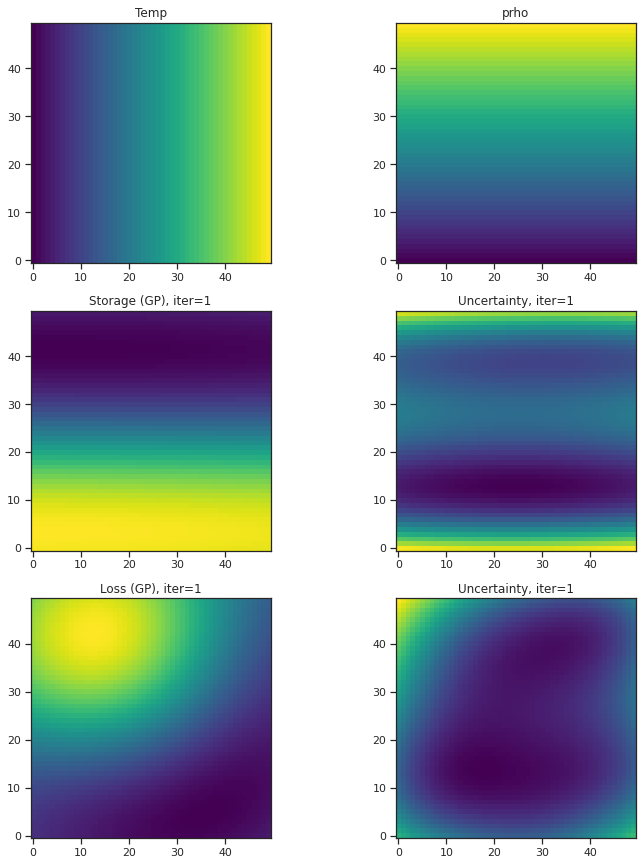

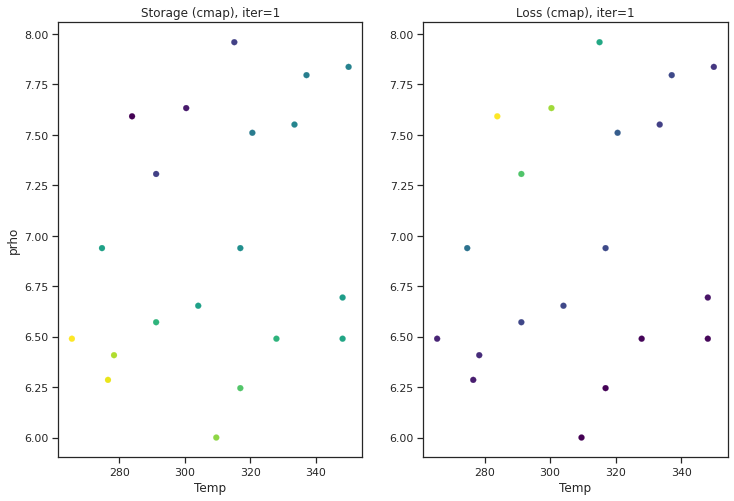

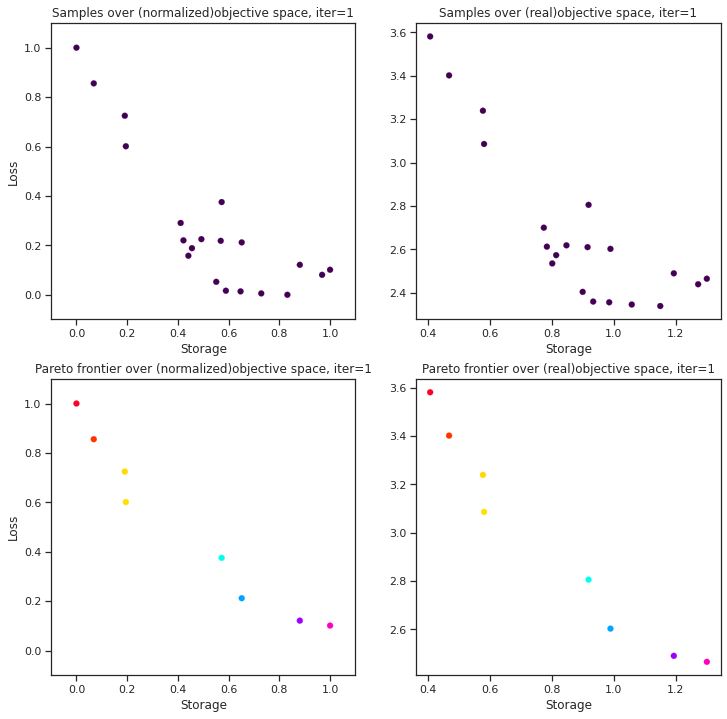

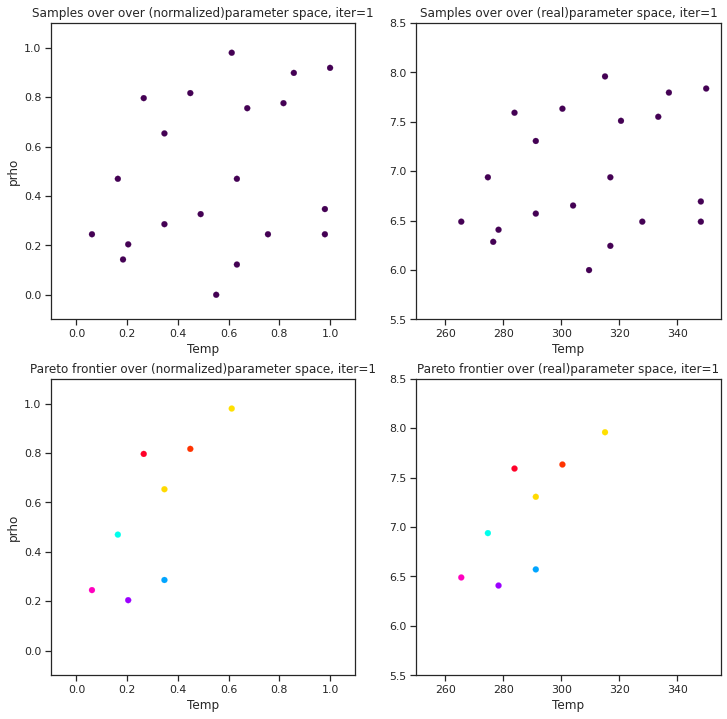

Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


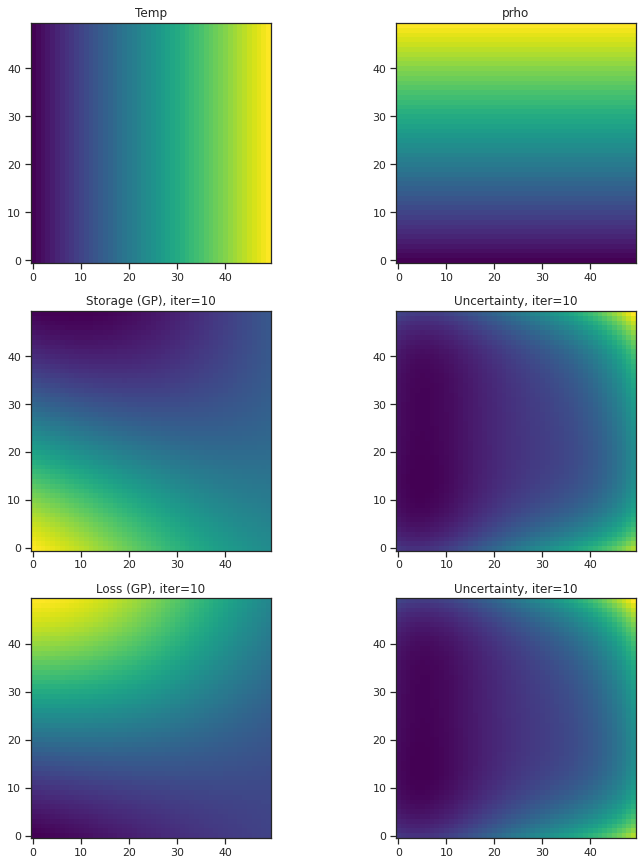

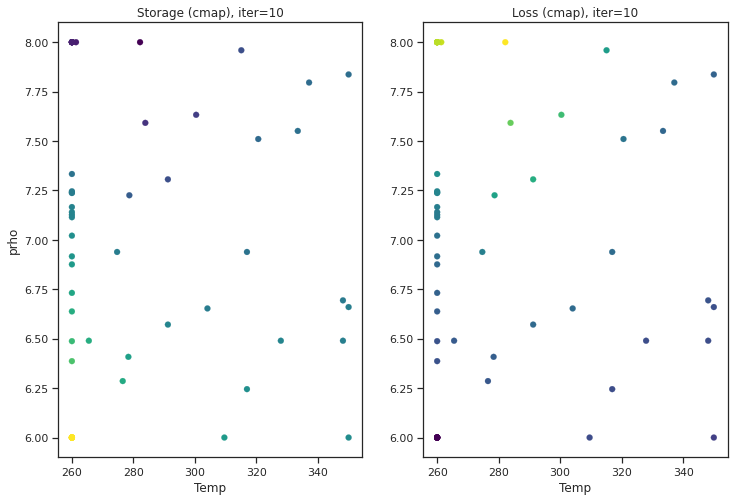

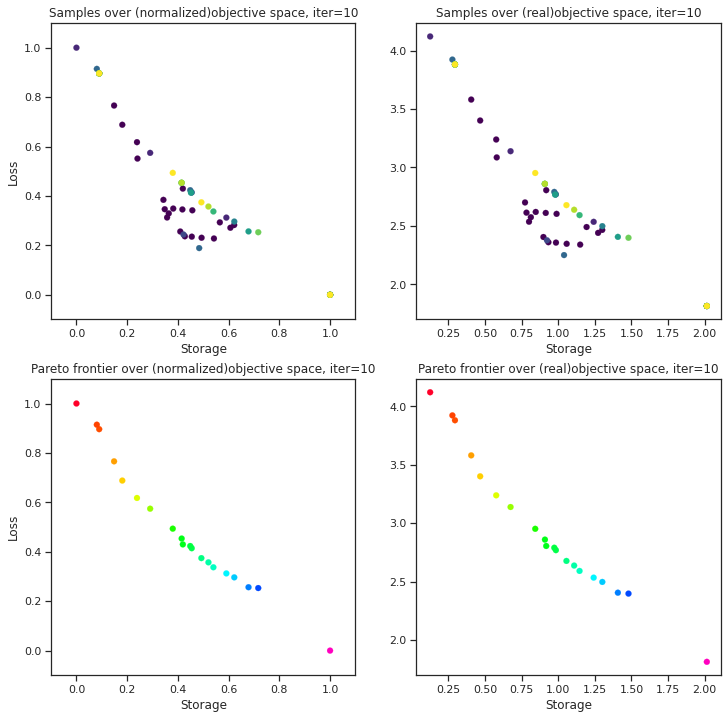

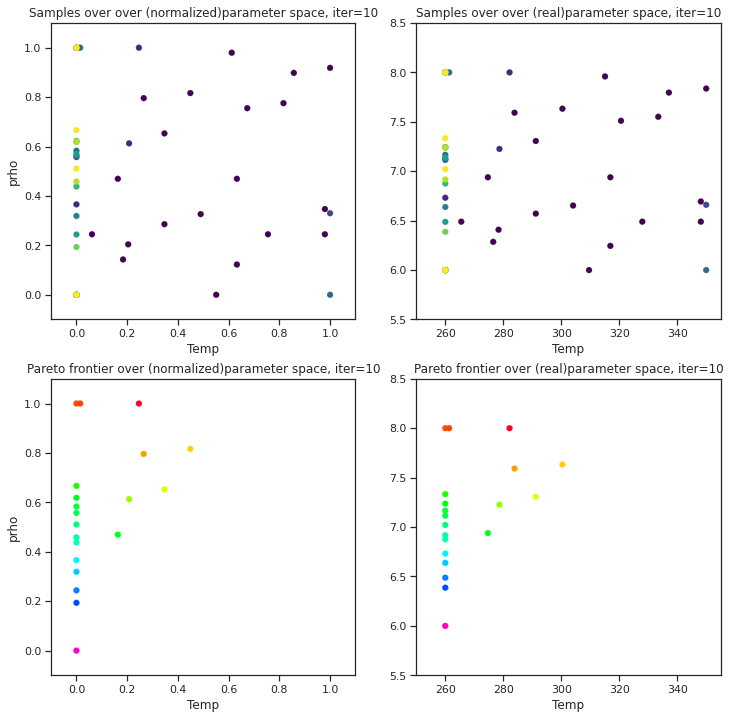

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


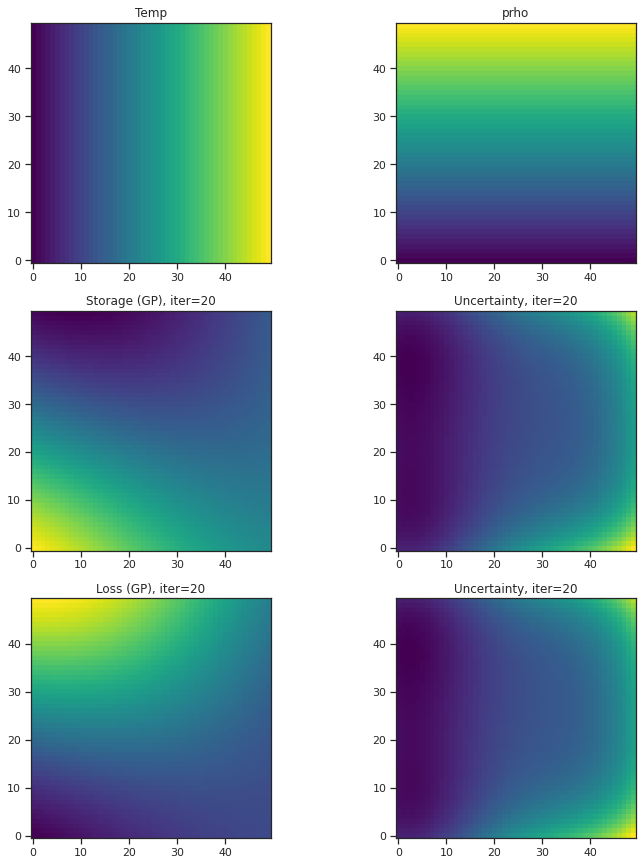

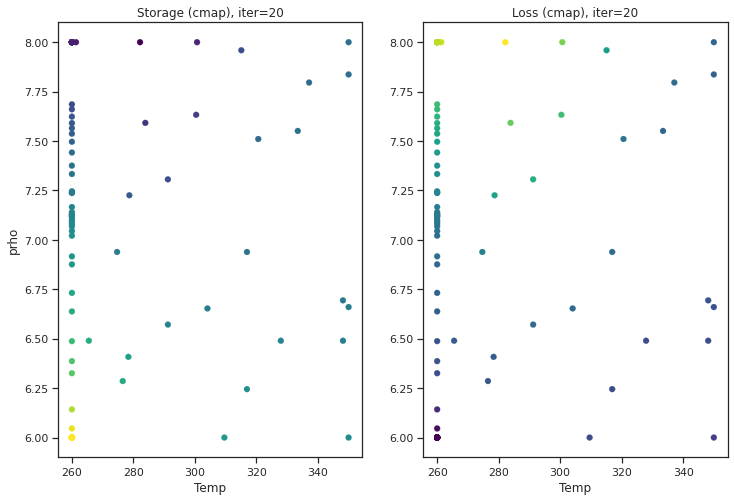

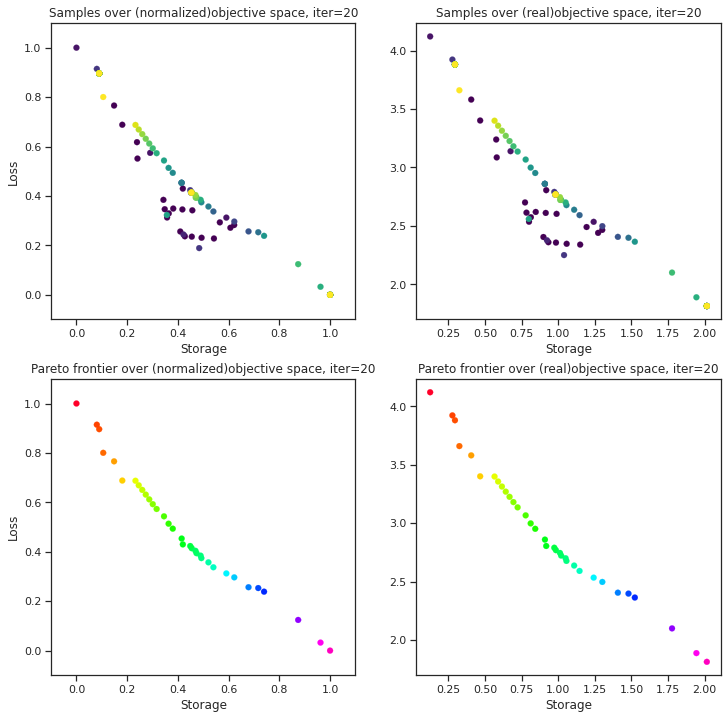

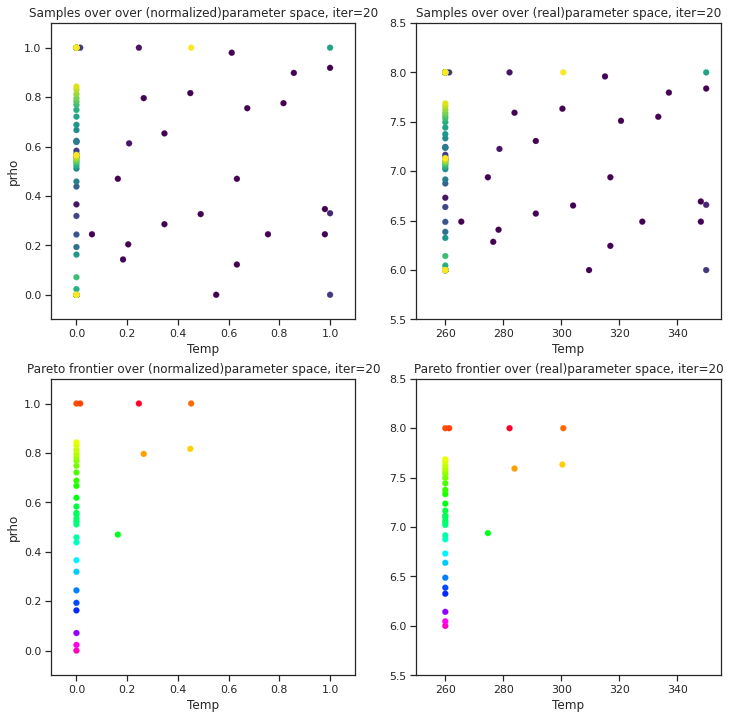

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


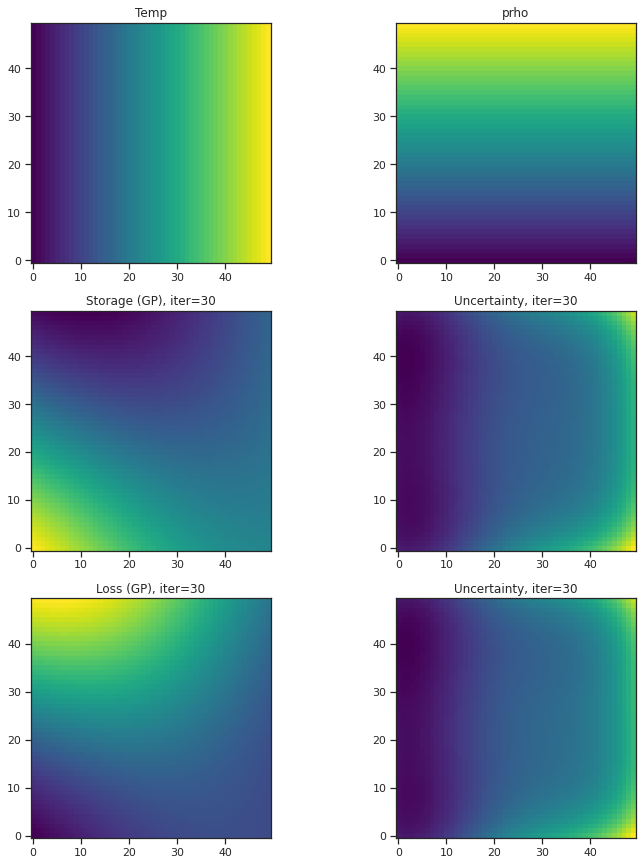

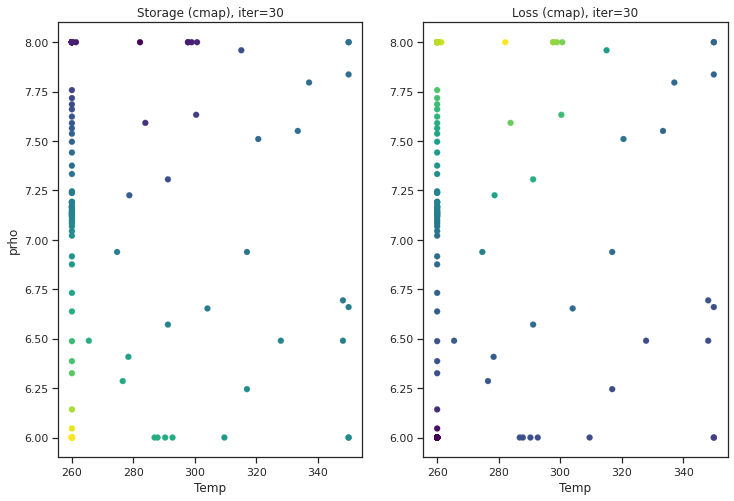

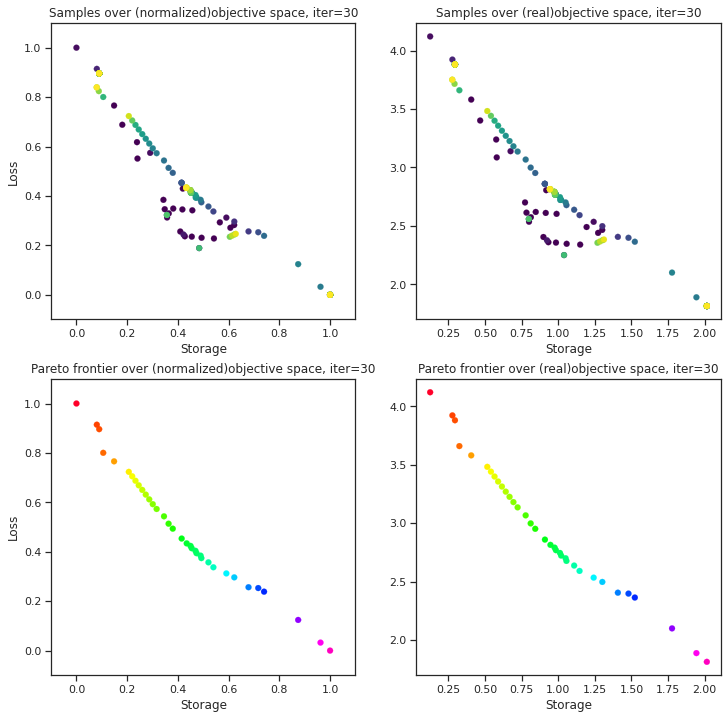

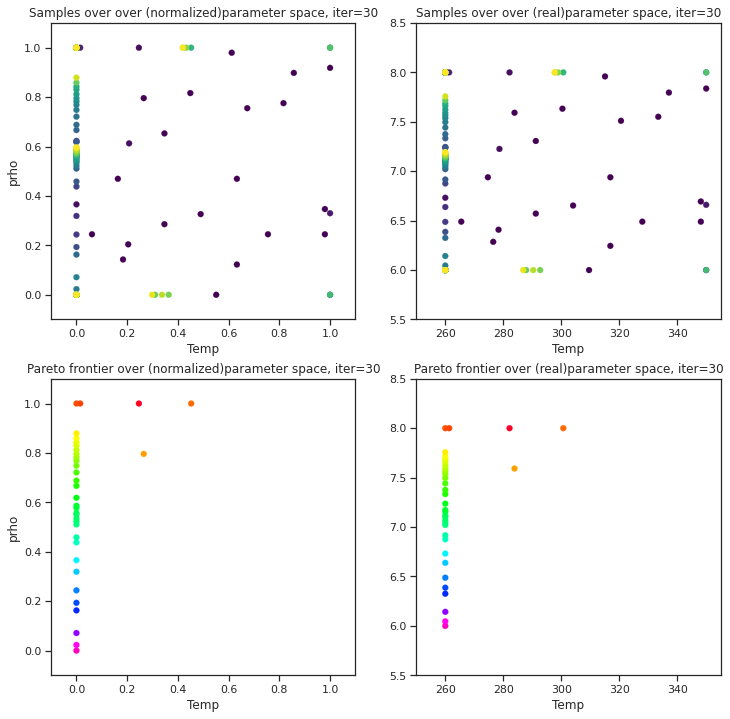

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


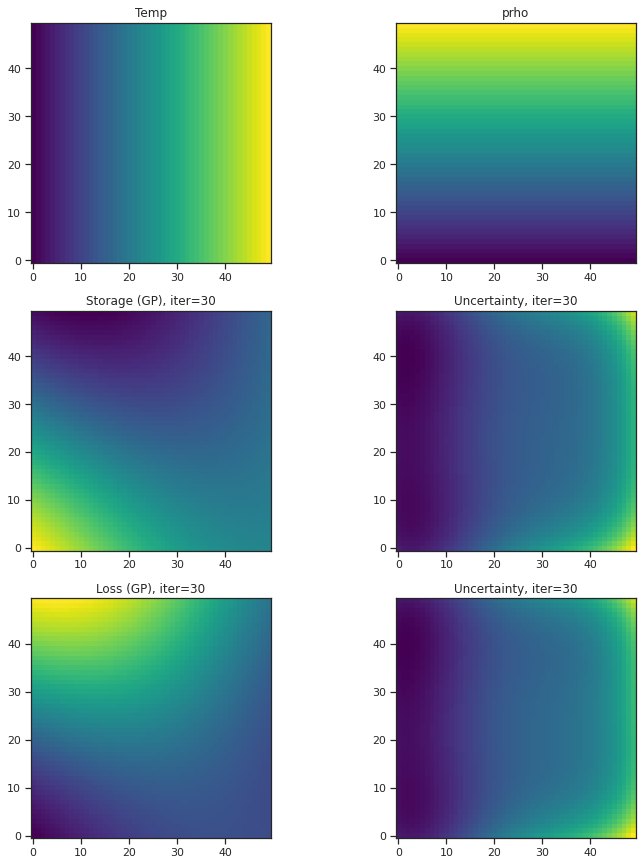

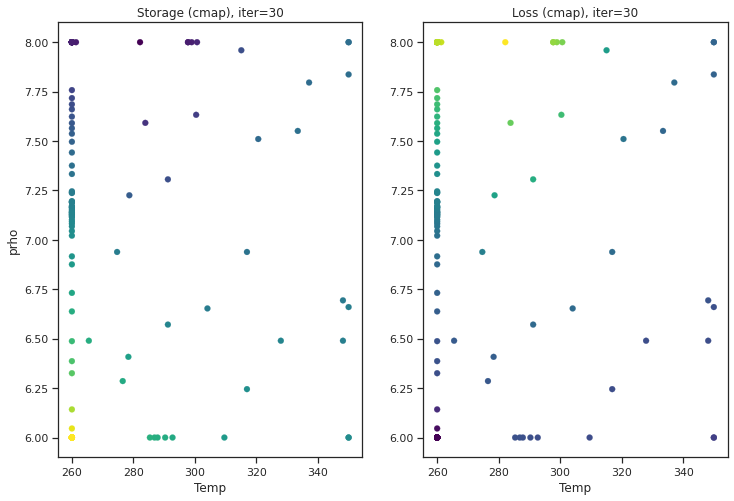

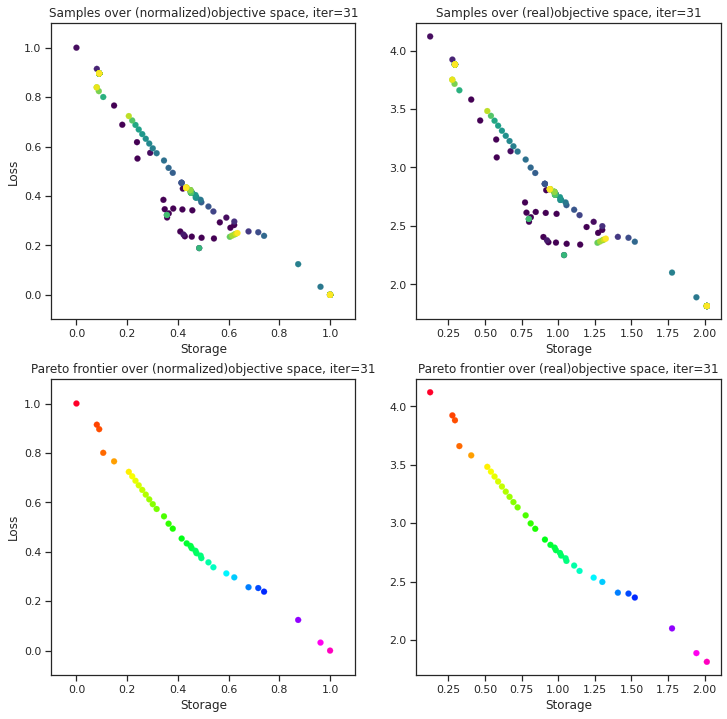

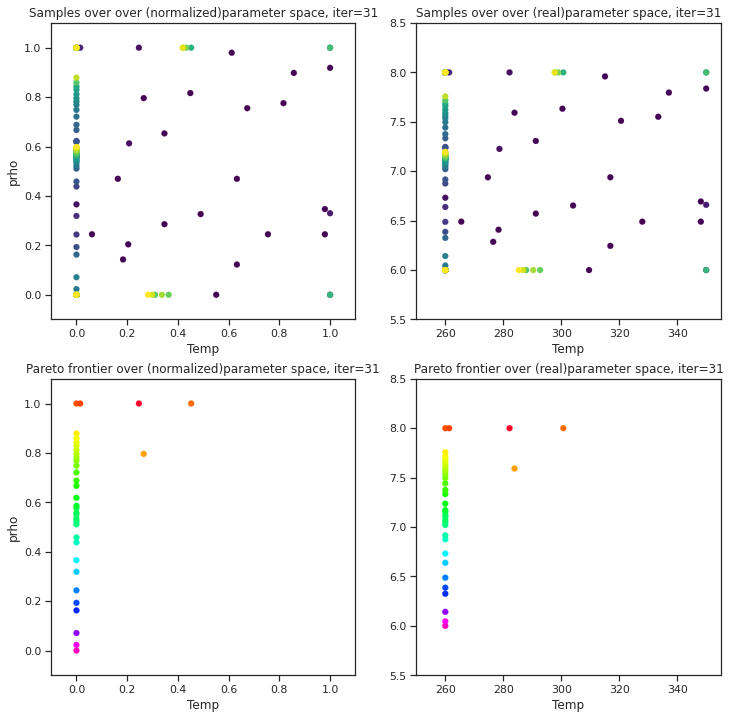

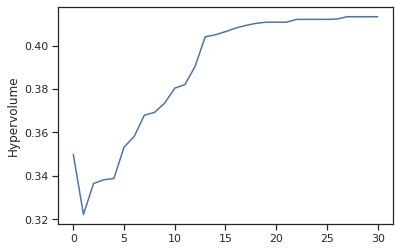

In [11]:
tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch


time_vec = np.linspace(0, 2, 500)
A = 3 #Fixed amplitude
E = A * np.sin(2 * np.pi * time_vec)

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParEGO' -qParEGO
acquisition = 'qEHVI'
# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['max','max']

#List of control params- Temp, prho, h, deltaG
# Choose any two control params to create the parameter space considering above the same order-
param1 = 'Temp'
param2 = 'prho'
# Choose any two objectives to do MOO (MOBO)-
obj1 = 'Storage'
obj2 = 'Loss'


#Define parameter space based on above choice of params (2D only)
num_rows =50
max_hysplot_dim =10
toggle_num_dim =10
num = 20  # Starting samples
N= 30
#N = (0.5 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
if (param1 == 'Temp') or (param2 == 'Temp'):
    #Creating domain space for T
    T = np.linspace(260, 350, num_rows)
    test_T = np.linspace(260, 350, num_rows) # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'Temp'):
        # Build X dataset
        X1 = T
        test_X1 = test_T
    if (param2 == 'Temp'):
        # Build X dataset
        X2 = T
        test_X2 = test_T

else:
    ##Fixed params
    T=300

if (param1 == 'prho') or (param2 == 'prho'):
    # Creating domain space for rho
    prho = np.linspace(6, 8, num_rows)
    test_prho = np.linspace(6, 8, num_rows)
    #rho = np.zeros(len(n))
    #test_rho = np.zeros(len(n))
    #for i in range(0, len(n)):
        #rho[i] = 10 ** (n[i])
        #test_rho[i] = 10 ** (n[i])  # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'prho'):
        # Build X dataset
        X1 = prho
        test_X1 = test_prho
    if (param2 == 'prho'):
        # Build X dataset
        X2 = prho
        test_X2 = test_prho

else:
    ##Fixed params
    prho=2

if (param1 == 'h') or (param2 == 'h'):
    #Creating domain space for h
    h = np.linspace(3, 60, num_rows)
    test_h = np.linspace(3, 60, num_rows)  # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'h'):
        # Build X dataset
        X1 = h
        test_X1 = test_h
    if (param2 == 'h'):
        # Build X dataset
        X2 = h
        test_X2 = test_h

else:
    ##Fixed params
    h=50

if (param1 == 'deltaG') or (param2 == 'deltaG'):
    #Creating domain space for deltaG
    deltaG = np.linspace(0.02, 2, num_rows)
    test_deltaG = np.linspace(0.02, 2, num_rows) # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'deltaG'):
        # Build X dataset
        X1 = deltaG
        test_X1 = test_deltaG
    if (param2 == 'deltaG'):
        # Build X dataset
        X2 = deltaG
        test_X2 = test_deltaG

else:
    deltaG=0.2

#Call function to run MOBO (physics driven)
#Order of parameters to input after choosing for control and fixed parameters - T, prho, h, delta
# example- If we consider control params as T and h- we provide arguments as 
# MOBO(X1, X2, prho, deltaG, .....) 
#The first two arguments are the control parameters in the recommended order, the next two arguments are the remaining parameters as fixed in the recommended order

#rest of input args in serial: E- array of external field process; test_X1, test_X2- grid numpy arrays for param X1, X2 (for optional posterior calculations); num_rows, N, BATCH_SIZE- explained in text sections; 
#param1, param2 - string names of parameter 1, 2; obj1, obj2 - string names of objective 1, 2; acquisition - string name as provided in text section for user choice of acquistion function method;
# problem - string array as provided in text section for user choice of maxmimization or minimization of objectives; testfunction - string name as provided in text section for user selection of test problems
# max_hysplot_dim- maximum scalar value of grid at each dimension for plotting different hysteresis loops in grids (if called), 
# max_hysplot_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree (if called)
MOBO_PZO(X1, X2, h, deltaG, E, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem, max_hysplot_dim, toggle_num_dim)




Lets check the ground truth of 2a, 2b with grid-based low sampling (7x7 grid)

Process:1; Analysis:1
Process:1; Analysis:2
Process:1; Analysis:3
Process:1; Analysis:4
Process:1; Analysis:5
Process:1; Analysis:6
Process:1; Analysis:7
Process:1; Analysis:8
Process:1; Analysis:9
Process:1; Analysis:10
Process:1; Analysis:11
Process:1; Analysis:12
Process:1; Analysis:13
Process:1; Analysis:14
Process:1; Analysis:15
Process:1; Analysis:16
Process:1; Analysis:17
Process:1; Analysis:18
Process:1; Analysis:19
Process:1; Analysis:20
Process:1; Analysis:21
Process:1; Analysis:22
Process:1; Analysis:23
Process:1; Analysis:24
Process:1; Analysis:25
Process:1; Analysis:26
Process:1; Analysis:27
Process:1; Analysis:28
Process:1; Analysis:29
Process:1; Analysis:30
Process:1; Analysis:31
Process:1; Analysis:32
Process:1; Analysis:33
Process:1; Analysis:34
Process:1; Analysis:35
Process:1; Analysis:36
Process:1; Analysis:37
Process:1; Analysis:38
Process:1; Analysis:39
Process:1; Analysis:40
Process:1; Analysis:41
Process:1; Analysis:42
Process:1; Analysis:43
Process:1; Analysis:

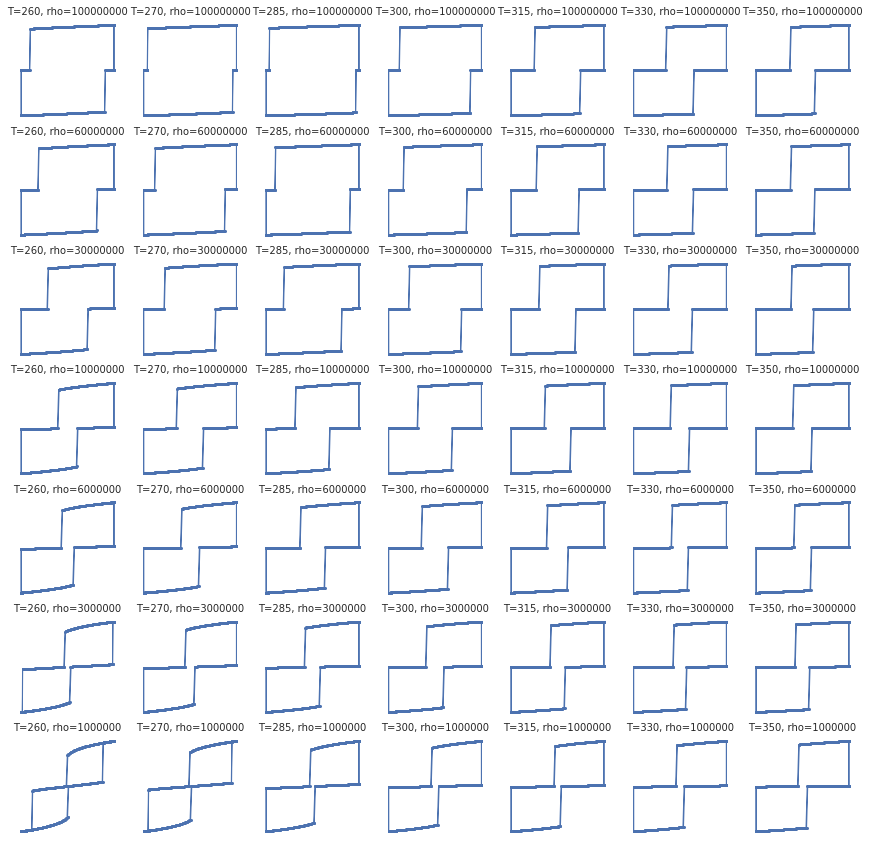

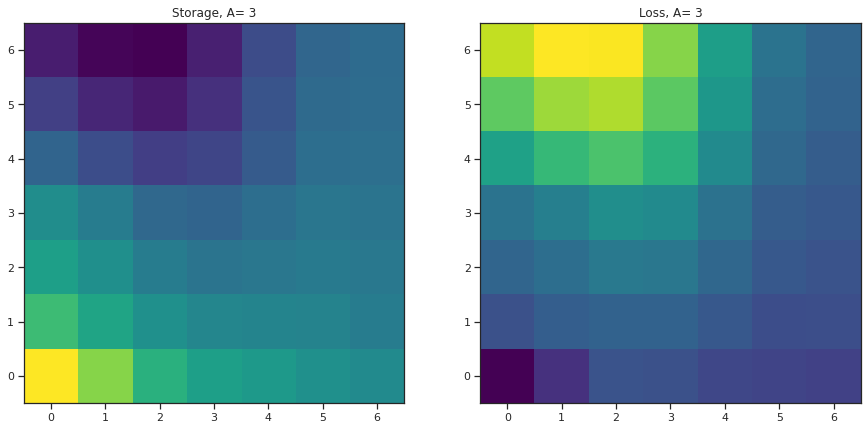

In [13]:
time_vec = np.linspace(0, 2, 500)
A = [3] #Here user can input multiple amplitude values, so the hysteresis loop and storage plots will configure for each field process defined from each amplitude values. We considered one value =3 to plot the ground truth for MOBO results

num_rows =7
max_hysplot_dim =10 # With denser maps, the hysteresis loop grid image will get very messy and thus redundant to plot. Thus, we toogle off the full hysteresis plot if the dim>10. Instead we can plot hysteresis loop separately in the previous code segment
toggle_num_dim =5  # With denser maps, the numbers in the heatmap of phase diag will get very messy and thus redundant to plot. Thus, we toogle off if the dim>10. We can get good visualization with color intensity with denser maps


Temp=[260, 270, 285, 300, 315, 330, 350]
rho=[10**6, 3*10**6, 6*10**6, 10**7, 3*10**7, 6*10**7, 10**8]

Storage = np.zeros((len(Temp), len(Temp)))
StorageA =np.zeros((len(Temp)**2,len(A)))
Loss = np.zeros((len(Temp), len(Temp)))
LossA =np.zeros((len(Temp)**2,len(A)))
Temp,rho = np.meshgrid(Temp, rho)


for proc in range(0, len(A)):
    E = A[proc] * np.sin(2 * np.pi * time_vec)
    m=0
    if (num_rows<=max_hysplot_dim):
        fig1, ax1 = plt.subplots(len(Temp), len(Temp), figsize=(15,15))

    for t1, (x1, x2) in enumerate(zip(Temp, rho)):
        for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
            m=m+1
            print("Process:" +str(proc+1)+"; Analysis:"+str(m))
            #arguments of funoptimize(T, rho, h, deltaG, E)
            Pmat, objeval, objeval2, objeval3, ES, EL= funoptimize(xx1, xx2, 5, 0.2, E)
            Storage[t1, t2] = ES #Energy storage
            Loss[t1, t2] =EL #Energy Loss
            if (num_rows<=max_hysplot_dim):
            #Plot for hysteresis loops at each region for each A
            #input arguments in order: fig1, ax1, full grid numpy array of 2 control params, numpy array of field process, scalar value of control params for which the hysteresis loops are created, iteration t1(row) and t2(col), 
            # string name of control params, linewidth, markersize and fontsize
                fig1, ax1 = plot_hysteresis(fig1, ax1, Temp, rho, E, Pmat, xx1, xx2, t1, t2, 'T','rho', 1, 2, 10)


    plt.show()

    #Plot Storage and loss grid image for each A
    #input arguments in order: full grid numpy array of Storage and loss, num of rows in each dimension of grid, toggle_num_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree,
    # A[proc] is the amplitude of the field process 
    plot_Storage_Loss(Storage, Loss, num_rows, toggle_num_dim, A[proc])


<h1>Analysis 3

num_rows =50, num = 20, N= 30

Max func evaluation- 30 (max iter)x 4(batch_size) + 20(starting samples)

Temp and $n_{\rho}$

$Temp = [300, 400]; n_{\rho} =[4, 8]$ where $\rho =10^{n_{\rho}}; h=50nm; \Delta_G =0.2$

This parameter space falls into AFE and FE phase.

**Maximize Energy Storage and Loss** - Adaptive sampling to balance between high storage and loss and find the pareto frontier.

acquistion function - **qEHVI**


Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qEHVI


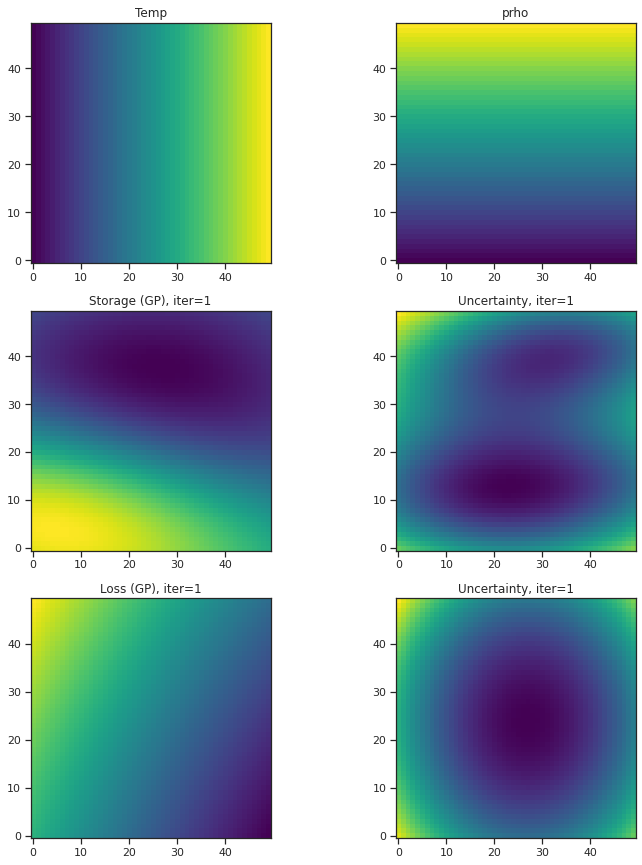

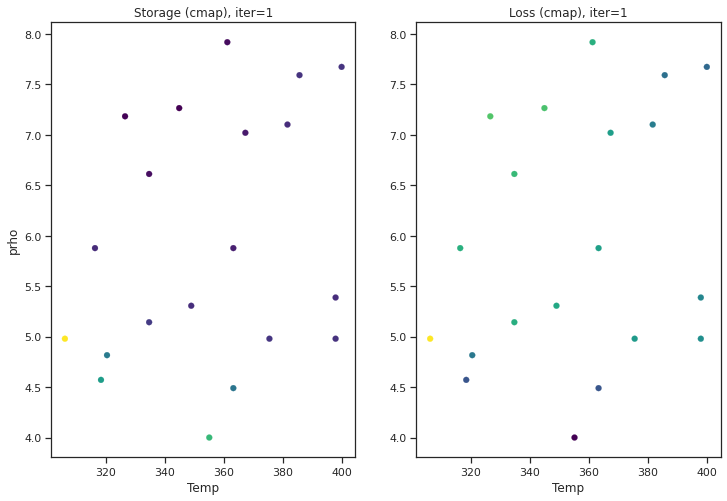

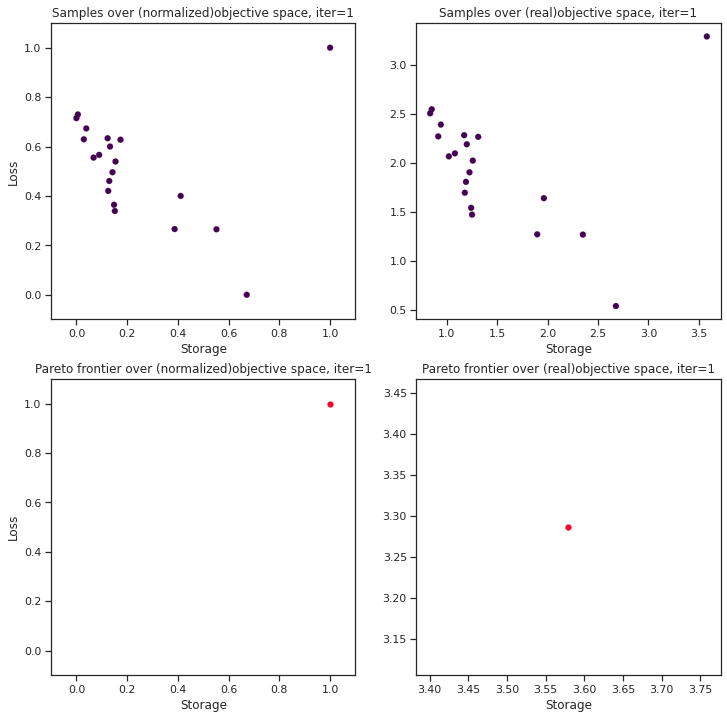

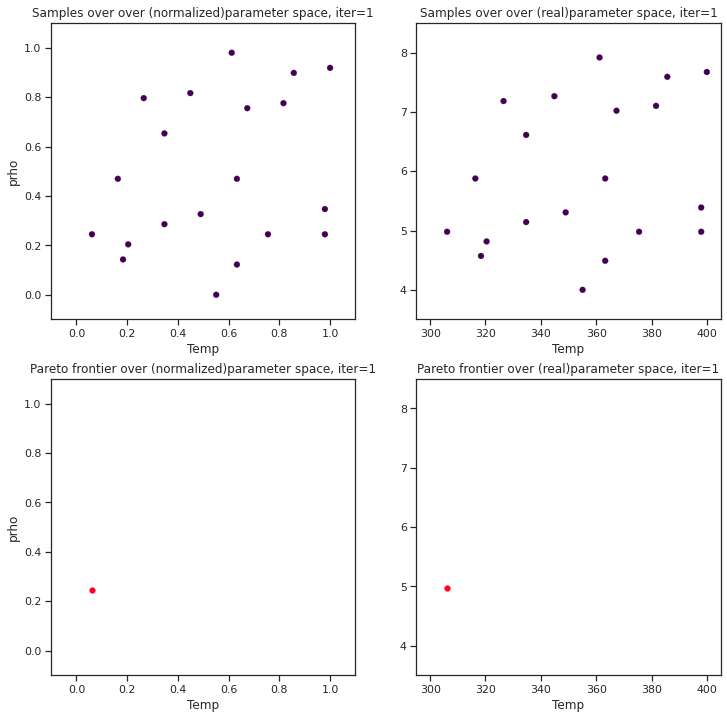

Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

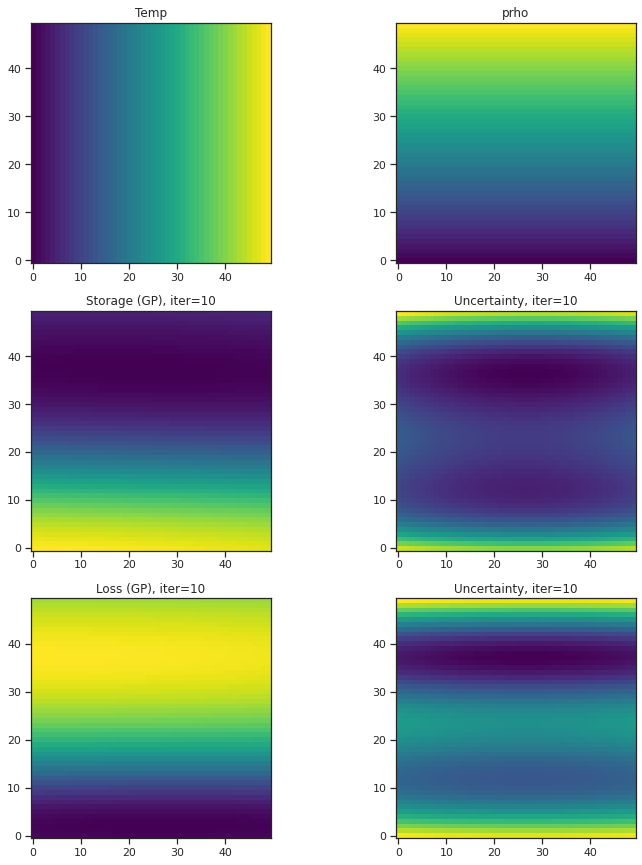

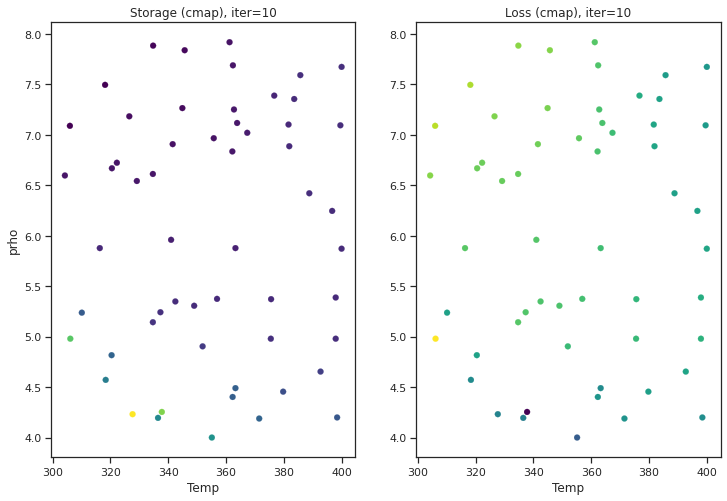

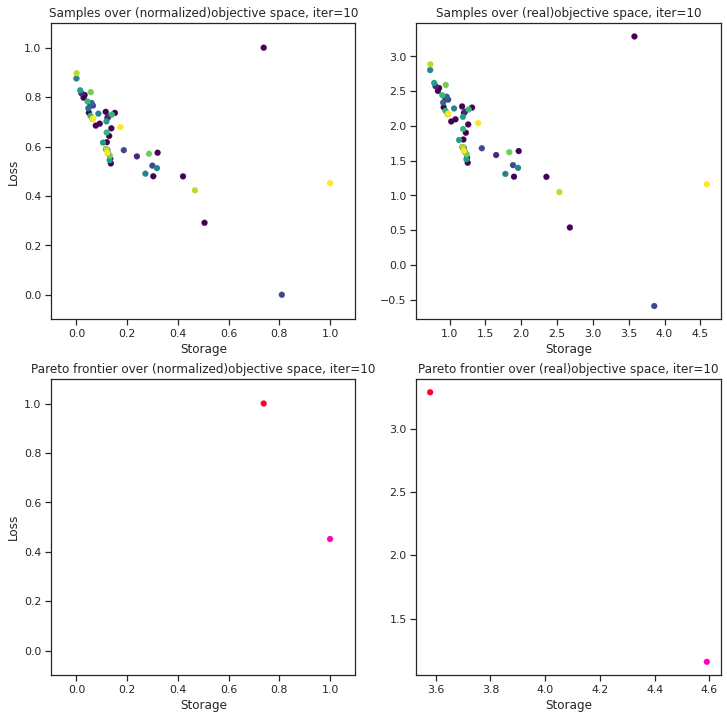

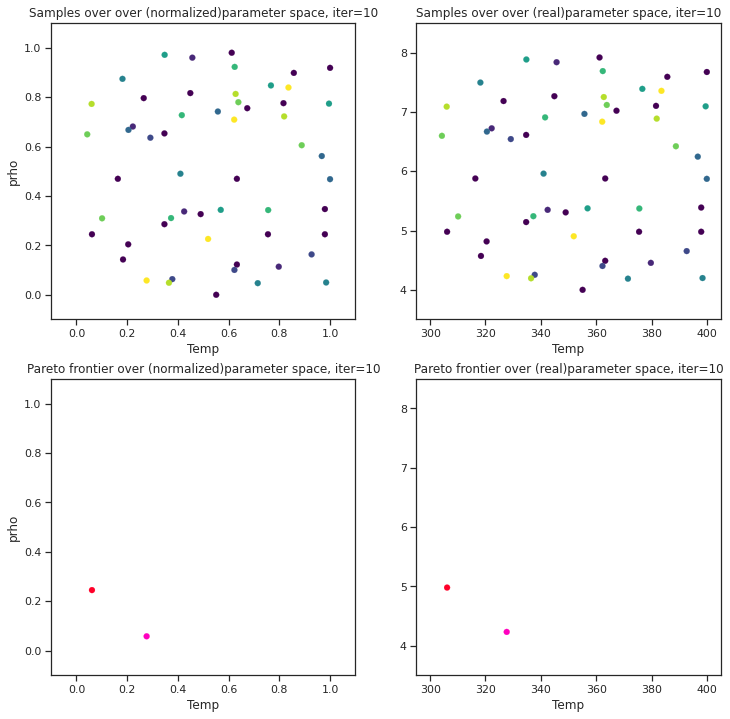

Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


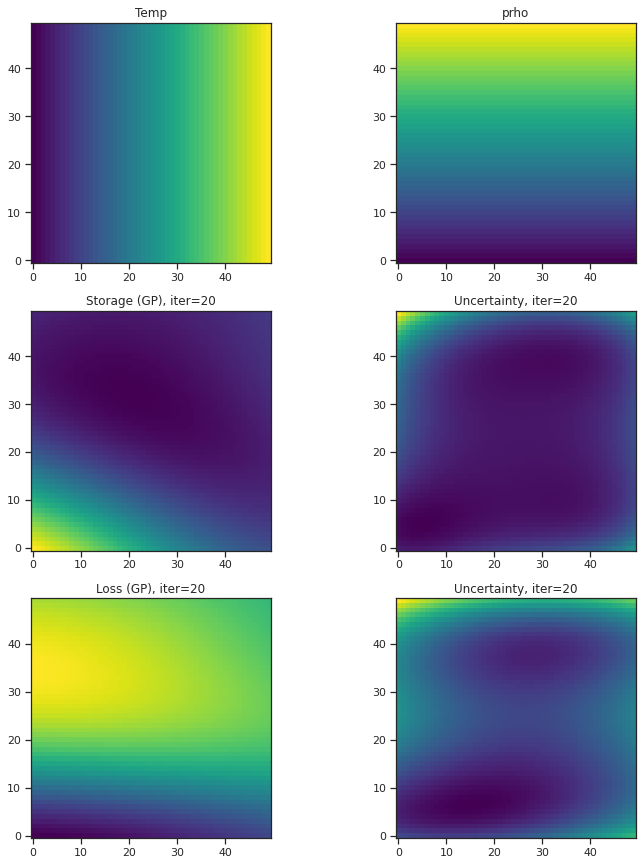

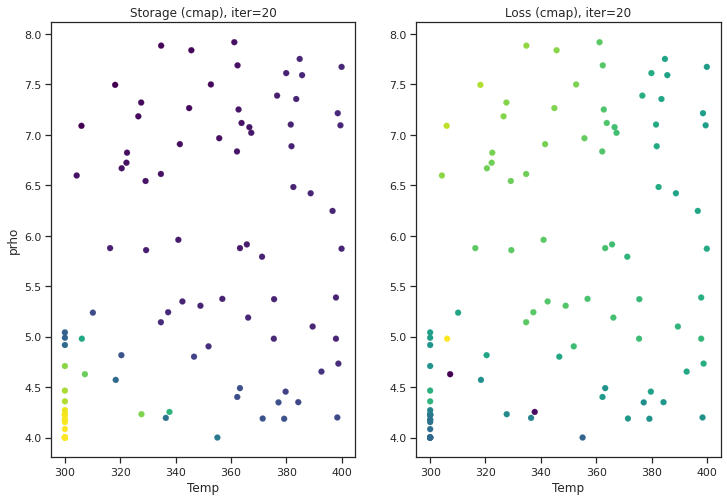

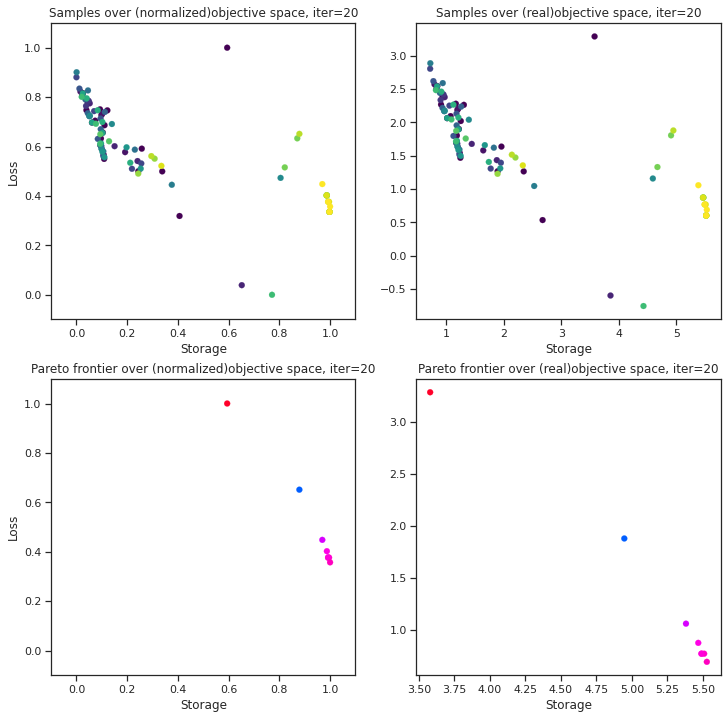

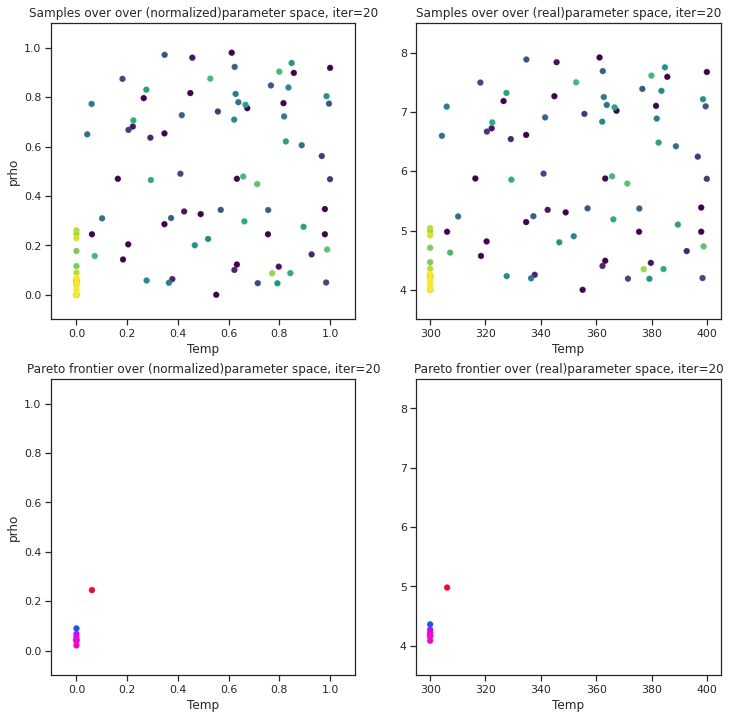

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


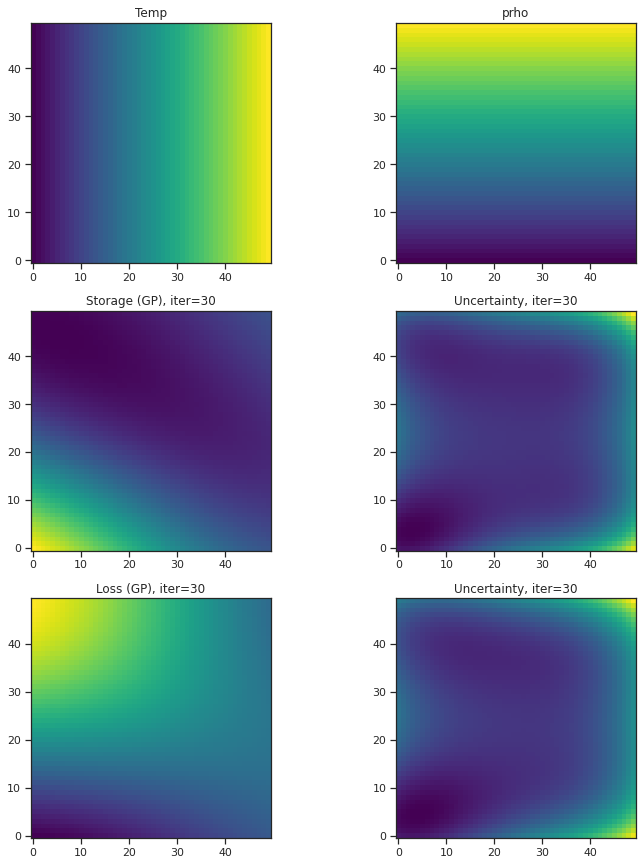

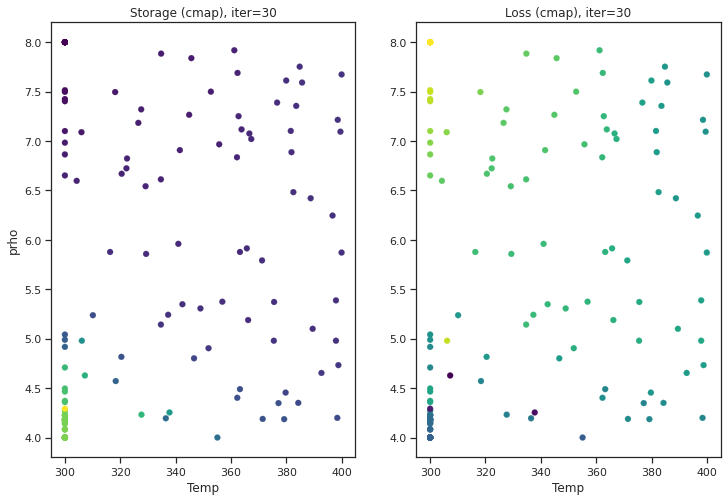

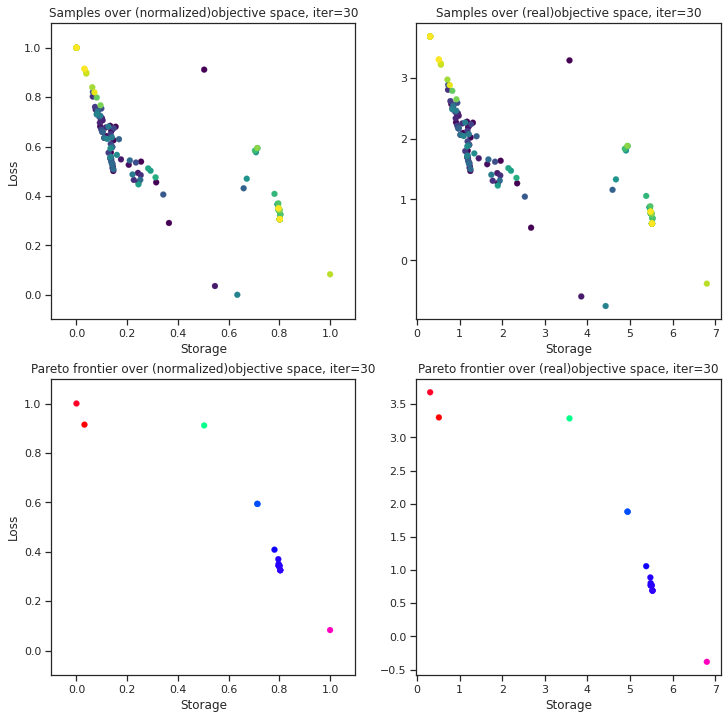

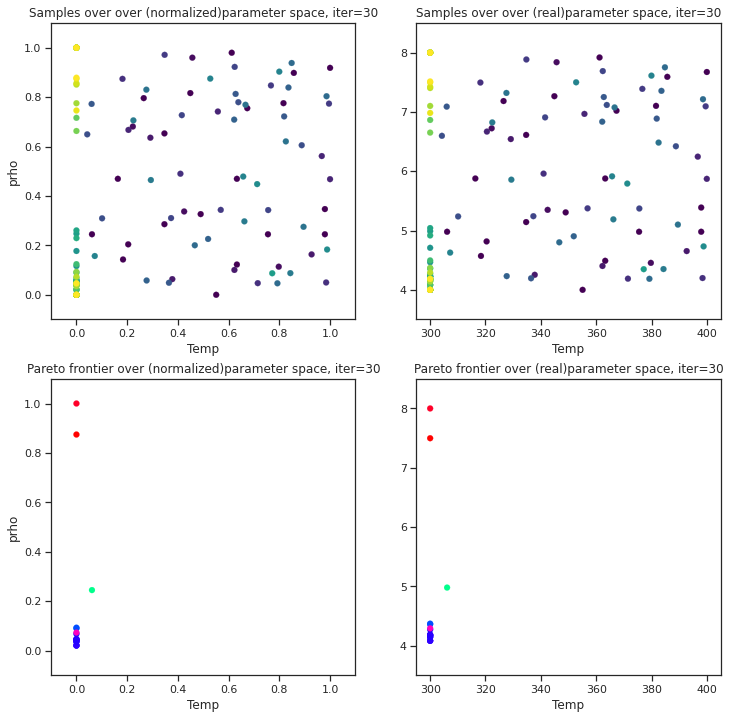

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


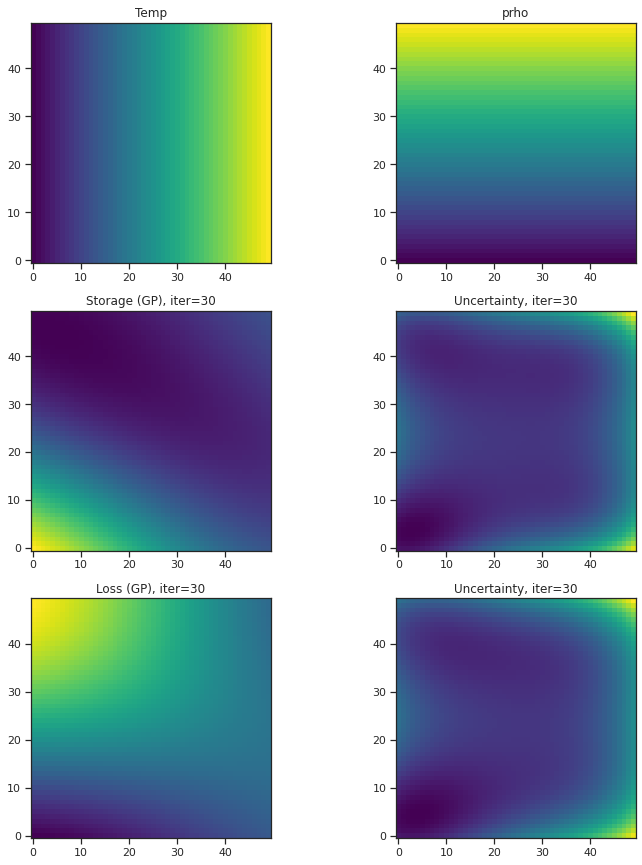

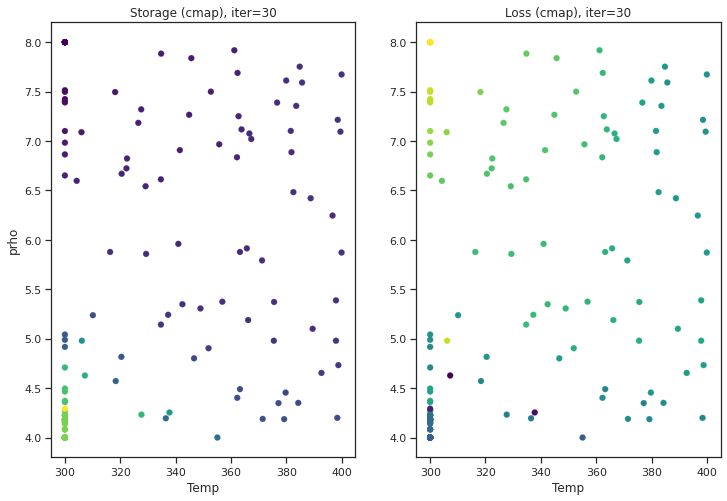

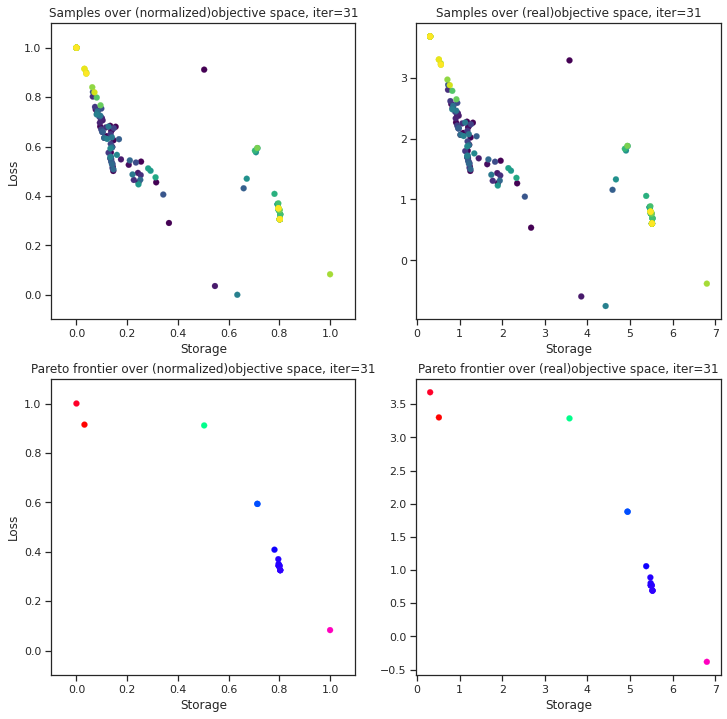

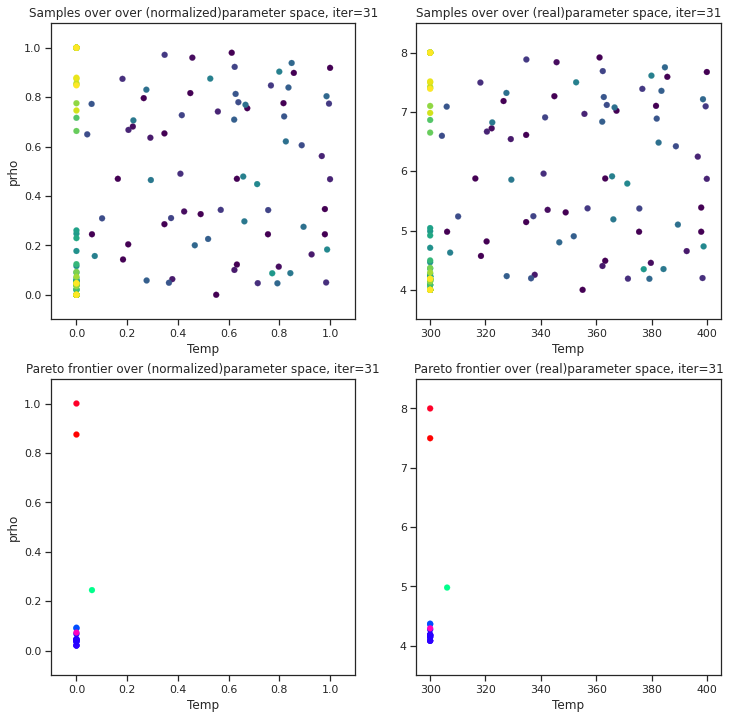

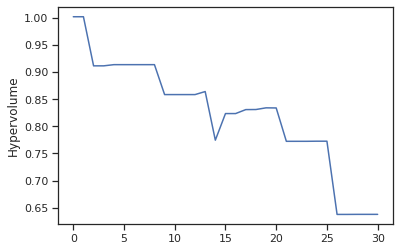

In [11]:
tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch


time_vec = np.linspace(0, 2, 500)
A = 3 #Fixed amplitude
E = A * np.sin(2 * np.pi * time_vec)

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParEGO' -qParEGO
acquisition = 'qEHVI'
# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['max','max']

#List of control params- Temp, prho, h, deltaG
# Choose any two control params to create the parameter space considering above the same order-
param1 = 'Temp'
param2 = 'prho'
# Choose any two objectives to do MOO (MOBO)-
obj1 = 'Storage'
obj2 = 'Loss'


#Define parameter space based on above choice of params (2D only)
num_rows =50
max_hysplot_dim =10
toggle_num_dim =10
num = 20  # Starting samples
N= 30
#N = (0.5 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
if (param1 == 'Temp') or (param2 == 'Temp'):
    #Creating domain space for T
    T = np.linspace(300, 400, num_rows)
    test_T = np.linspace(300, 400, num_rows) # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'Temp'):
        # Build X dataset
        X1 = T
        test_X1 = test_T
    if (param2 == 'Temp'):
        # Build X dataset
        X2 = T
        test_X2 = test_T

else:
    ##Fixed params
    T=300

if (param1 == 'prho') or (param2 == 'prho'):
    # Creating domain space for rho
    prho = np.linspace(4, 8, num_rows)
    test_prho = np.linspace(4, 8, num_rows)
    #rho = np.zeros(len(n))
    #test_rho = np.zeros(len(n))
    #for i in range(0, len(n)):
        #rho[i] = 10 ** (n[i])
        #test_rho[i] = 10 ** (n[i])  # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'prho'):
        # Build X dataset
        X1 = prho
        test_X1 = test_prho
    if (param2 == 'prho'):
        # Build X dataset
        X2 = prho
        test_X2 = test_prho

else:
    ##Fixed params
    prho=2

if (param1 == 'h') or (param2 == 'h'):
    #Creating domain space for h
    h = np.linspace(3, 60, num_rows)
    test_h = np.linspace(3, 60, num_rows)  # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'h'):
        # Build X dataset
        X1 = h
        test_X1 = test_h
    if (param2 == 'h'):
        # Build X dataset
        X2 = h
        test_X2 = test_h

else:
    ##Fixed params
    h=50

if (param1 == 'deltaG') or (param2 == 'deltaG'):
    #Creating domain space for deltaG
    deltaG = np.linspace(0.02, 2, num_rows)
    test_deltaG = np.linspace(0.02, 2, num_rows) # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'deltaG'):
        # Build X dataset
        X1 = deltaG
        test_X1 = test_deltaG
    if (param2 == 'deltaG'):
        # Build X dataset
        X2 = deltaG
        test_X2 = test_deltaG

else:
    deltaG=0.2

#Call function to run MOBO (physics driven)
#Order of parameters to input after choosing for control and fixed parameters - T, prho, h, delta
# example- If we consider control params as T and h- we provide arguments as 
# MOBO(X1, X2, prho, deltaG, .....) 
#The first two arguments are the control parameters in the recommended order, the next two arguments are the remaining parameters as fixed in the recommended order

#rest of input args in serial: E- array of external field process; test_X1, test_X2- grid numpy arrays for param X1, X2 (for optional posterior calculations); num_rows, N, BATCH_SIZE- explained in text sections; 
#param1, param2 - string names of parameter 1, 2; obj1, obj2 - string names of objective 1, 2; acquisition - string name as provided in text section for user choice of acquistion function method;
# problem - string array as provided in text section for user choice of maxmimization or minimization of objectives; testfunction - string name as provided in text section for user selection of test problems
# max_hysplot_dim- maximum scalar value of grid at each dimension for plotting different hysteresis loops in grids (if called), 
# max_hysplot_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree (if called)
MOBO_PZO(X1, X2, h, deltaG, E, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem, max_hysplot_dim, toggle_num_dim)



Lets check the ground truth of 3 with grid-based low sampling (7x7 grid)

Process:1; Analysis:1
Process:1; Analysis:2
Process:1; Analysis:3
Process:1; Analysis:4
Process:1; Analysis:5
Process:1; Analysis:6
Process:1; Analysis:7
Process:1; Analysis:8
Process:1; Analysis:9
Process:1; Analysis:10
Process:1; Analysis:11
Process:1; Analysis:12
Process:1; Analysis:13
Process:1; Analysis:14
Process:1; Analysis:15
Process:1; Analysis:16
Process:1; Analysis:17
Process:1; Analysis:18
Process:1; Analysis:19
Process:1; Analysis:20
Process:1; Analysis:21
Process:1; Analysis:22
Process:1; Analysis:23
Process:1; Analysis:24
Process:1; Analysis:25
Process:1; Analysis:26
Process:1; Analysis:27
Process:1; Analysis:28
Process:1; Analysis:29
Process:1; Analysis:30
Process:1; Analysis:31
Process:1; Analysis:32
Process:1; Analysis:33
Process:1; Analysis:34
Process:1; Analysis:35
Process:1; Analysis:36
Process:1; Analysis:37
Process:1; Analysis:38
Process:1; Analysis:39
Process:1; Analysis:40
Process:1; Analysis:41
Process:1; Analysis:42
Process:1; Analysis:43
Process:1; Analysis:

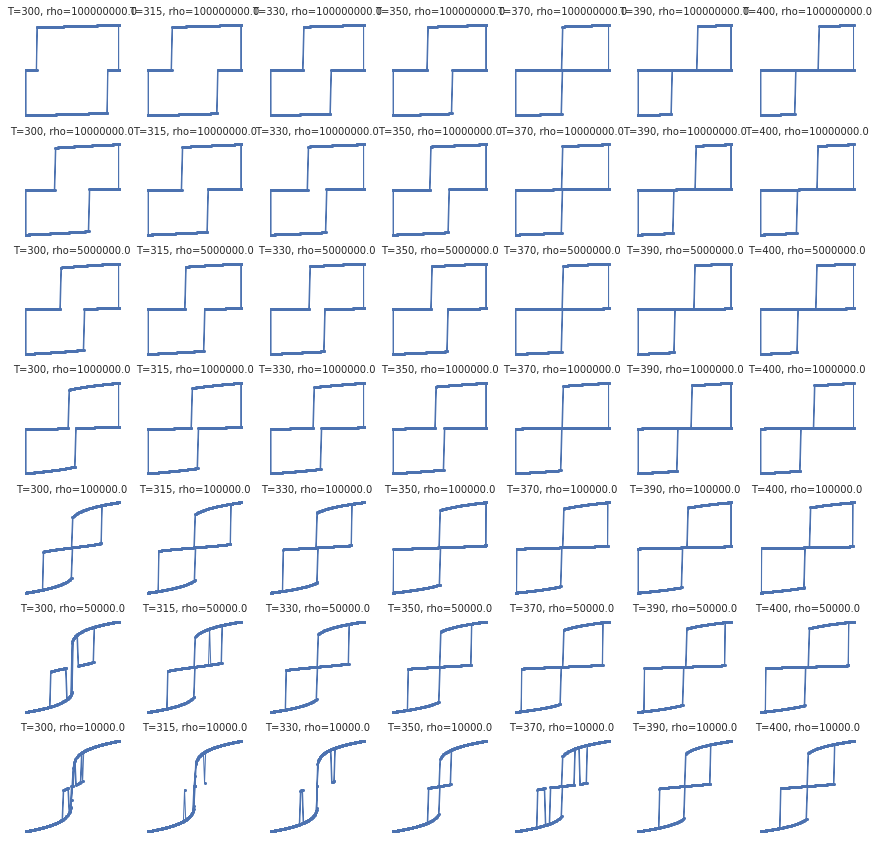

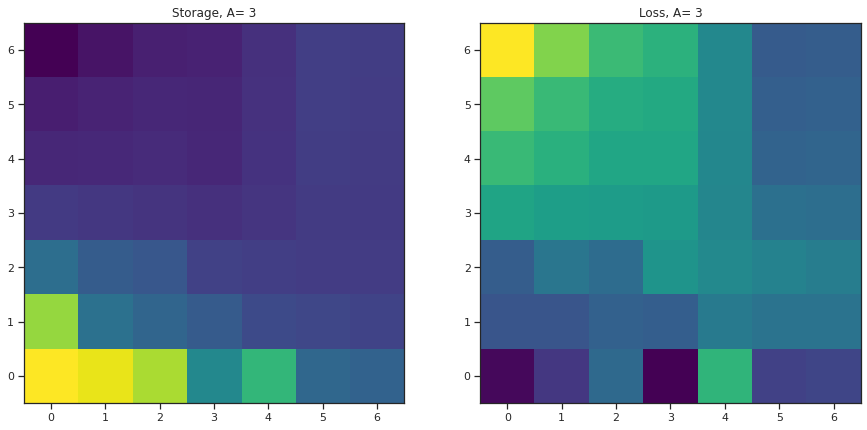

In [11]:
time_vec = np.linspace(0, 2, 500)
A = [3] #Here user can input multiple amplitude values, so the hysteresis loop and storage plots will configure for each field process defined from each amplitude values. We considered one value =3 to plot the ground truth for MOBO results

num_rows =7
max_hysplot_dim =10 # With denser maps, the hysteresis loop grid image will get very messy and thus redundant to plot. Thus, we toogle off the full hysteresis plot if the dim>10. Instead we can plot hysteresis loop separately in the previous code segment
toggle_num_dim =5  # With denser maps, the numbers in the heatmap of phase diag will get very messy and thus redundant to plot. Thus, we toogle off if the dim>10. We can get good visualization with color intensity with denser maps


Temp=[300, 315, 330, 350, 370, 390, 400]
rho=[10**4, 0.5*10**5, 10**5, 10**6, 0.5*10**7, 10**7, 10**8]

Storage = np.zeros((len(Temp), len(Temp)))
StorageA =np.zeros((len(Temp)**2,len(A)))
Loss = np.zeros((len(Temp), len(Temp)))
LossA =np.zeros((len(Temp)**2,len(A)))
Temp,rho = np.meshgrid(Temp, rho)


for proc in range(0, len(A)):
    E = A[proc] * np.sin(2 * np.pi * time_vec)
    m=0
    if (num_rows<=max_hysplot_dim):
        fig1, ax1 = plt.subplots(len(Temp), len(Temp), figsize=(15,15))

    for t1, (x1, x2) in enumerate(zip(Temp, rho)):
        for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
            m=m+1
            print("Process:" +str(proc+1)+"; Analysis:"+str(m))
            #arguments of funoptimize(T, rho, h, deltaG, E)
            Pmat, objeval, objeval2, objeval3, ES, EL= funoptimize(xx1, xx2, 5, 0.2, E)
            Storage[t1, t2] = ES #Energy storage
            Loss[t1, t2] =EL #Energy Loss
            if (num_rows<=max_hysplot_dim):
            #Plot for hysteresis loops at each region for each A
            #input arguments in order: fig1, ax1, full grid numpy array of 2 control params, numpy array of field process, scalar value of control params for which the hysteresis loops are created, iteration t1(row) and t2(col), 
            # string name of control params, linewidth, markersize and fontsize
                fig1, ax1 = plot_hysteresis(fig1, ax1, Temp, rho, E, Pmat, xx1, xx2, t1, t2, 'T','rho', 1, 2, 10)


    plt.show()

    #Plot Storage and loss grid image for each A
    #input arguments in order: full grid numpy array of Storage and loss, num of rows in each dimension of grid, toggle_num_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree,
    # A[proc] is the amplitude of the field process 
    plot_Storage_Loss(Storage, Loss, num_rows, toggle_num_dim, A[proc])



<h1>Analysis 4

num_rows =50, num = 20, N= 30

Max func evaluation- 30 (max iter)x 4(batch_size) + 20(starting samples)

Temp vs $\Delta_G$ (ion formation energy)

$Temp = [255, 410]; \Delta_G =[0.01, 0.3]; h=5nm; \rho =10^2$

This parameter space falls into AFE and FE phase.

**Maximize Energy Storage and Loss** - Adaptive sampling to balance between high storage and loss and find the pareto frontier.

acquistion function - **qEHVI**

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qEHVI


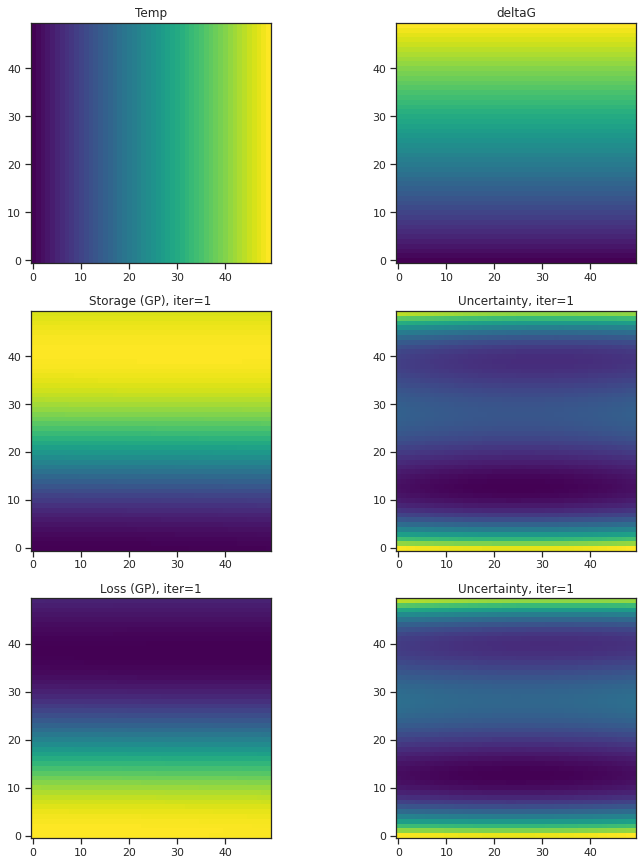

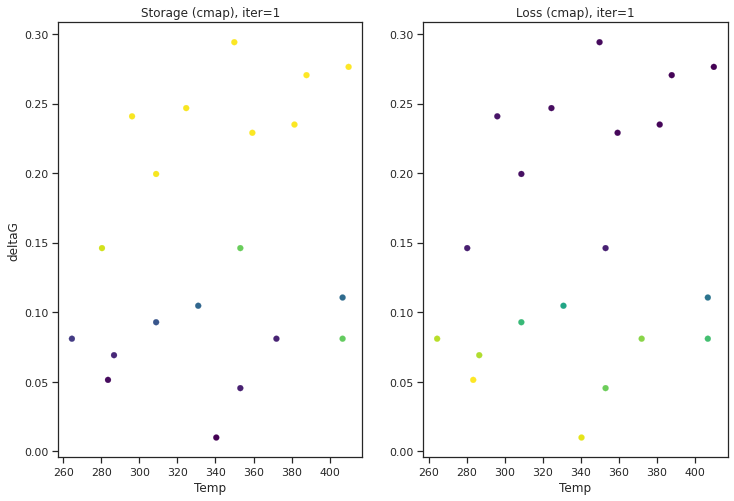

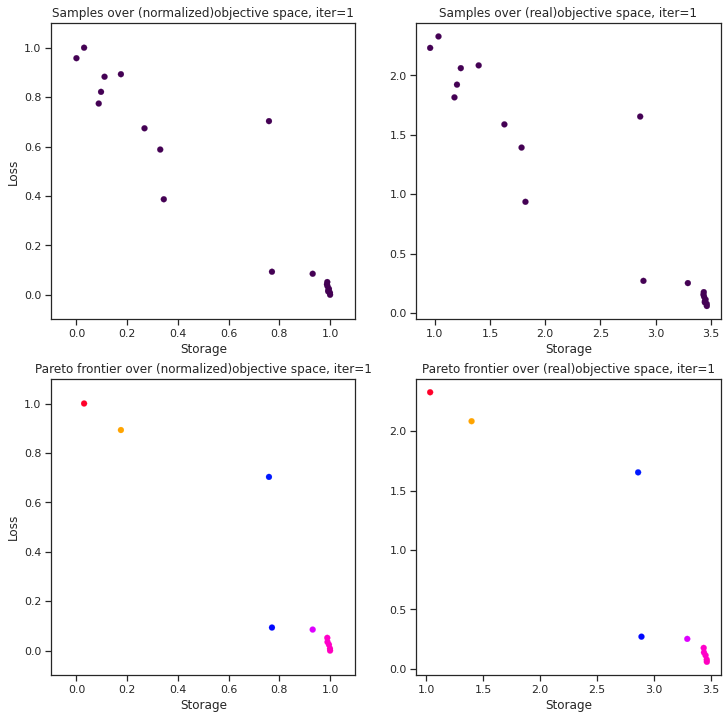

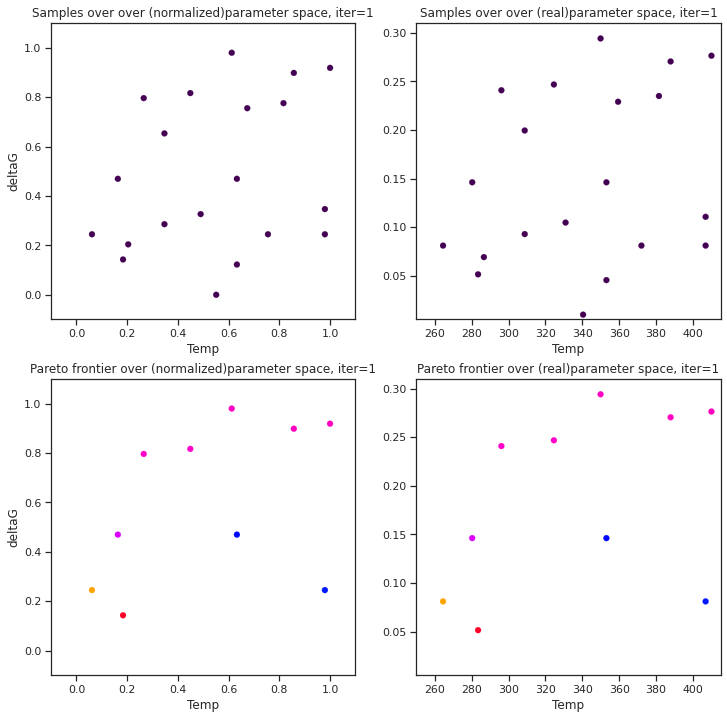

Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

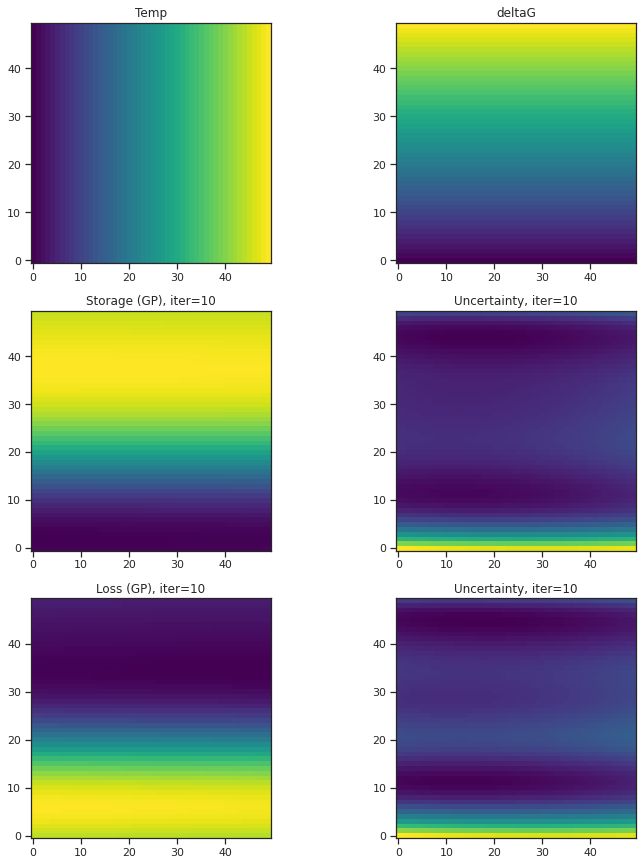

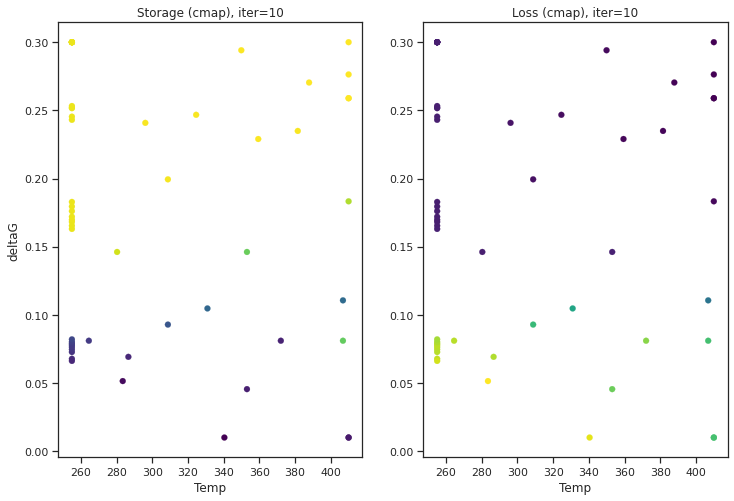

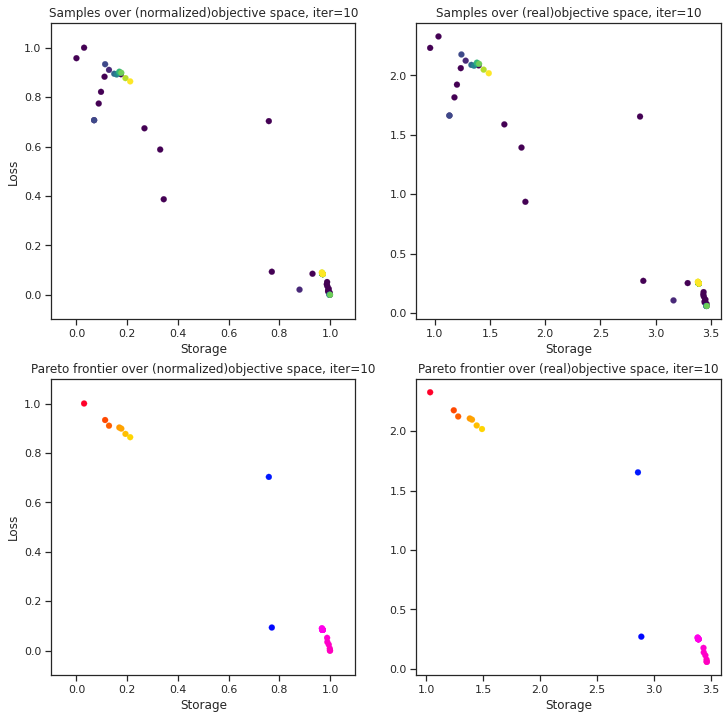

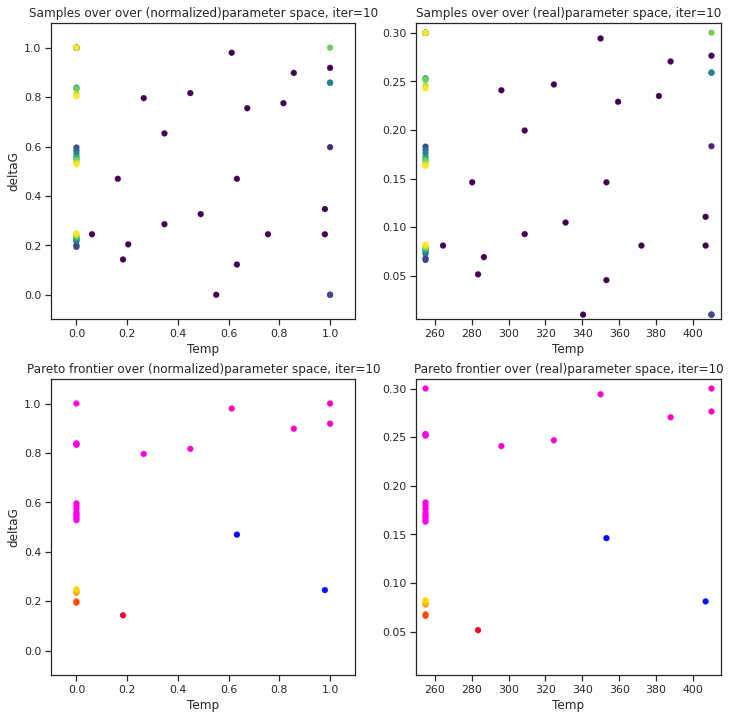

Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


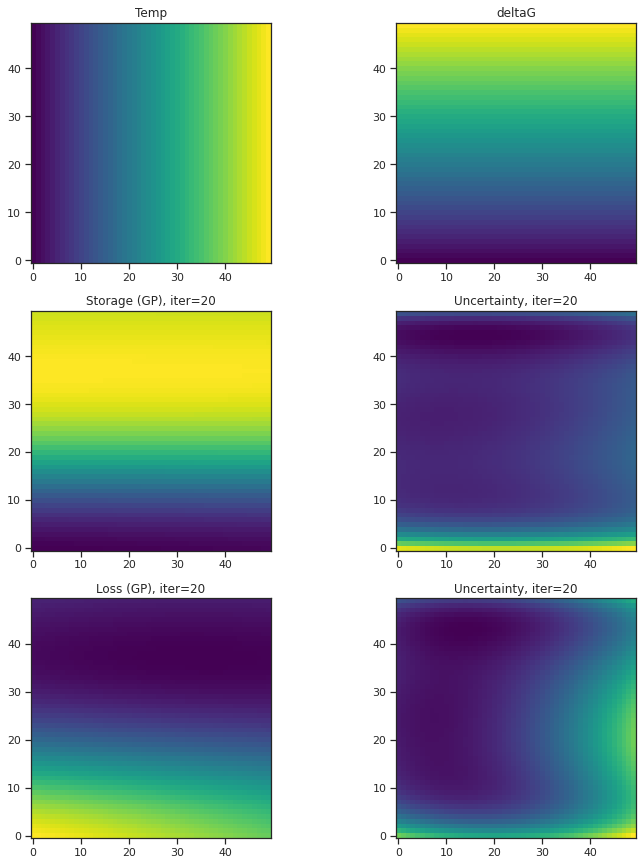

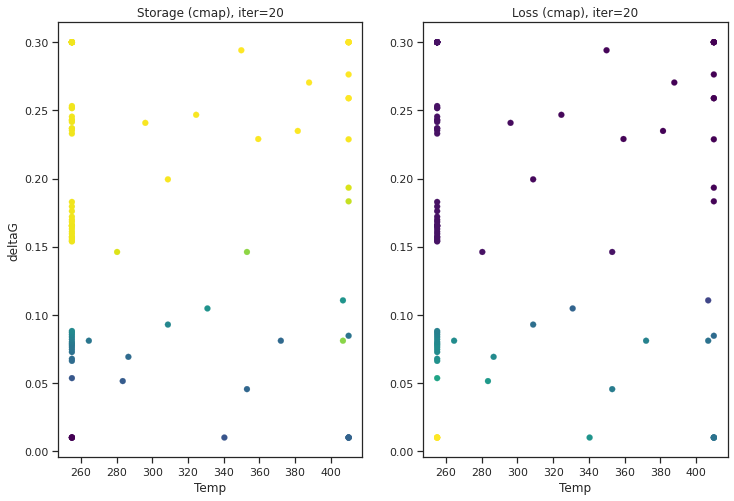

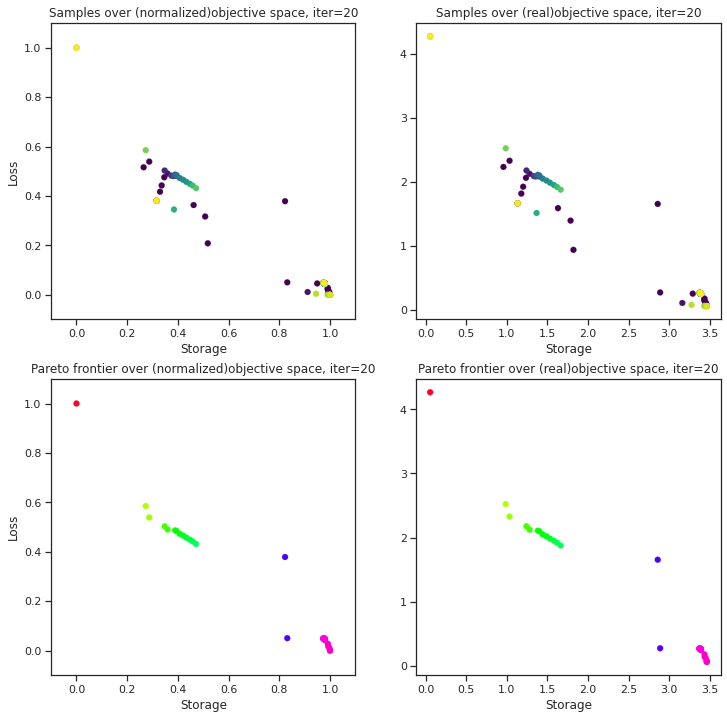

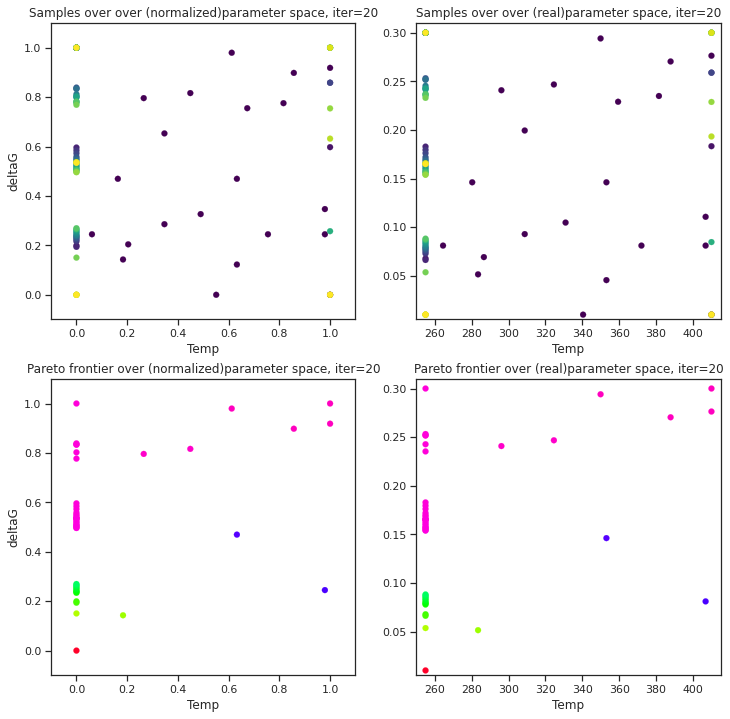

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


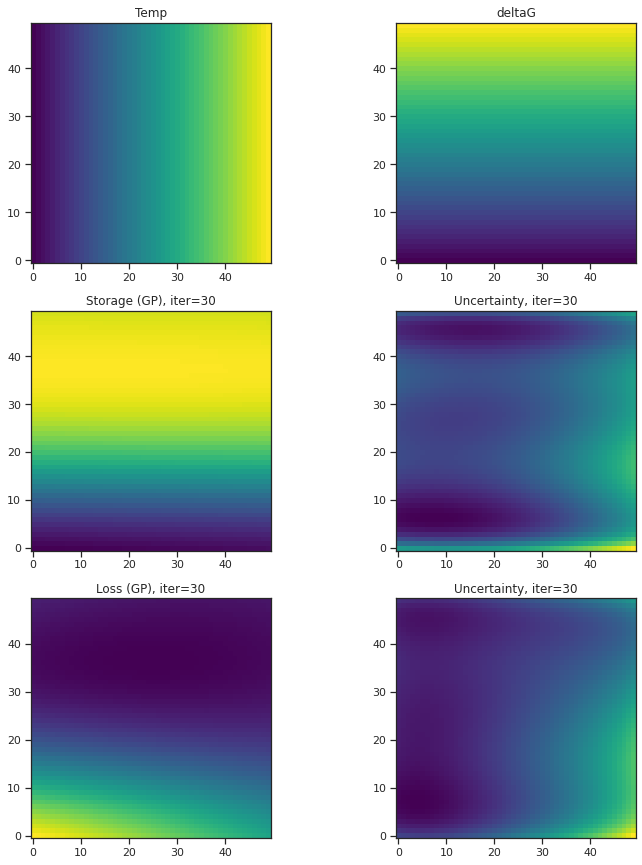

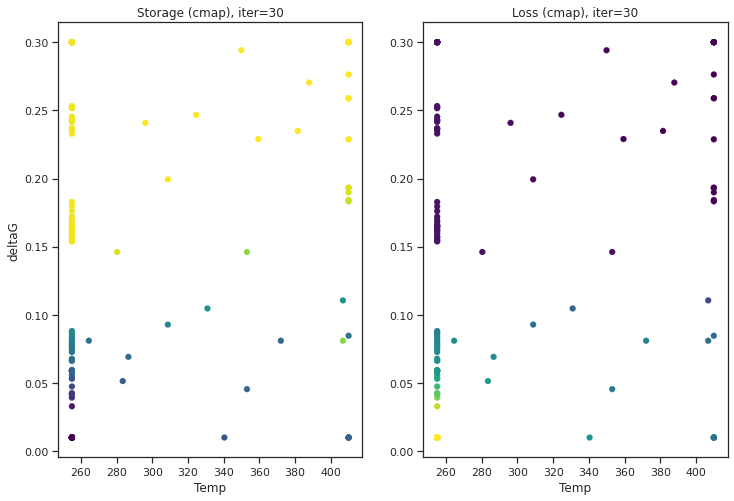

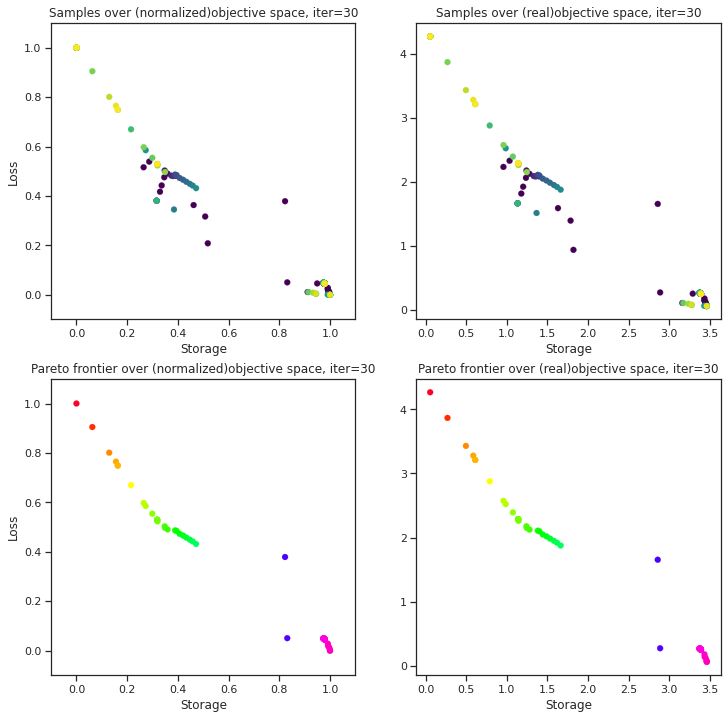

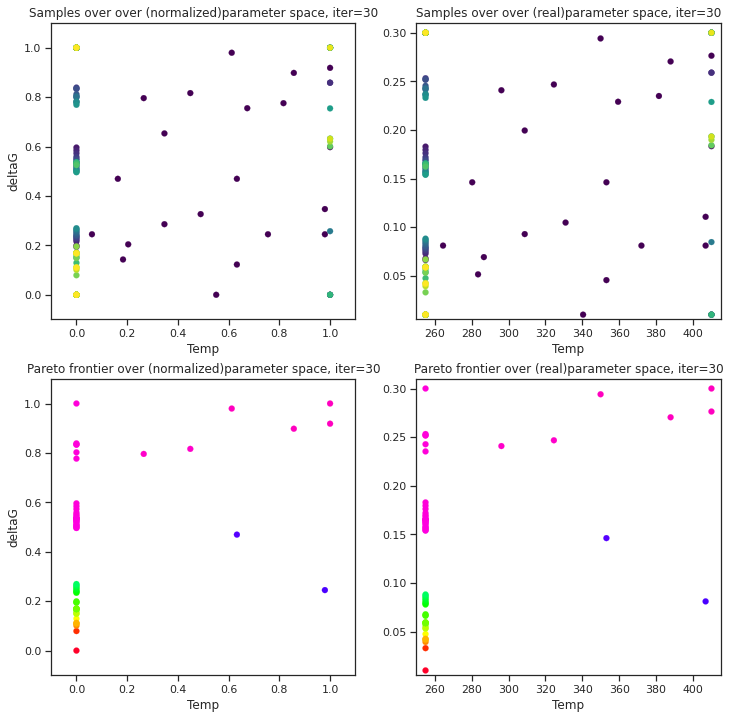

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


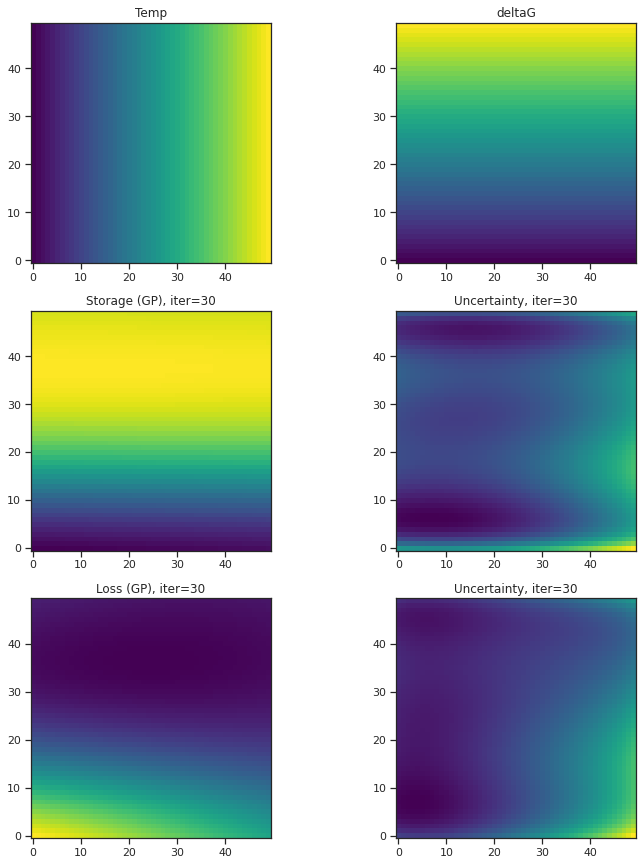

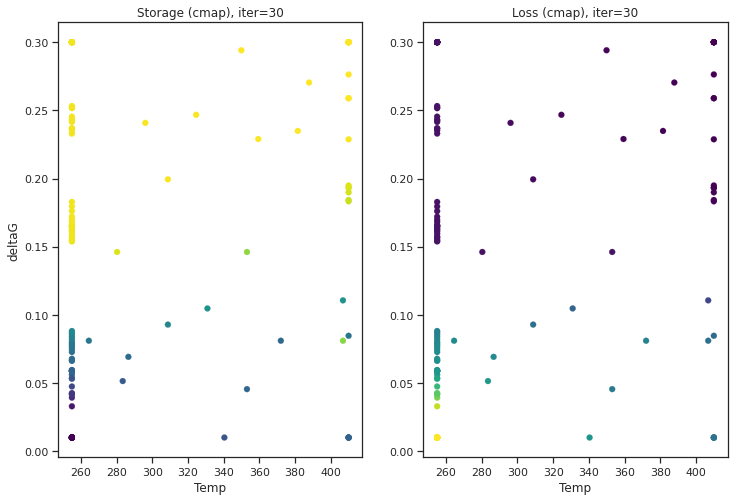

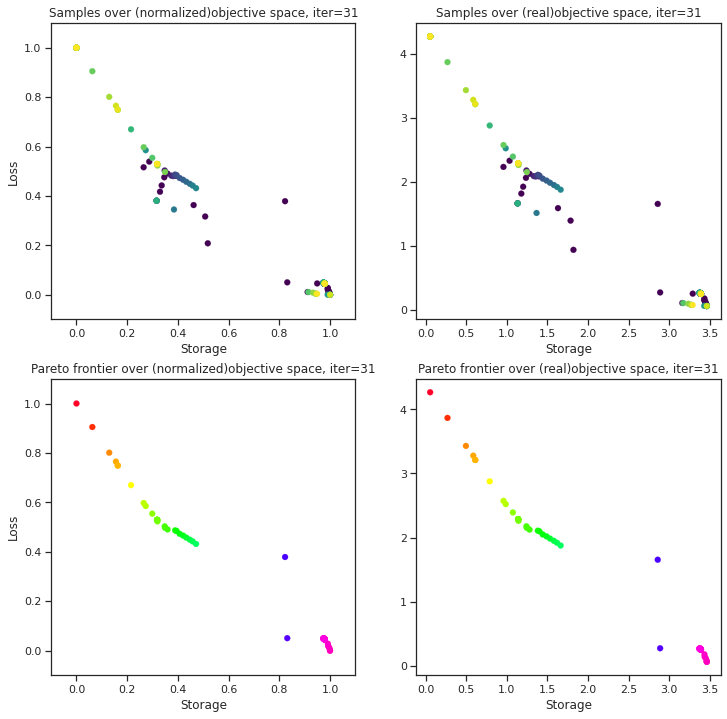

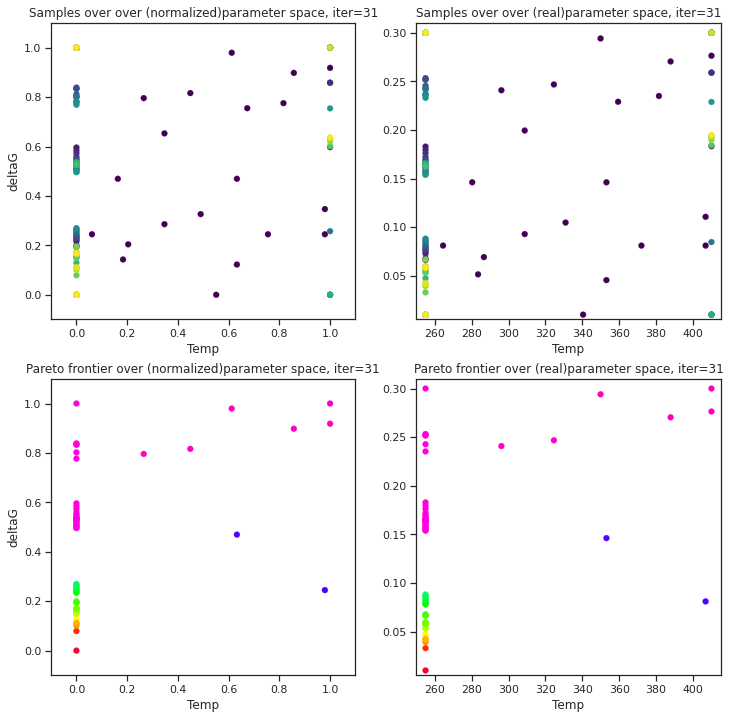

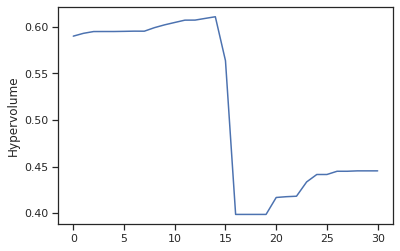

In [10]:
tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch


time_vec = np.linspace(0, 2, 500)
A = 3 #Fixed amplitude
E = A * np.sin(2 * np.pi * time_vec)

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParEGO' -qParEGO
acquisition = 'qEHVI'
# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['max','max']

#List of control params- Temp, prho, h, deltaG
# Choose any two control params to create the parameter space considering above the same order-
param1 = 'Temp'
param2 = 'deltaG'
# Choose any two objectives to do MOO (MOBO)-
obj1 = 'Storage'
obj2 = 'Loss'


#Define parameter space based on above choice of params (2D only)
num_rows =50
max_hysplot_dim =10
toggle_num_dim =10
num = 20  # Starting samples
N= 30
#N = (0.5 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
if (param1 == 'Temp') or (param2 == 'Temp'):
    #Creating domain space for T
    T = np.linspace(255, 410, num_rows)
    test_T = np.linspace(255, 410, num_rows) # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'Temp'):
        # Build X dataset
        X1 = T
        test_X1 = test_T
    if (param2 == 'Temp'):
        # Build X dataset
        X2 = T
        test_X2 = test_T

else:
    ##Fixed params
    T=300

if (param1 == 'prho') or (param2 == 'prho'):
    # Creating domain space for rho
    prho = np.linspace(-3, 3, num_rows)
    test_prho = np.linspace(-3, 3, num_rows)
    #rho = np.zeros(len(n))
    #test_rho = np.zeros(len(n))
    #for i in range(0, len(n)):
        #rho[i] = 10 ** (n[i])
        #test_rho[i] = 10 ** (n[i])  # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'prho'):
        # Build X dataset
        X1 = prho
        test_X1 = test_prho
    if (param2 == 'prho'):
        # Build X dataset
        X2 = prho
        test_X2 = test_prho

else:
    ##Fixed params
    prho=2

if (param1 == 'h') or (param2 == 'h'):
    #Creating domain space for h
    h = np.linspace(3, 60, num_rows)
    test_h = np.linspace(3, 60, num_rows)  # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'h'):
        # Build X dataset
        X1 = h
        test_X1 = test_h
    if (param2 == 'h'):
        # Build X dataset
        X2 = h
        test_X2 = test_h

else:
    ##Fixed params
    h=5

if (param1 == 'deltaG') or (param2 == 'deltaG'):
    #Creating domain space for deltaG
    deltaG = np.linspace(0.01, 0.3, num_rows)
    test_deltaG = np.linspace(0.01, 0.3, num_rows) # We avoid repeating analysis at same location-- we will mask the location which is once sampled suring the iteration phase
    if (param1 == 'deltaG'):
        # Build X dataset
        X1 = deltaG
        test_X1 = test_deltaG
    if (param2 == 'deltaG'):
        # Build X dataset
        X2 = deltaG
        test_X2 = test_deltaG

else:
    deltaG=0.2

#Call function to run MOBO (physics driven)
#Order of parameters to input after choosing for control and fixed parameters - T, prho, h, delta
# example- If we consider control params as T and h- we provide arguments as 
# MOBO(X1, X2, prho, deltaG, .....) 
#The first two arguments are the control parameters in the recommended order, the next two arguments are the remaining parameters as fixed in the recommended order

#rest of input args in serial: E- array of external field process; test_X1, test_X2- grid numpy arrays for param X1, X2 (for optional posterior calculations); num_rows, N, BATCH_SIZE- explained in text sections; 
#param1, param2 - string names of parameter 1, 2; obj1, obj2 - string names of objective 1, 2; acquisition - string name as provided in text section for user choice of acquistion function method;
# problem - string array as provided in text section for user choice of maxmimization or minimization of objectives; testfunction - string name as provided in text section for user selection of test problems
# max_hysplot_dim- maximum scalar value of grid at each dimension for plotting different hysteresis loops in grids (if called), 
# max_hysplot_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree (if called)
MOBO_PZO(X1, X2, prho, h, E, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem, max_hysplot_dim, toggle_num_dim)



Lets check the ground truth of 4 with grid-based low sampling (7x7 grid)

Process:1; Analysis:1
Process:1; Analysis:2
Process:1; Analysis:3
Process:1; Analysis:4
Process:1; Analysis:5
Process:1; Analysis:6
Process:1; Analysis:7
Process:1; Analysis:8
Process:1; Analysis:9
Process:1; Analysis:10
Process:1; Analysis:11
Process:1; Analysis:12
Process:1; Analysis:13
Process:1; Analysis:14
Process:1; Analysis:15
Process:1; Analysis:16
Process:1; Analysis:17
Process:1; Analysis:18
Process:1; Analysis:19
Process:1; Analysis:20
Process:1; Analysis:21
Process:1; Analysis:22
Process:1; Analysis:23
Process:1; Analysis:24
Process:1; Analysis:25
Process:1; Analysis:26
Process:1; Analysis:27
Process:1; Analysis:28
Process:1; Analysis:29
Process:1; Analysis:30
Process:1; Analysis:31
Process:1; Analysis:32
Process:1; Analysis:33
Process:1; Analysis:34
Process:1; Analysis:35
Process:1; Analysis:36
Process:1; Analysis:37
Process:1; Analysis:38
Process:1; Analysis:39
Process:1; Analysis:40
Process:1; Analysis:41
Process:1; Analysis:42
Process:1; Analysis:43
Process:1; Analysis:

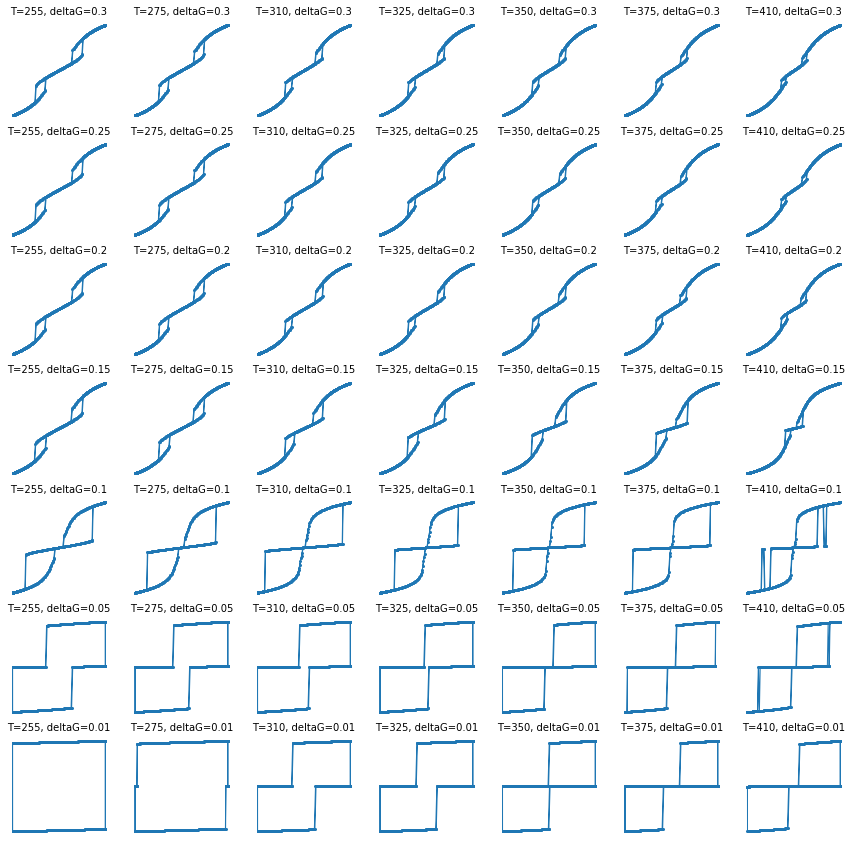

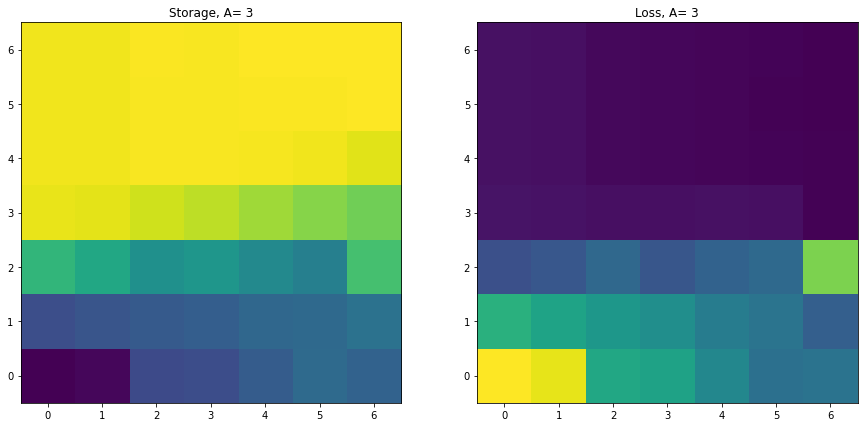

In [12]:
time_vec = np.linspace(0, 2, 500)
A = [3] #Here user can input multiple amplitude values, so the hysteresis loop and storage plots will configure for each field process defined from each amplitude values. We considered one value =3 to plot the ground truth for MOBO results

num_rows =7
max_hysplot_dim =10 # With denser maps, the hysteresis loop grid image will get very messy and thus redundant to plot. Thus, we toogle off the full hysteresis plot if the dim>10. Instead we can plot hysteresis loop separately in the previous code segment
toggle_num_dim =5  # With denser maps, the numbers in the heatmap of phase diag will get very messy and thus redundant to plot. Thus, we toogle off if the dim>10. We can get good visualization with color intensity with denser maps


Temp=[255, 275, 310, 325, 350, 375, 410]
deltaG=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


Storage = np.zeros((len(Temp), len(Temp)))
Loss = np.zeros((len(Temp), len(Temp)))
Temp,deltaG = np.meshgrid(Temp, deltaG)


for proc in range(0, len(A)):
    E = A[proc] * np.sin(2 * np.pi * time_vec)
    m=0
    if (num_rows<=max_hysplot_dim):
        fig1, ax1 = plt.subplots(len(Temp), len(Temp), figsize=(15,15))

    for t1, (x1, x2) in enumerate(zip(Temp, deltaG)):
        for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
            m=m+1
            print("Process:" +str(proc+1)+"; Analysis:"+str(m))
            #arguments of funoptimize(T, rho, h, deltaG, E)
            Pmat, objeval, objeval2, objeval3, ES, EL= funoptimize(xx1, 10**2, 5, xx2, E)
            Storage[t1, t2] = ES
            Loss[t1, t2] =EL
            if (num_rows<=max_hysplot_dim):
            #Plot for hysteresis loops at each region for each A
            #input arguments in order: fig1, ax1, full grid numpy array of 2 control params, numpy array of field process, scalar value of control params for which the hysteresis loops are created, iteration t1(row) and t2(col), 
            # string name of control params, linewidth, markersize and fontsize
                fig1, ax1 = plot_hysteresis(fig1, ax1, Temp, rho, E, Pmat, xx1, xx2, t1, t2, 'T','deltaG', 1, 2, 10)


    plt.show()

    #Plot Storage and loss grid image for each A
    #input arguments in order: full grid numpy array of Storage and loss, num of rows in each dimension of grid, toggle_num_dim- maximum scalar value to toggle off function values in phase diagram plots in decision tree,
    # A[proc] is the amplitude of the field process 
    plot_Storage_Loss(Storage, Loss, num_rows, toggle_num_dim, A[proc])
